In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import pickle


from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from src.models import wgan#, aae  # , vae
 
from src.common.helperfunctions import *
from src.common.accuracy_XGboost import *


import xgboost as xgb
import time
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    recall_score,
    precision_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_name = 'data/raw/creditcard.csv'
df = pd.read_csv(file_name)
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [3]:
label_col = []
feature_cols = []
label_col = [i for i in df.columns if 'Class' in i]
feature_cols = [i for i in df.columns if i not in label_col]

In [4]:
# X = df.loc[:,feature_cols]
# y = df.loc[:,label_col]

In [115]:
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [6]:
# train = pd.concat([train_X, train_y], axis=1)

In [116]:
sc = StandardScaler()
train.loc[:,'Amount'] = sc.fit_transform(train.Amount.values.reshape(-1, 1))
train.loc[:,'Time'] = sc.fit_transform(train.Time.values.reshape(-1, 1))
test.loc[:,'Amount'] = sc.transform(test.Amount.values.reshape(-1, 1))
test.loc[:,'Time'] = sc.transform(test.Time.values.reshape(-1, 1))
# train.drop('Time',axis=1, inplace=True)
# test.drop('Time', axis=1, inplace=True)

/home/chinne/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/chinne/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/chinne/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [8]:
# mxs = MinMaxScaler()
# train.iloc[:,:] = mxs.fit_transform(train.iloc[:,:].values)
# test.iloc[:,:] = mxs.transform(test.iloc[:,:].values)
# # train.drop('Time',axis=1, inplace=True)
# # test.drop('Time', axis=1, inplace=True)

In [117]:
train_Class = train[train.Class == 1]

In [118]:
label_col = []
feature_cols = []
label_col = [i for i in train.columns if 'Class' in i]
feature_cols = [i for i in train.columns if i not in label_col]

# Train WGAN

In [11]:
train_Class.drop('Class', axis = 1,inplace=True)
# train_Class.drop('Time', axis = 1,inplace=True)

/home/chinne/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [12]:
train_Class.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [13]:
dataloader = prepareDataset(train_Class, batch_size = 64, device = 'cpu', withLabel = False)

In [14]:
dataloader.dataset.features.size(1)

30

Generator(
  (main): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Linear(in_features=512, out_features=30, bias=True)
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=30, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)
Starting Training Loop...
394 394
epoch: 0, Accuracy: 0.583756345177665
[0/5001]	Loss_D: -0.0625	Loss_G: -0.0518	


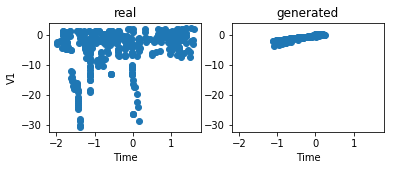

394 394
epoch: 10, Accuracy: 0.7385786802030457
[10/5001]	Loss_D: -0.4015	Loss_G: -0.0890	


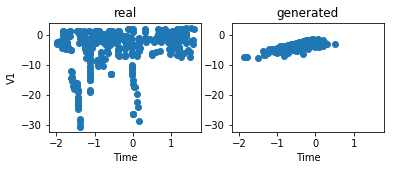

394 394
epoch: 20, Accuracy: 0.9619289340101523
[20/5001]	Loss_D: -0.2904	Loss_G: -0.0373	


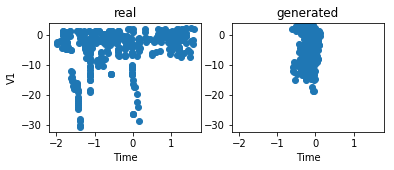

394 394
epoch: 30, Accuracy: 0.9568527918781726
[30/5001]	Loss_D: -0.3589	Loss_G: -0.0183	


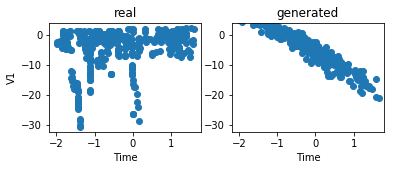

394 394
epoch: 40, Accuracy: 0.9670050761421319
[40/5001]	Loss_D: -0.1863	Loss_G: 0.0670	


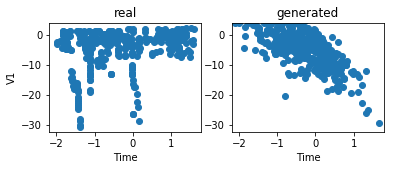

394 394
epoch: 50, Accuracy: 0.916243654822335
[50/5001]	Loss_D: -0.2191	Loss_G: 0.0163	


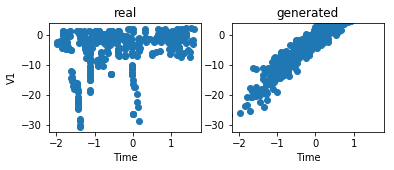

394 394
epoch: 60, Accuracy: 0.8934010152284264
[60/5001]	Loss_D: -0.2113	Loss_G: -0.0245	


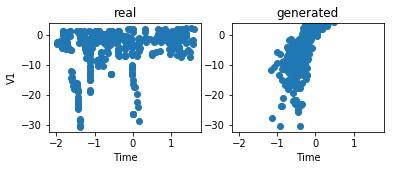

394 394
epoch: 70, Accuracy: 0.9517766497461929
[70/5001]	Loss_D: -0.2256	Loss_G: 0.0133	


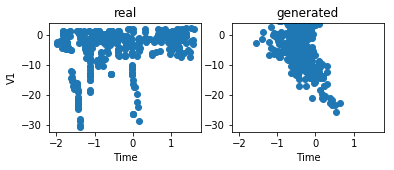

394 394
epoch: 80, Accuracy: 0.9619289340101523
[80/5001]	Loss_D: -0.2225	Loss_G: 0.0576	


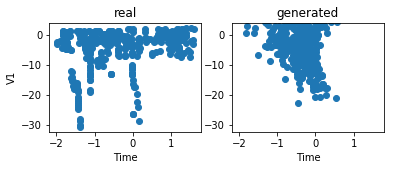

394 394
epoch: 90, Accuracy: 0.9416243654822335
[90/5001]	Loss_D: -0.2245	Loss_G: -0.0199	


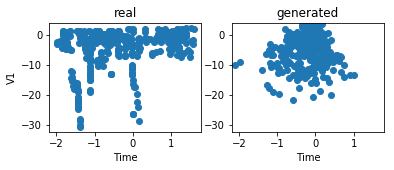

394 394
epoch: 100, Accuracy: 0.8984771573604061
[100/5001]	Loss_D: -0.1892	Loss_G: -0.0149	


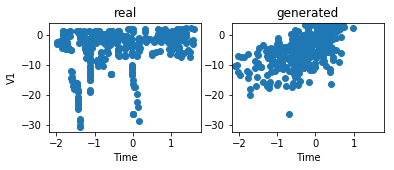

394 394
epoch: 110, Accuracy: 0.9720812182741116
[110/5001]	Loss_D: -0.1715	Loss_G: -0.0772	


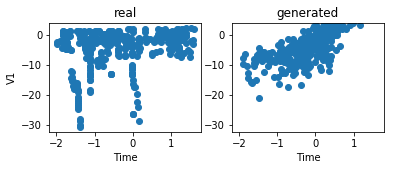

394 394
epoch: 120, Accuracy: 0.9416243654822335
[120/5001]	Loss_D: -0.1475	Loss_G: -0.0047	


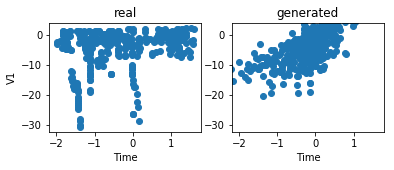

394 394
epoch: 130, Accuracy: 0.9390862944162437
[130/5001]	Loss_D: -0.1453	Loss_G: -0.0395	


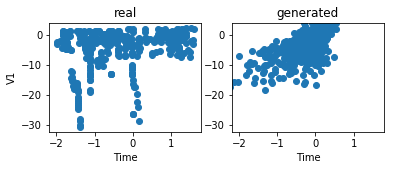

394 394
epoch: 140, Accuracy: 0.9289340101522843
[140/5001]	Loss_D: -0.1492	Loss_G: 0.0582	


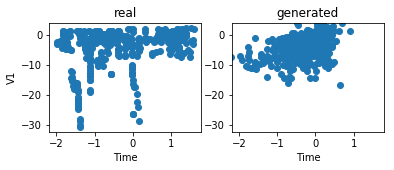

394 394
epoch: 150, Accuracy: 0.9137055837563451
[150/5001]	Loss_D: -0.1781	Loss_G: -0.0238	


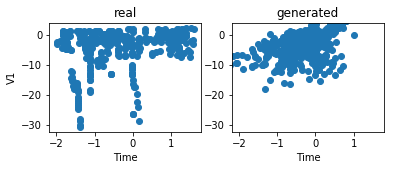

394 394
epoch: 160, Accuracy: 0.9086294416243654
[160/5001]	Loss_D: -0.1771	Loss_G: 0.0390	


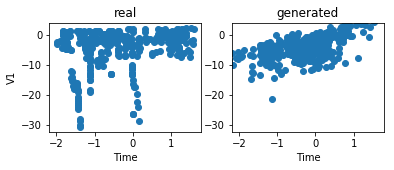

394 394
epoch: 170, Accuracy: 0.8604060913705583
[170/5001]	Loss_D: -0.1694	Loss_G: 0.0731	


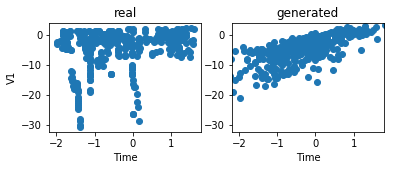

394 394
epoch: 180, Accuracy: 0.8756345177664975
[180/5001]	Loss_D: -0.1584	Loss_G: 0.0106	


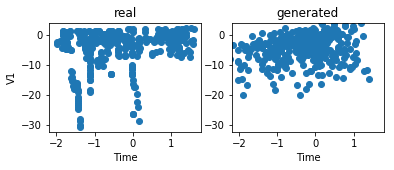

394 394
epoch: 190, Accuracy: 0.8934010152284264
[190/5001]	Loss_D: -0.1499	Loss_G: 0.0584	


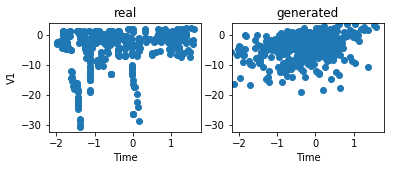

394 394
epoch: 200, Accuracy: 0.883248730964467
[200/5001]	Loss_D: -0.1592	Loss_G: -0.0282	


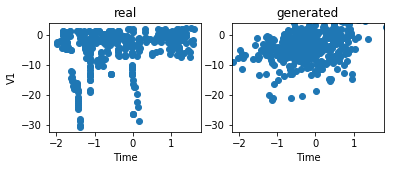

394 394
epoch: 210, Accuracy: 0.9314720812182741
[210/5001]	Loss_D: -0.1578	Loss_G: -0.0536	


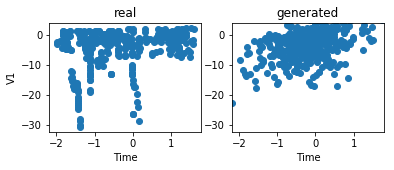

394 394
epoch: 220, Accuracy: 0.868020304568528
[220/5001]	Loss_D: -0.1506	Loss_G: 0.0315	


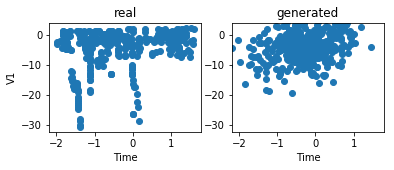

394 394
epoch: 230, Accuracy: 0.9390862944162437
[230/5001]	Loss_D: -0.1700	Loss_G: -0.0620	


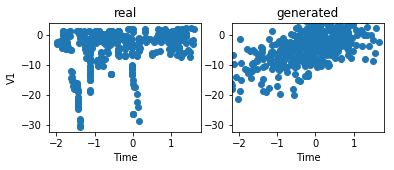

394 394
epoch: 240, Accuracy: 0.9238578680203046
[240/5001]	Loss_D: -0.1507	Loss_G: 0.0223	


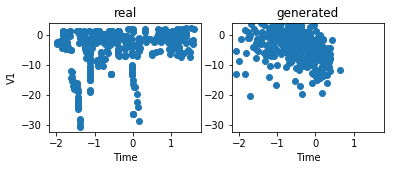

394 394
epoch: 250, Accuracy: 0.9213197969543148
[250/5001]	Loss_D: -0.1610	Loss_G: 0.1179	


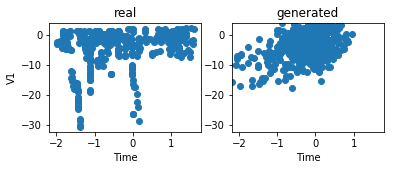

394 394
epoch: 260, Accuracy: 0.9010152284263959
[260/5001]	Loss_D: -0.1070	Loss_G: 0.0668	


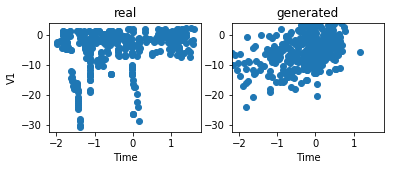

394 394
epoch: 270, Accuracy: 0.9035532994923858
[270/5001]	Loss_D: -0.1594	Loss_G: -0.0385	


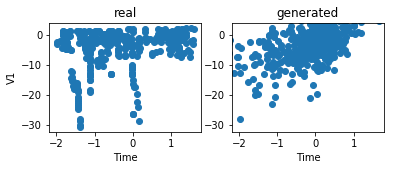

394 394
epoch: 280, Accuracy: 0.8730964467005076
[280/5001]	Loss_D: -0.1523	Loss_G: -0.0065	


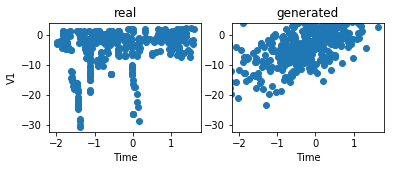

394 394
epoch: 290, Accuracy: 0.9137055837563451
[290/5001]	Loss_D: -0.1028	Loss_G: -0.0148	


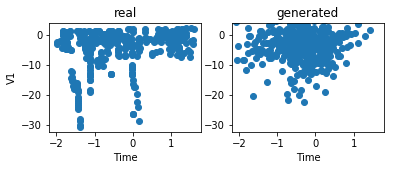

394 394
epoch: 300, Accuracy: 0.8807106598984772
[300/5001]	Loss_D: -0.1107	Loss_G: -0.0554	


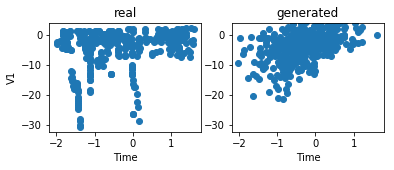

394 394
epoch: 310, Accuracy: 0.9137055837563451
[310/5001]	Loss_D: -0.1175	Loss_G: 0.0174	


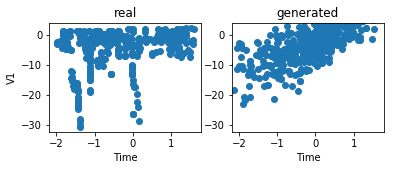

394 394
epoch: 320, Accuracy: 0.9086294416243654
[320/5001]	Loss_D: -0.1450	Loss_G: 0.0977	


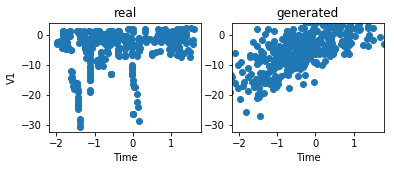

394 394
epoch: 330, Accuracy: 0.8984771573604061
[330/5001]	Loss_D: -0.1086	Loss_G: 0.0591	


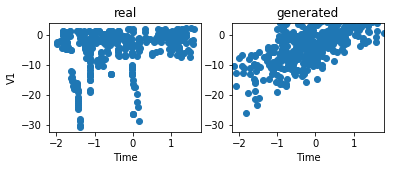

394 394
epoch: 340, Accuracy: 0.9390862944162437
[340/5001]	Loss_D: -0.0837	Loss_G: 0.0623	


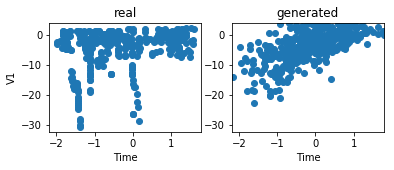

394 394
epoch: 350, Accuracy: 0.9111675126903553
[350/5001]	Loss_D: -0.1314	Loss_G: -0.0028	


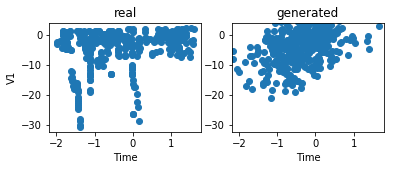

394 394
epoch: 360, Accuracy: 0.9035532994923858
[360/5001]	Loss_D: -0.1041	Loss_G: -0.0390	


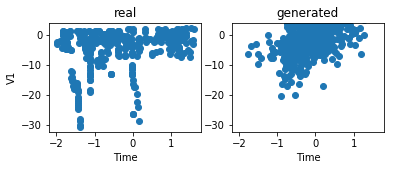

394 394
epoch: 370, Accuracy: 0.8984771573604061
[370/5001]	Loss_D: -0.1364	Loss_G: -0.0140	


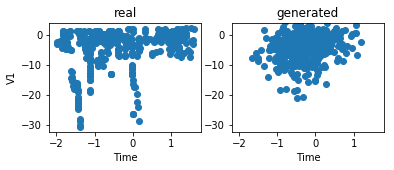

394 394
epoch: 380, Accuracy: 0.9086294416243654
[380/5001]	Loss_D: -0.1388	Loss_G: 0.0281	


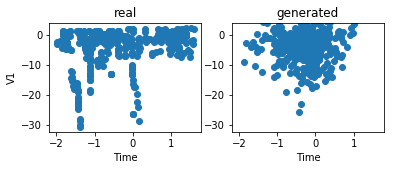

394 394
epoch: 390, Accuracy: 0.8984771573604061
[390/5001]	Loss_D: -0.0978	Loss_G: 0.0541	


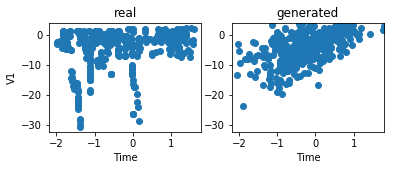

394 394
epoch: 400, Accuracy: 0.9238578680203046
[400/5001]	Loss_D: -0.0592	Loss_G: 0.0940	


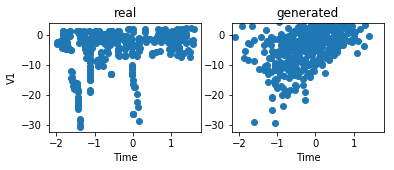

394 394
epoch: 410, Accuracy: 0.9238578680203046
[410/5001]	Loss_D: -0.1112	Loss_G: -0.0214	


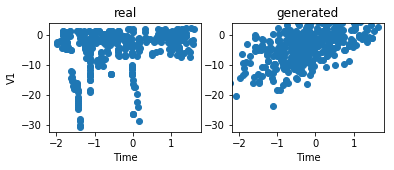

394 394
epoch: 420, Accuracy: 0.9086294416243654
[420/5001]	Loss_D: -0.0836	Loss_G: -0.1488	


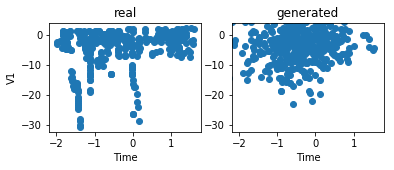

394 394
epoch: 430, Accuracy: 0.8883248730964467
[430/5001]	Loss_D: -0.0949	Loss_G: -0.0104	


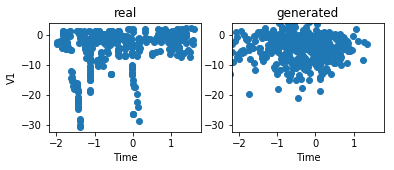

394 394
epoch: 440, Accuracy: 0.9035532994923858
[440/5001]	Loss_D: -0.0650	Loss_G: -0.2151	


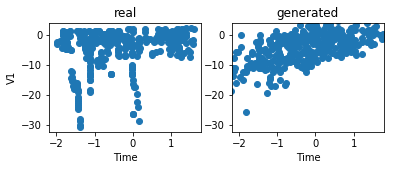

394 394
epoch: 450, Accuracy: 0.883248730964467
[450/5001]	Loss_D: -0.1126	Loss_G: -0.0629	


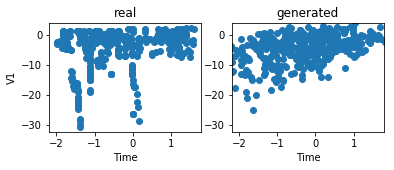

394 394
epoch: 460, Accuracy: 0.8984771573604061
[460/5001]	Loss_D: -0.0751	Loss_G: 0.0081	


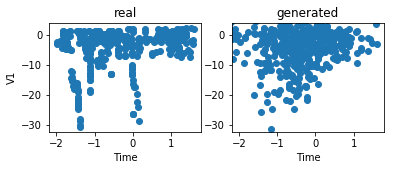

394 394
epoch: 470, Accuracy: 0.9060913705583756
[470/5001]	Loss_D: -0.0835	Loss_G: -0.0358	


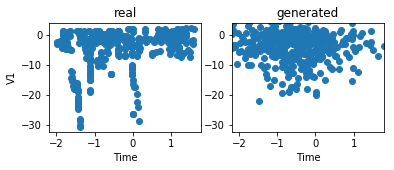

394 394
epoch: 480, Accuracy: 0.9137055837563451
[480/5001]	Loss_D: -0.0905	Loss_G: -0.0297	


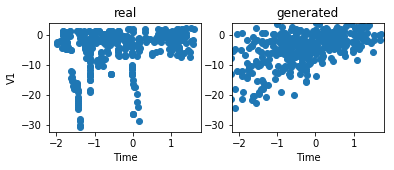

394 394
epoch: 490, Accuracy: 0.8553299492385786
[490/5001]	Loss_D: -0.0804	Loss_G: -0.1283	


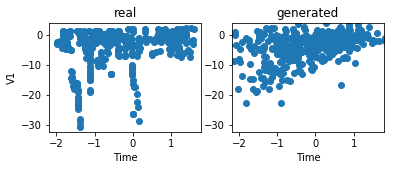

394 394
epoch: 500, Accuracy: 0.9111675126903553
[500/5001]	Loss_D: -0.0930	Loss_G: 0.0281	


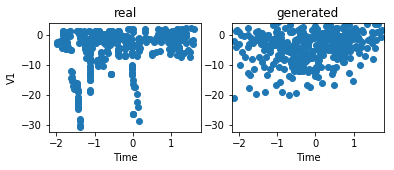

394 394
epoch: 510, Accuracy: 0.8908629441624365
[510/5001]	Loss_D: -0.1018	Loss_G: -0.0559	


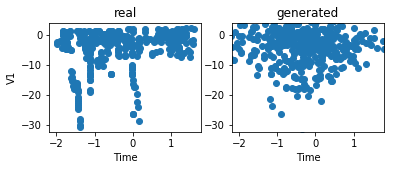

394 394
epoch: 520, Accuracy: 0.9289340101522843
[520/5001]	Loss_D: -0.0908	Loss_G: -0.0813	


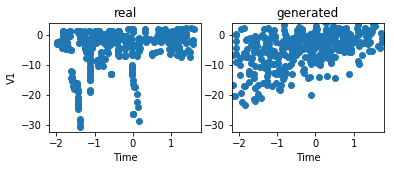

394 394
epoch: 530, Accuracy: 0.8654822335025381
[530/5001]	Loss_D: -0.1145	Loss_G: -0.0212	


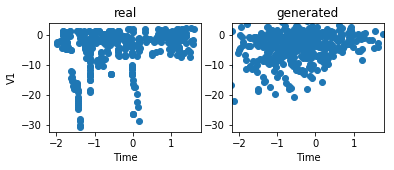

394 394
epoch: 540, Accuracy: 0.8781725888324873
[540/5001]	Loss_D: -0.0852	Loss_G: -0.0159	


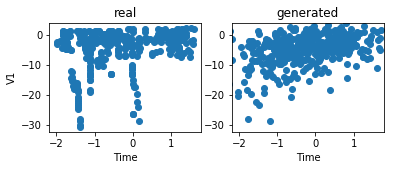

394 394
epoch: 550, Accuracy: 0.8959390862944162
[550/5001]	Loss_D: -0.0939	Loss_G: -0.1067	


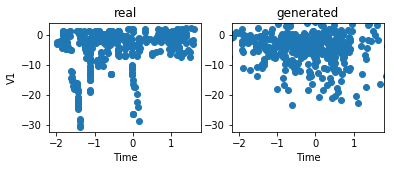

394 394
epoch: 560, Accuracy: 0.8324873096446701
[560/5001]	Loss_D: -0.0875	Loss_G: -0.1084	


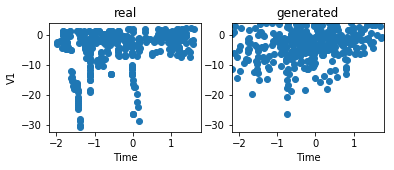

394 394
epoch: 570, Accuracy: 0.9035532994923858
[570/5001]	Loss_D: -0.0790	Loss_G: 0.1161	


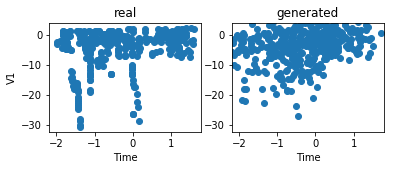

394 394
epoch: 580, Accuracy: 0.9035532994923858
[580/5001]	Loss_D: -0.0921	Loss_G: -0.0488	


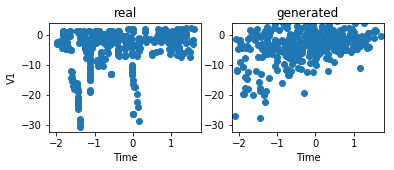

394 394
epoch: 590, Accuracy: 0.850253807106599
[590/5001]	Loss_D: -0.1101	Loss_G: 0.0605	


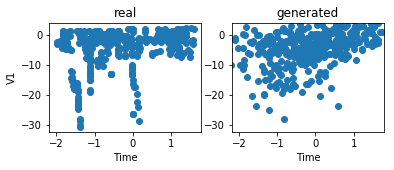

394 394
epoch: 600, Accuracy: 0.8527918781725888
[600/5001]	Loss_D: -0.1067	Loss_G: 0.0419	


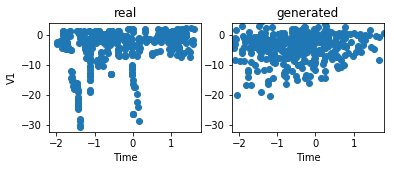

394 394
epoch: 610, Accuracy: 0.8807106598984772
[610/5001]	Loss_D: -0.0527	Loss_G: 0.0242	


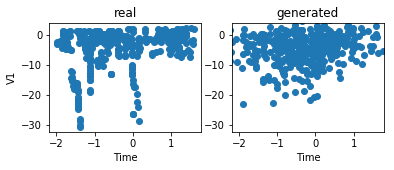

394 394
epoch: 620, Accuracy: 0.8807106598984772
[620/5001]	Loss_D: -0.1125	Loss_G: 0.0010	


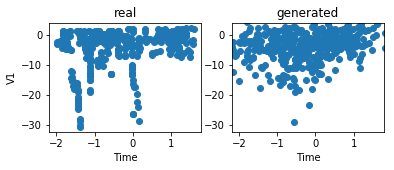

394 394
epoch: 630, Accuracy: 0.8527918781725888
[630/5001]	Loss_D: -0.0680	Loss_G: -0.0350	


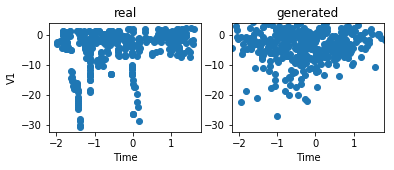

394 394
epoch: 640, Accuracy: 0.9010152284263959
[640/5001]	Loss_D: -0.0555	Loss_G: 0.0036	


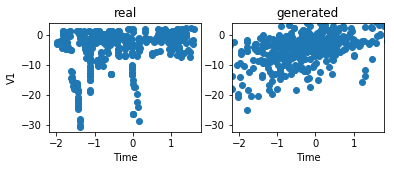

394 394
epoch: 650, Accuracy: 0.9187817258883249
[650/5001]	Loss_D: -0.0833	Loss_G: -0.0431	


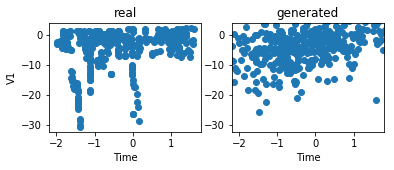

394 394
epoch: 660, Accuracy: 0.8984771573604061
[660/5001]	Loss_D: -0.0654	Loss_G: 0.0371	


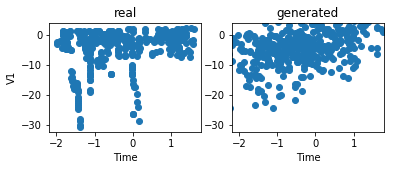

394 394
epoch: 670, Accuracy: 0.883248730964467
[670/5001]	Loss_D: -0.1118	Loss_G: -0.1262	


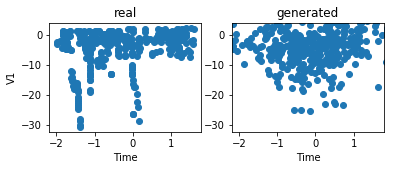

394 394
epoch: 680, Accuracy: 0.850253807106599
[680/5001]	Loss_D: -0.1006	Loss_G: -0.0326	


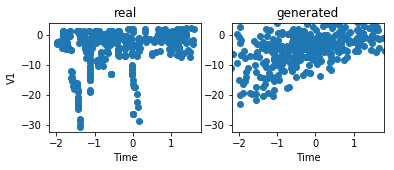

394 394
epoch: 690, Accuracy: 0.9086294416243654
[690/5001]	Loss_D: -0.1295	Loss_G: -0.1447	


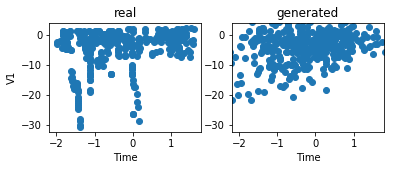

394 394
epoch: 700, Accuracy: 0.8807106598984772
[700/5001]	Loss_D: -0.0983	Loss_G: -0.0554	


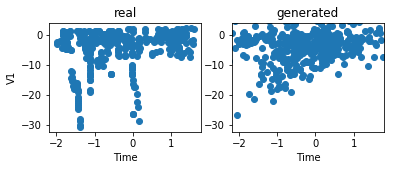

394 394
epoch: 710, Accuracy: 0.8553299492385786
[710/5001]	Loss_D: -0.0771	Loss_G: -0.0094	


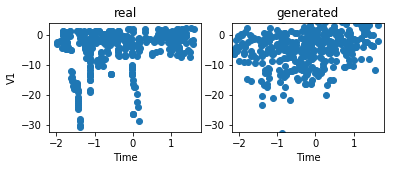

394 394
epoch: 720, Accuracy: 0.8984771573604061
[720/5001]	Loss_D: -0.0849	Loss_G: -0.0811	


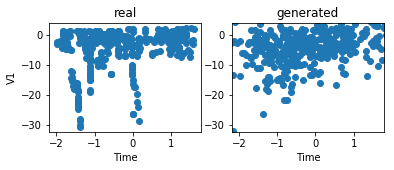

394 394
epoch: 730, Accuracy: 0.8934010152284264
[730/5001]	Loss_D: -0.0535	Loss_G: 0.0055	


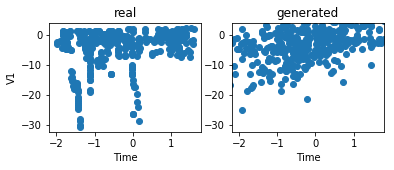

394 394
epoch: 740, Accuracy: 0.9035532994923858
[740/5001]	Loss_D: -0.0989	Loss_G: -0.1106	


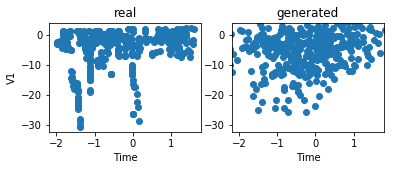

394 394
epoch: 750, Accuracy: 0.9010152284263959
[750/5001]	Loss_D: -0.1179	Loss_G: 0.0195	


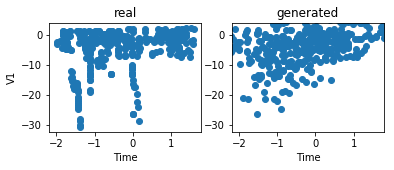

394 394
epoch: 760, Accuracy: 0.9111675126903553
[760/5001]	Loss_D: -0.0902	Loss_G: -0.0554	


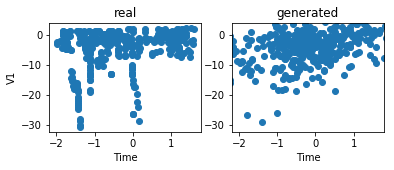

394 394
epoch: 770, Accuracy: 0.8781725888324873
[770/5001]	Loss_D: -0.1006	Loss_G: -0.0331	


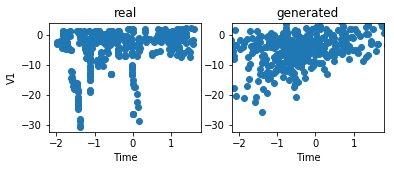

394 394
epoch: 780, Accuracy: 0.8807106598984772
[780/5001]	Loss_D: -0.1008	Loss_G: -0.0480	


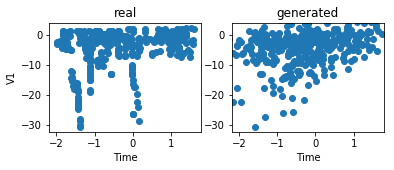

394 394
epoch: 790, Accuracy: 0.883248730964467
[790/5001]	Loss_D: -0.0317	Loss_G: 0.0458	


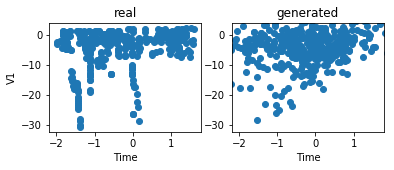

394 394
epoch: 800, Accuracy: 0.8883248730964467
[800/5001]	Loss_D: -0.0284	Loss_G: -0.0290	


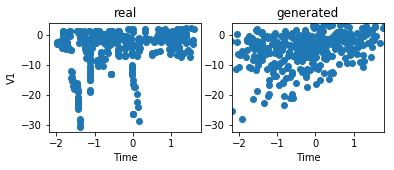

394 394
epoch: 810, Accuracy: 0.8959390862944162
[810/5001]	Loss_D: -0.0500	Loss_G: -0.0719	


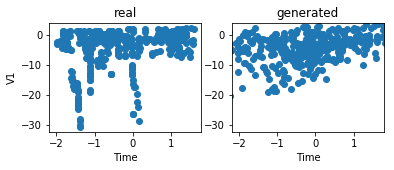

394 394
epoch: 820, Accuracy: 0.883248730964467
[820/5001]	Loss_D: -0.0642	Loss_G: 0.0324	


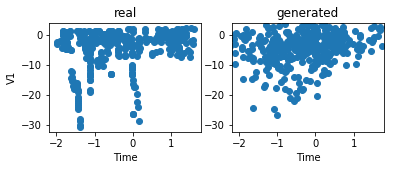

394 394
epoch: 830, Accuracy: 0.8807106598984772
[830/5001]	Loss_D: -0.0830	Loss_G: -0.1309	


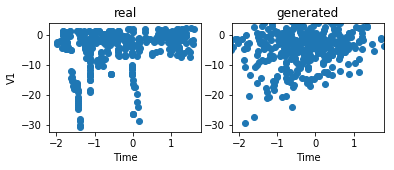

394 394
epoch: 840, Accuracy: 0.8781725888324873
[840/5001]	Loss_D: -0.0513	Loss_G: 0.0612	


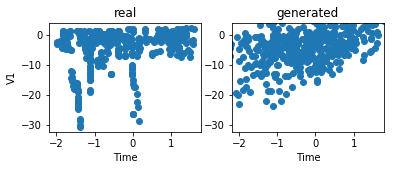

394 394
epoch: 850, Accuracy: 0.8934010152284264
[850/5001]	Loss_D: -0.0767	Loss_G: 0.0386	


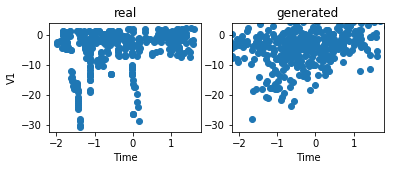

394 394
epoch: 860, Accuracy: 0.8629441624365483
[860/5001]	Loss_D: -0.0820	Loss_G: -0.1271	


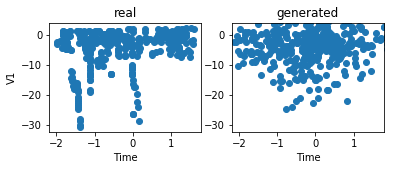

394 394
epoch: 870, Accuracy: 0.8553299492385786
[870/5001]	Loss_D: -0.0622	Loss_G: 0.0396	


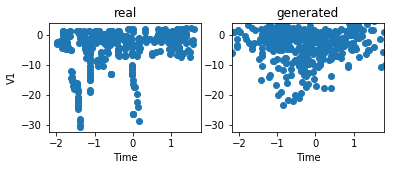

394 394
epoch: 880, Accuracy: 0.8629441624365483
[880/5001]	Loss_D: -0.0781	Loss_G: -0.0965	


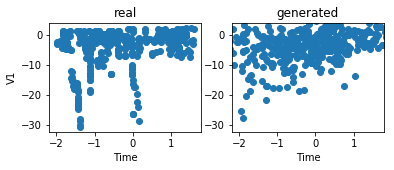

394 394
epoch: 890, Accuracy: 0.8984771573604061
[890/5001]	Loss_D: -0.0648	Loss_G: -0.0025	


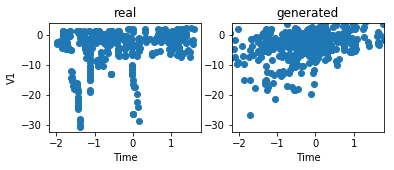

394 394
epoch: 900, Accuracy: 0.8857868020304569
[900/5001]	Loss_D: -0.0770	Loss_G: -0.0519	


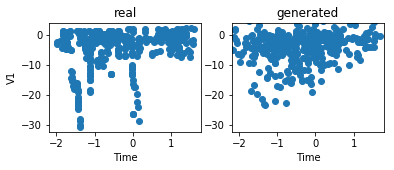

394 394
epoch: 910, Accuracy: 0.8883248730964467
[910/5001]	Loss_D: -0.0812	Loss_G: 0.0217	


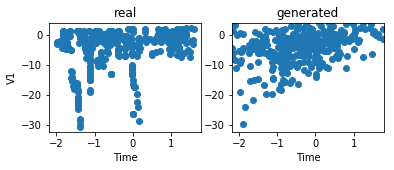

394 394
epoch: 920, Accuracy: 0.8299492385786802
[920/5001]	Loss_D: -0.0646	Loss_G: 0.1070	


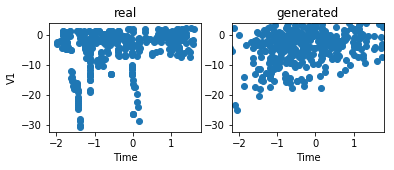

394 394
epoch: 930, Accuracy: 0.883248730964467
[930/5001]	Loss_D: -0.1083	Loss_G: -0.0764	


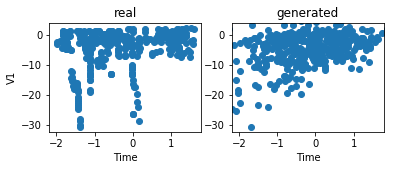

394 394
epoch: 940, Accuracy: 0.8654822335025381
[940/5001]	Loss_D: -0.0445	Loss_G: 0.1221	


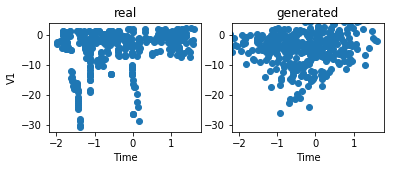

394 394
epoch: 950, Accuracy: 0.868020304568528
[950/5001]	Loss_D: -0.0692	Loss_G: 0.0668	


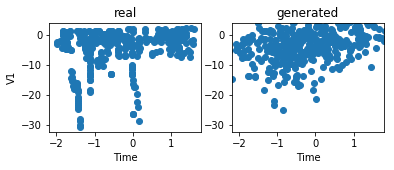

394 394
epoch: 960, Accuracy: 0.868020304568528
[960/5001]	Loss_D: -0.0424	Loss_G: -0.0302	


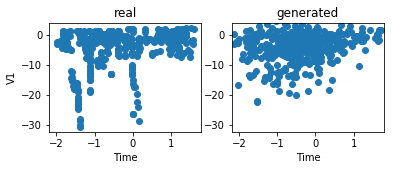

394 394
epoch: 970, Accuracy: 0.8730964467005076
[970/5001]	Loss_D: -0.0766	Loss_G: -0.0640	


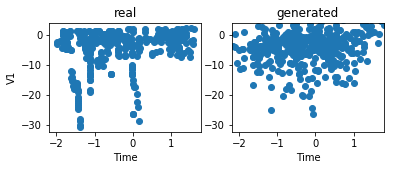

394 394
epoch: 980, Accuracy: 0.8908629441624365
[980/5001]	Loss_D: -0.1280	Loss_G: -0.0416	


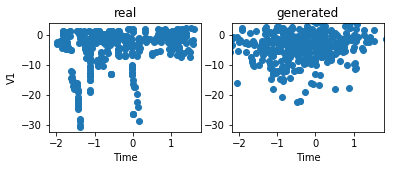

394 394
epoch: 990, Accuracy: 0.9060913705583756
[990/5001]	Loss_D: -0.0642	Loss_G: -0.0866	


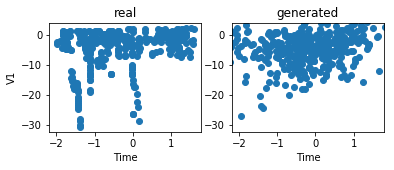

394 394
epoch: 1000, Accuracy: 0.8756345177664975
[1000/5001]	Loss_D: -0.0421	Loss_G: 0.1379	


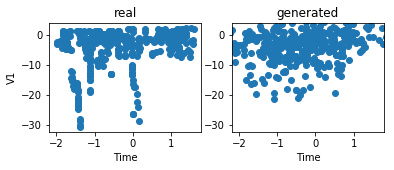

394 394
epoch: 1010, Accuracy: 0.9035532994923858
[1010/5001]	Loss_D: -0.0604	Loss_G: -0.0488	


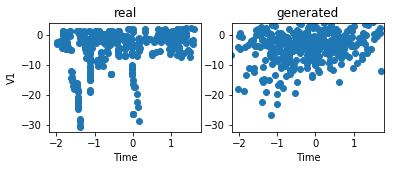

394 394
epoch: 1020, Accuracy: 0.8477157360406091
[1020/5001]	Loss_D: -0.0497	Loss_G: -0.0798	


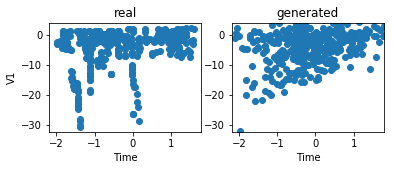

394 394
epoch: 1030, Accuracy: 0.8934010152284264
[1030/5001]	Loss_D: -0.0689	Loss_G: -0.1883	


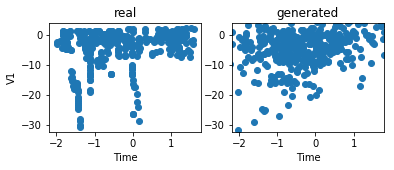

394 394
epoch: 1040, Accuracy: 0.8959390862944162
[1040/5001]	Loss_D: -0.0659	Loss_G: -0.1688	


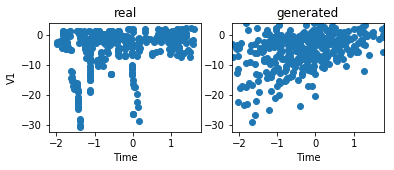

394 394
epoch: 1050, Accuracy: 0.9086294416243654
[1050/5001]	Loss_D: -0.0507	Loss_G: 0.0310	


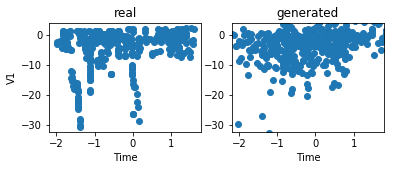

394 394
epoch: 1060, Accuracy: 0.8883248730964467
[1060/5001]	Loss_D: -0.0454	Loss_G: 0.1139	


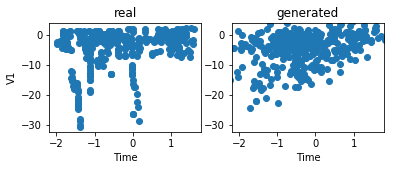

394 394
epoch: 1070, Accuracy: 0.8908629441624365
[1070/5001]	Loss_D: -0.0386	Loss_G: 0.2353	


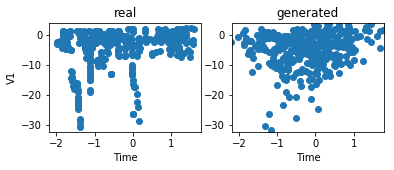

394 394
epoch: 1080, Accuracy: 0.8883248730964467
[1080/5001]	Loss_D: -0.0314	Loss_G: 0.0916	


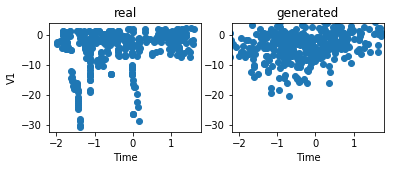

394 394
epoch: 1090, Accuracy: 0.8959390862944162
[1090/5001]	Loss_D: -0.0346	Loss_G: 0.1787	


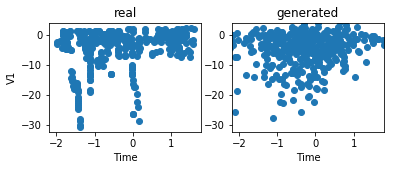

394 394
epoch: 1100, Accuracy: 0.8781725888324873
[1100/5001]	Loss_D: -0.0414	Loss_G: -0.0575	


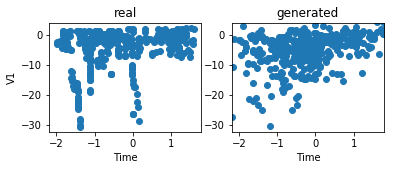

394 394
epoch: 1110, Accuracy: 0.8908629441624365
[1110/5001]	Loss_D: -0.1183	Loss_G: 0.1199	


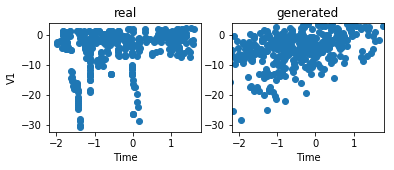

394 394
epoch: 1120, Accuracy: 0.8781725888324873
[1120/5001]	Loss_D: -0.0469	Loss_G: 0.0019	


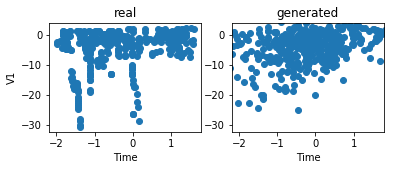

394 394
epoch: 1130, Accuracy: 0.8477157360406091
[1130/5001]	Loss_D: -0.0486	Loss_G: 0.0429	


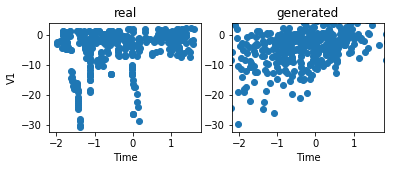

394 394
epoch: 1140, Accuracy: 0.9010152284263959
[1140/5001]	Loss_D: -0.0501	Loss_G: -0.1378	


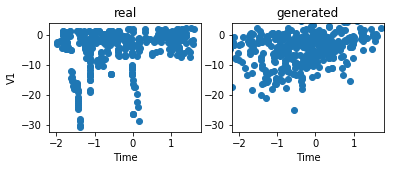

394 394
epoch: 1150, Accuracy: 0.8350253807106599
[1150/5001]	Loss_D: -0.0556	Loss_G: 0.0868	


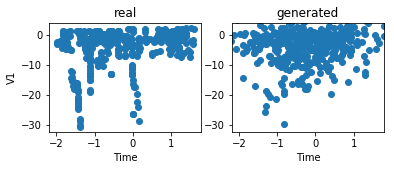

394 394
epoch: 1160, Accuracy: 0.8756345177664975
[1160/5001]	Loss_D: -0.0994	Loss_G: 0.0088	


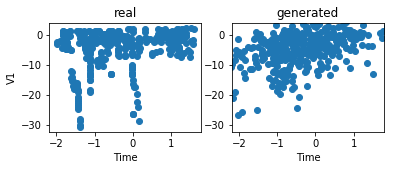

394 394
epoch: 1170, Accuracy: 0.8629441624365483
[1170/5001]	Loss_D: -0.0513	Loss_G: 0.3093	


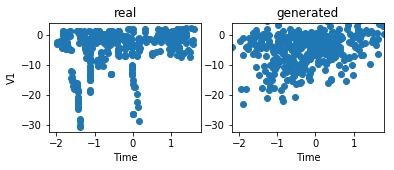

394 394
epoch: 1180, Accuracy: 0.8857868020304569
[1180/5001]	Loss_D: -0.0427	Loss_G: -0.0624	


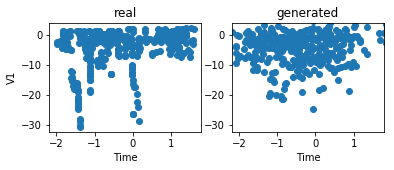

394 394
epoch: 1190, Accuracy: 0.8883248730964467
[1190/5001]	Loss_D: -0.0286	Loss_G: 0.1353	


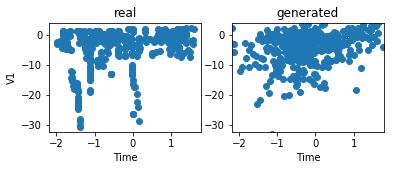

394 394
epoch: 1200, Accuracy: 0.8426395939086294
[1200/5001]	Loss_D: -0.0539	Loss_G: 0.0065	


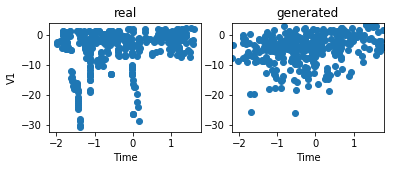

394 394
epoch: 1210, Accuracy: 0.8654822335025381
[1210/5001]	Loss_D: -0.0684	Loss_G: 0.1566	


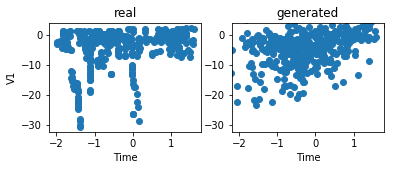

394 394
epoch: 1220, Accuracy: 0.883248730964467
[1220/5001]	Loss_D: -0.0311	Loss_G: -0.1086	


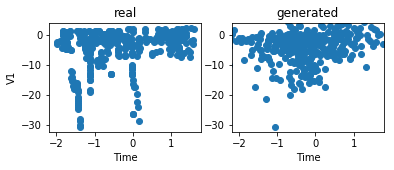

394 394
epoch: 1230, Accuracy: 0.8477157360406091
[1230/5001]	Loss_D: 0.0002	Loss_G: -0.0462	


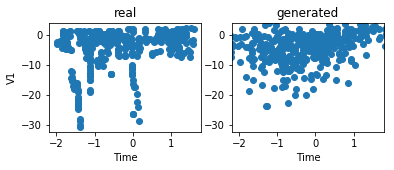

394 394
epoch: 1240, Accuracy: 0.8781725888324873
[1240/5001]	Loss_D: -0.0732	Loss_G: 0.1354	


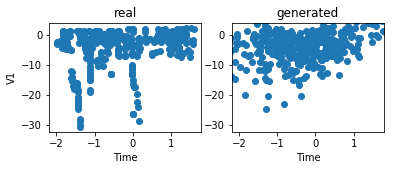

394 394
epoch: 1250, Accuracy: 0.8807106598984772
[1250/5001]	Loss_D: -0.0018	Loss_G: 0.0877	


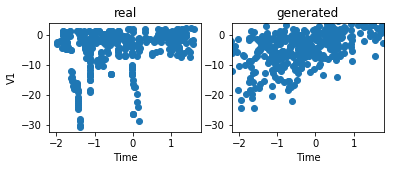

394 394
epoch: 1260, Accuracy: 0.916243654822335
[1260/5001]	Loss_D: -0.0827	Loss_G: -0.1597	


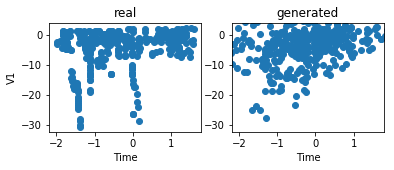

394 394
epoch: 1270, Accuracy: 0.868020304568528
[1270/5001]	Loss_D: -0.0610	Loss_G: -0.2018	


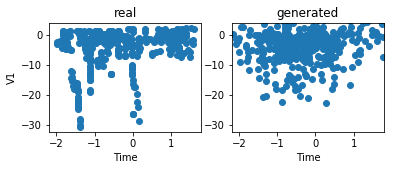

394 394
epoch: 1280, Accuracy: 0.8426395939086294
[1280/5001]	Loss_D: -0.0157	Loss_G: -0.0813	


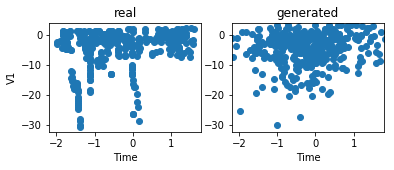

394 394
epoch: 1290, Accuracy: 0.8451776649746193
[1290/5001]	Loss_D: -0.0701	Loss_G: 0.0265	


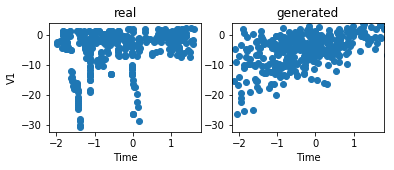

394 394
epoch: 1300, Accuracy: 0.8781725888324873
[1300/5001]	Loss_D: -0.0454	Loss_G: 0.0785	


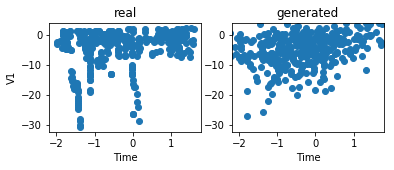

394 394
epoch: 1310, Accuracy: 0.8527918781725888
[1310/5001]	Loss_D: -0.0521	Loss_G: -0.0072	


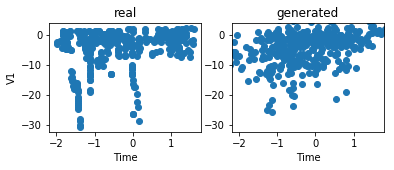

394 394
epoch: 1320, Accuracy: 0.8959390862944162
[1320/5001]	Loss_D: -0.0700	Loss_G: -0.1500	


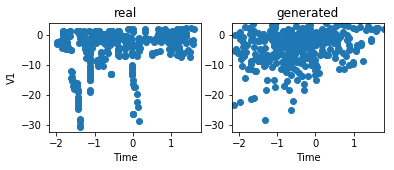

394 394
epoch: 1330, Accuracy: 0.8908629441624365
[1330/5001]	Loss_D: -0.0706	Loss_G: -0.2692	


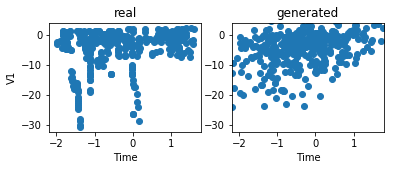

394 394
epoch: 1340, Accuracy: 0.8375634517766497
[1340/5001]	Loss_D: -0.0422	Loss_G: 0.1323	


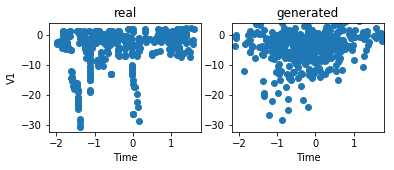

394 394
epoch: 1350, Accuracy: 0.8781725888324873
[1350/5001]	Loss_D: -0.0315	Loss_G: 0.0178	


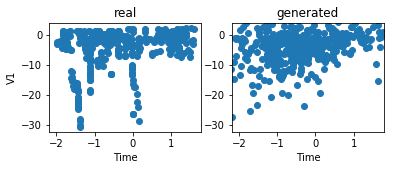

394 394
epoch: 1360, Accuracy: 0.8604060913705583
[1360/5001]	Loss_D: -0.0078	Loss_G: -0.0094	


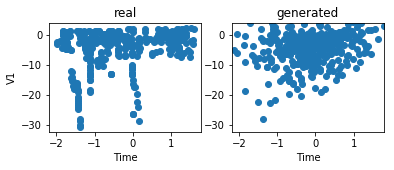

394 394
epoch: 1370, Accuracy: 0.8629441624365483
[1370/5001]	Loss_D: -0.0625	Loss_G: -0.0634	


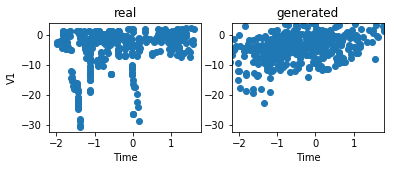

394 394
epoch: 1380, Accuracy: 0.8553299492385786
[1380/5001]	Loss_D: -0.0053	Loss_G: -0.0878	


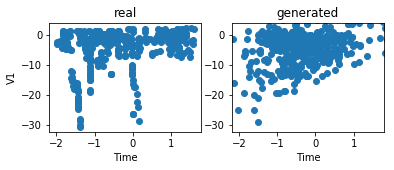

394 394
epoch: 1390, Accuracy: 0.850253807106599
[1390/5001]	Loss_D: -0.0675	Loss_G: 0.1404	


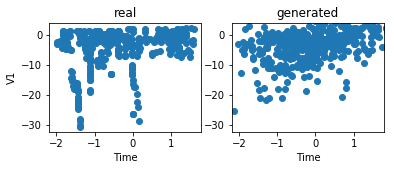

394 394
epoch: 1400, Accuracy: 0.8781725888324873
[1400/5001]	Loss_D: -0.0136	Loss_G: 0.1652	


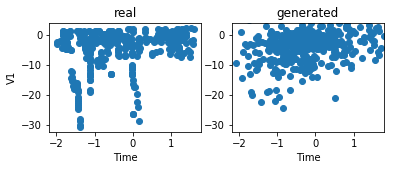

394 394
epoch: 1410, Accuracy: 0.8553299492385786
[1410/5001]	Loss_D: 0.0104	Loss_G: -0.2936	


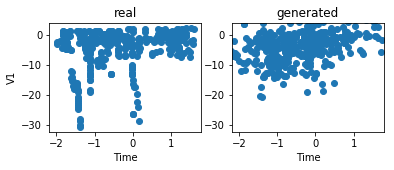

394 394
epoch: 1420, Accuracy: 0.8274111675126904
[1420/5001]	Loss_D: -0.0428	Loss_G: 0.3492	


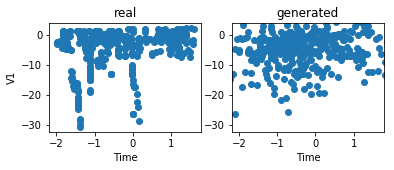

394 394
epoch: 1430, Accuracy: 0.8959390862944162
[1430/5001]	Loss_D: -0.0244	Loss_G: -0.1034	


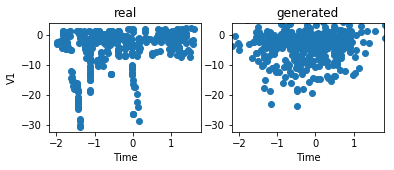

394 394
epoch: 1440, Accuracy: 0.9060913705583756
[1440/5001]	Loss_D: 0.0048	Loss_G: 0.0270	


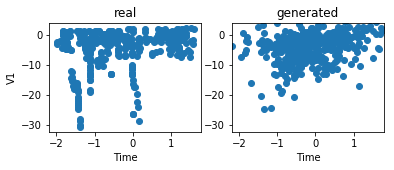

394 394
epoch: 1450, Accuracy: 0.8705583756345178
[1450/5001]	Loss_D: -0.0492	Loss_G: -0.0047	


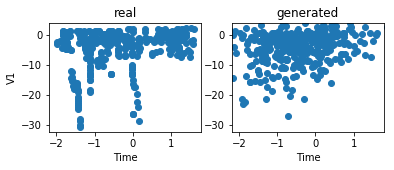

394 394
epoch: 1460, Accuracy: 0.8274111675126904
[1460/5001]	Loss_D: -0.0524	Loss_G: 0.0593	


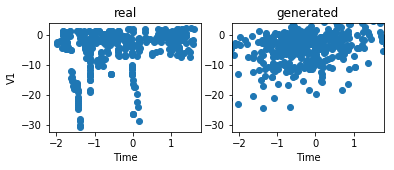

394 394
epoch: 1470, Accuracy: 0.8629441624365483
[1470/5001]	Loss_D: -0.0569	Loss_G: 0.1541	


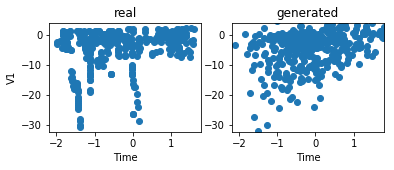

394 394
epoch: 1480, Accuracy: 0.8756345177664975
[1480/5001]	Loss_D: -0.0309	Loss_G: -0.0731	


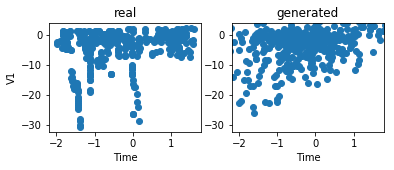

394 394
epoch: 1490, Accuracy: 0.8883248730964467
[1490/5001]	Loss_D: -0.0639	Loss_G: -0.1481	


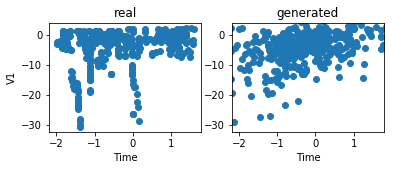

394 394
epoch: 1500, Accuracy: 0.9137055837563451
[1500/5001]	Loss_D: 0.0167	Loss_G: 0.1103	


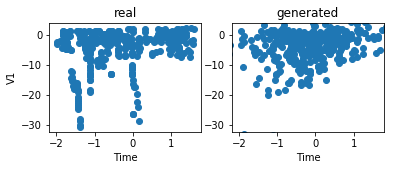

394 394
epoch: 1510, Accuracy: 0.8654822335025381
[1510/5001]	Loss_D: -0.0554	Loss_G: -0.4645	


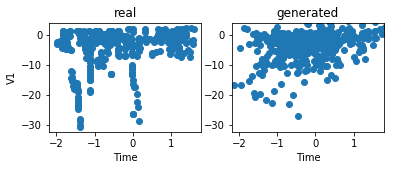

394 394
epoch: 1520, Accuracy: 0.868020304568528
[1520/5001]	Loss_D: 0.0100	Loss_G: 0.2466	


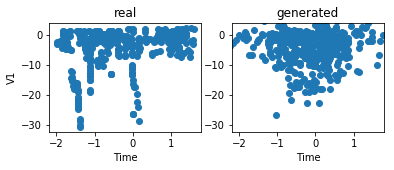

394 394
epoch: 1530, Accuracy: 0.850253807106599
[1530/5001]	Loss_D: -0.0090	Loss_G: -0.1344	


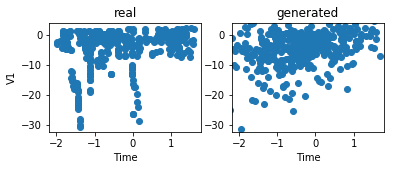

394 394
epoch: 1540, Accuracy: 0.8629441624365483
[1540/5001]	Loss_D: -0.0287	Loss_G: -0.2076	


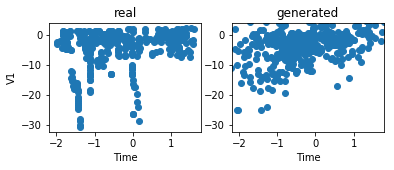

394 394
epoch: 1550, Accuracy: 0.8756345177664975
[1550/5001]	Loss_D: -0.0697	Loss_G: -0.4286	


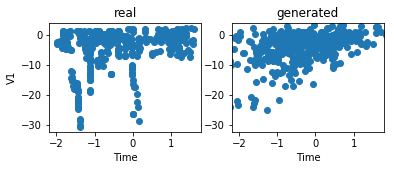

394 394
epoch: 1560, Accuracy: 0.8654822335025381
[1560/5001]	Loss_D: -0.0694	Loss_G: -0.4546	


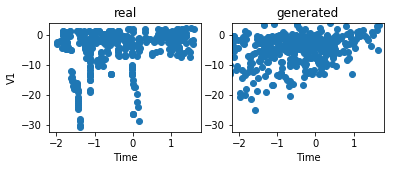

394 394
epoch: 1570, Accuracy: 0.8934010152284264
[1570/5001]	Loss_D: -0.0153	Loss_G: -0.1931	


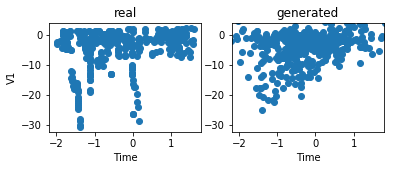

394 394
epoch: 1580, Accuracy: 0.8401015228426396
[1580/5001]	Loss_D: -0.0262	Loss_G: 0.6560	


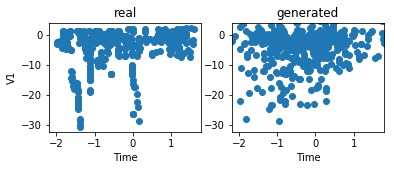

394 394
epoch: 1590, Accuracy: 0.8781725888324873
[1590/5001]	Loss_D: -0.0411	Loss_G: -0.2406	


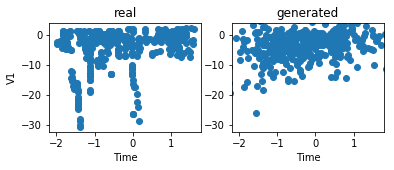

394 394
epoch: 1600, Accuracy: 0.8883248730964467
[1600/5001]	Loss_D: -0.0188	Loss_G: -0.1431	


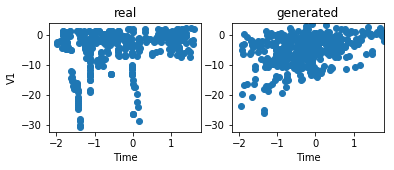

394 394
epoch: 1610, Accuracy: 0.8959390862944162
[1610/5001]	Loss_D: 0.0095	Loss_G: 0.0575	


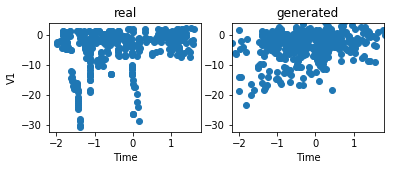

394 394
epoch: 1620, Accuracy: 0.8908629441624365
[1620/5001]	Loss_D: -0.0318	Loss_G: -0.1422	


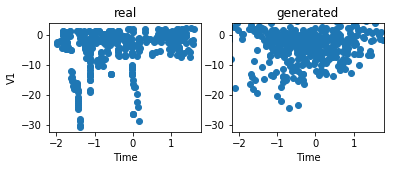

394 394
epoch: 1630, Accuracy: 0.8934010152284264
[1630/5001]	Loss_D: -0.0009	Loss_G: 0.0205	


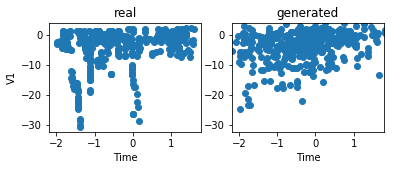

394 394
epoch: 1640, Accuracy: 0.8959390862944162
[1640/5001]	Loss_D: -0.0210	Loss_G: -0.0266	


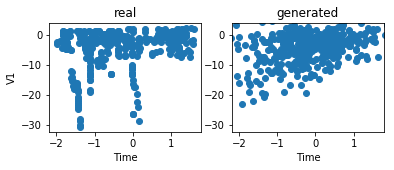

394 394
epoch: 1650, Accuracy: 0.8857868020304569
[1650/5001]	Loss_D: -0.0101	Loss_G: 0.0264	


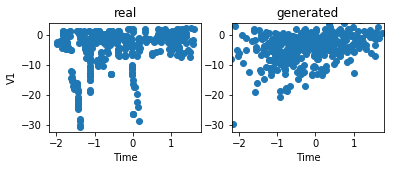

394 394
epoch: 1660, Accuracy: 0.8553299492385786
[1660/5001]	Loss_D: 0.0117	Loss_G: 0.3829	


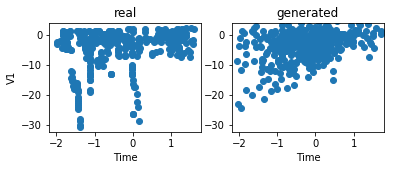

394 394
epoch: 1670, Accuracy: 0.8934010152284264
[1670/5001]	Loss_D: -0.0639	Loss_G: 0.5094	


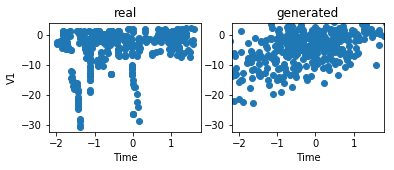

394 394
epoch: 1680, Accuracy: 0.8781725888324873
[1680/5001]	Loss_D: -0.0132	Loss_G: -0.1040	


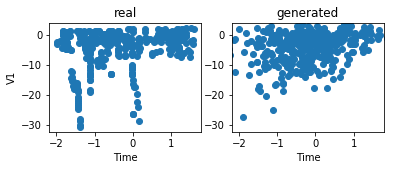

394 394
epoch: 1690, Accuracy: 0.8324873096446701
[1690/5001]	Loss_D: -0.0279	Loss_G: -0.0383	


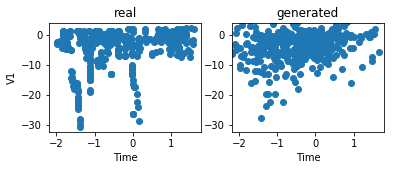

394 394
epoch: 1700, Accuracy: 0.8959390862944162
[1700/5001]	Loss_D: -0.0349	Loss_G: -0.0261	


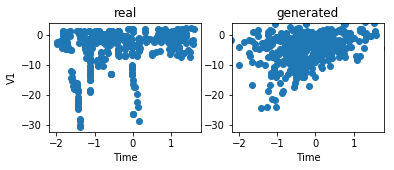

394 394
epoch: 1710, Accuracy: 0.8934010152284264
[1710/5001]	Loss_D: -0.0291	Loss_G: -0.0257	


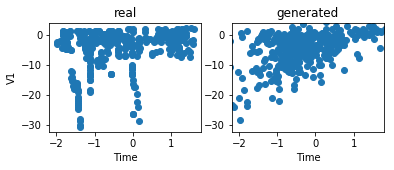

394 394
epoch: 1720, Accuracy: 0.850253807106599
[1720/5001]	Loss_D: -0.0500	Loss_G: -0.0256	


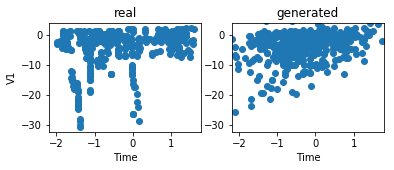

394 394
epoch: 1730, Accuracy: 0.8705583756345178
[1730/5001]	Loss_D: -0.0695	Loss_G: 0.0811	


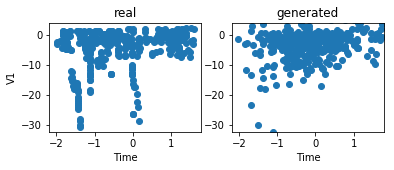

394 394
epoch: 1740, Accuracy: 0.8857868020304569
[1740/5001]	Loss_D: -0.0170	Loss_G: -0.0646	


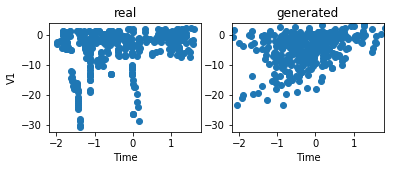

394 394
epoch: 1750, Accuracy: 0.8604060913705583
[1750/5001]	Loss_D: -0.0498	Loss_G: -0.0398	


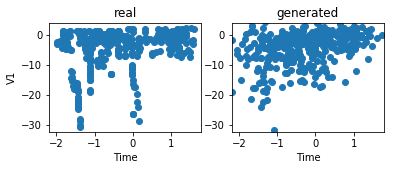

394 394
epoch: 1760, Accuracy: 0.8527918781725888
[1760/5001]	Loss_D: -0.0359	Loss_G: -0.0740	


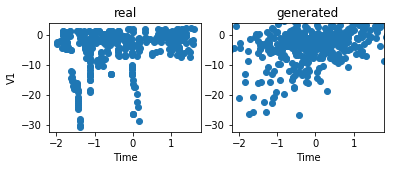

394 394
epoch: 1770, Accuracy: 0.9010152284263959
[1770/5001]	Loss_D: -0.0905	Loss_G: 0.0242	


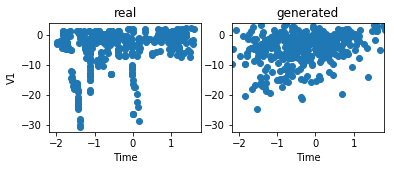

394 394
epoch: 1780, Accuracy: 0.8197969543147208
[1780/5001]	Loss_D: -0.0523	Loss_G: -0.1013	


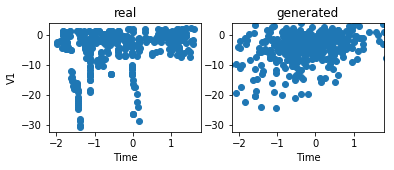

394 394
epoch: 1790, Accuracy: 0.8883248730964467
[1790/5001]	Loss_D: -0.0432	Loss_G: -0.0495	


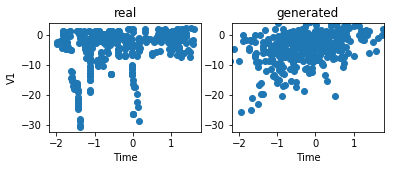

394 394
epoch: 1800, Accuracy: 0.8730964467005076
[1800/5001]	Loss_D: -0.0467	Loss_G: -0.1915	


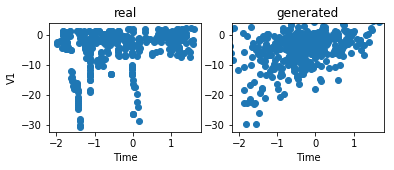

394 394
epoch: 1810, Accuracy: 0.8959390862944162
[1810/5001]	Loss_D: -0.0668	Loss_G: -0.1078	


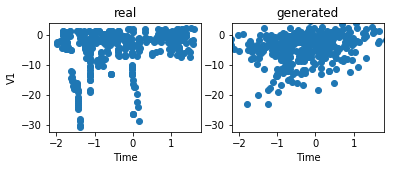

394 394
epoch: 1820, Accuracy: 0.8654822335025381
[1820/5001]	Loss_D: -0.0555	Loss_G: -0.0200	


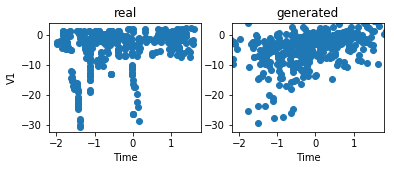

394 394
epoch: 1830, Accuracy: 0.8553299492385786
[1830/5001]	Loss_D: -0.0551	Loss_G: -0.0954	


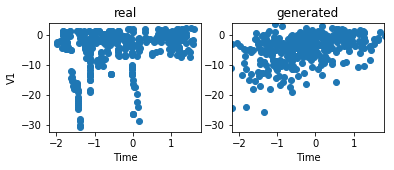

394 394
epoch: 1840, Accuracy: 0.850253807106599
[1840/5001]	Loss_D: -0.0696	Loss_G: -0.1102	


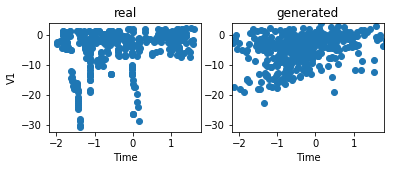

394 394
epoch: 1850, Accuracy: 0.8654822335025381
[1850/5001]	Loss_D: -0.0600	Loss_G: -0.0209	


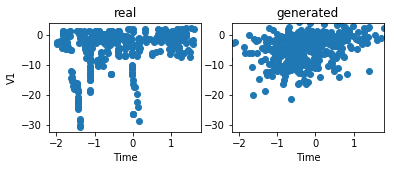

394 394
epoch: 1860, Accuracy: 0.8781725888324873
[1860/5001]	Loss_D: -0.0740	Loss_G: -0.0422	


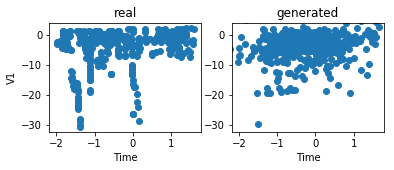

394 394
epoch: 1870, Accuracy: 0.8781725888324873
[1870/5001]	Loss_D: -0.0751	Loss_G: -0.0027	


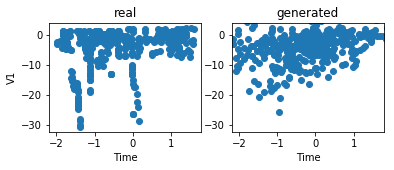

394 394
epoch: 1880, Accuracy: 0.8375634517766497
[1880/5001]	Loss_D: -0.0007	Loss_G: 0.0215	


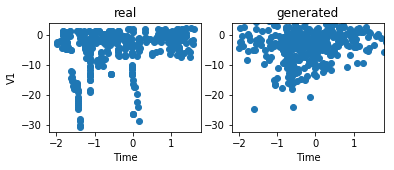

394 394
epoch: 1890, Accuracy: 0.8807106598984772
[1890/5001]	Loss_D: -0.0446	Loss_G: 0.2702	


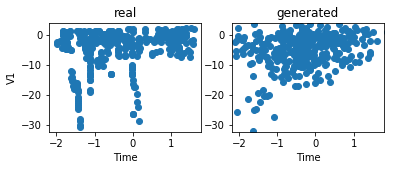

394 394
epoch: 1900, Accuracy: 0.8553299492385786
[1900/5001]	Loss_D: -0.0480	Loss_G: -0.0477	


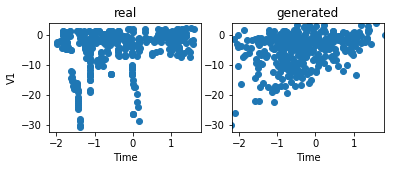

394 394
epoch: 1910, Accuracy: 0.8908629441624365
[1910/5001]	Loss_D: -0.0437	Loss_G: 0.0181	


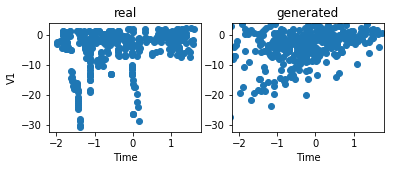

394 394
epoch: 1920, Accuracy: 0.8756345177664975
[1920/5001]	Loss_D: -0.0415	Loss_G: -0.0785	


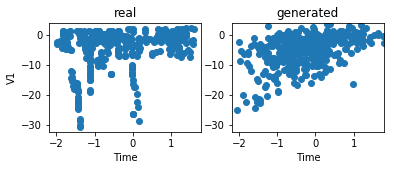

394 394
epoch: 1930, Accuracy: 0.8857868020304569
[1930/5001]	Loss_D: -0.0412	Loss_G: -0.0910	


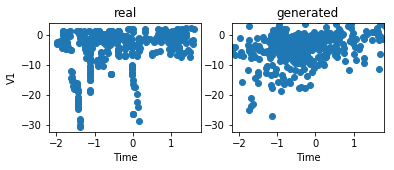

394 394
epoch: 1940, Accuracy: 0.8604060913705583
[1940/5001]	Loss_D: -0.0497	Loss_G: 0.2879	


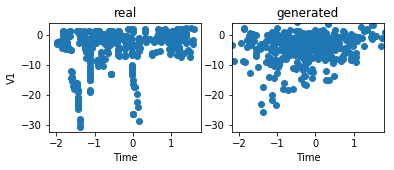

394 394
epoch: 1950, Accuracy: 0.8705583756345178
[1950/5001]	Loss_D: -0.0469	Loss_G: 0.1429	


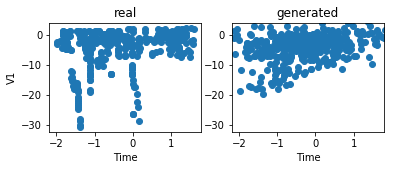

394 394
epoch: 1960, Accuracy: 0.8553299492385786
[1960/5001]	Loss_D: -0.0572	Loss_G: 0.0997	


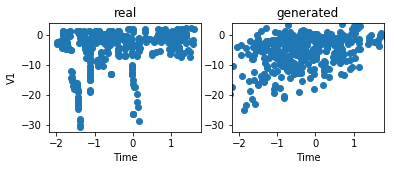

394 394
epoch: 1970, Accuracy: 0.8781725888324873
[1970/5001]	Loss_D: -0.0649	Loss_G: -0.1076	


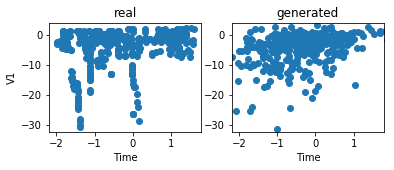

394 394
epoch: 1980, Accuracy: 0.8807106598984772
[1980/5001]	Loss_D: -0.0506	Loss_G: -0.0146	


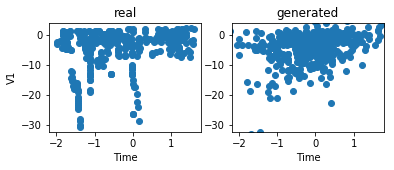

394 394
epoch: 1990, Accuracy: 0.8426395939086294
[1990/5001]	Loss_D: -0.0423	Loss_G: 0.1570	


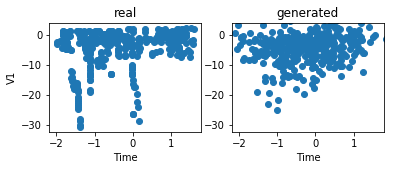

394 394
epoch: 2000, Accuracy: 0.8730964467005076
[2000/5001]	Loss_D: -0.0463	Loss_G: -0.1101	


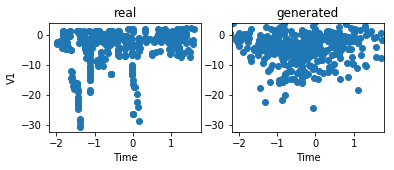

394 394
epoch: 2010, Accuracy: 0.8705583756345178
[2010/5001]	Loss_D: -0.0734	Loss_G: 0.2797	


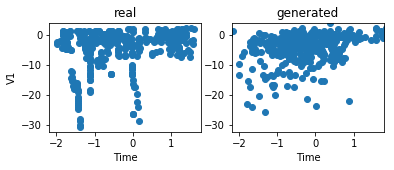

394 394
epoch: 2020, Accuracy: 0.868020304568528
[2020/5001]	Loss_D: -0.0716	Loss_G: 0.0207	


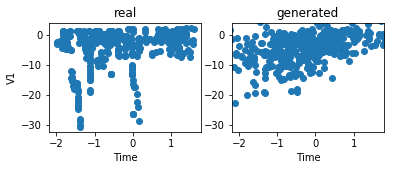

394 394
epoch: 2030, Accuracy: 0.8299492385786802
[2030/5001]	Loss_D: -0.0346	Loss_G: 0.0480	


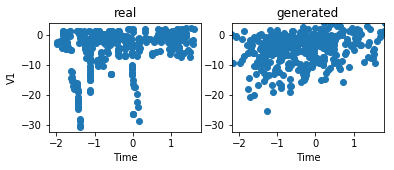

394 394
epoch: 2040, Accuracy: 0.8426395939086294
[2040/5001]	Loss_D: -0.0468	Loss_G: -0.0394	


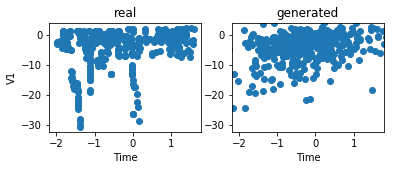

394 394
epoch: 2050, Accuracy: 0.8248730964467005
[2050/5001]	Loss_D: -0.0586	Loss_G: -0.0796	


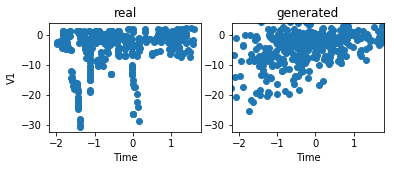

394 394
epoch: 2060, Accuracy: 0.817258883248731
[2060/5001]	Loss_D: -0.0189	Loss_G: 0.0807	


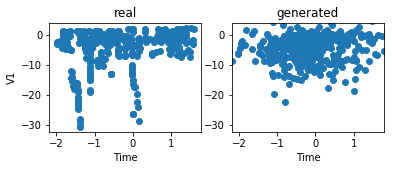

394 394
epoch: 2070, Accuracy: 0.9010152284263959
[2070/5001]	Loss_D: -0.0556	Loss_G: -0.0060	


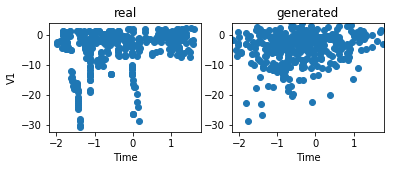

394 394
epoch: 2080, Accuracy: 0.8401015228426396
[2080/5001]	Loss_D: -0.0545	Loss_G: -0.0290	


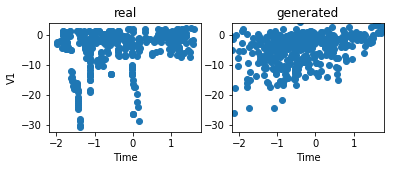

394 394
epoch: 2090, Accuracy: 0.8654822335025381
[2090/5001]	Loss_D: -0.0786	Loss_G: 0.0603	


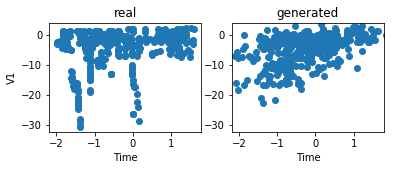

394 394
epoch: 2100, Accuracy: 0.8756345177664975
[2100/5001]	Loss_D: -0.0791	Loss_G: 0.0322	


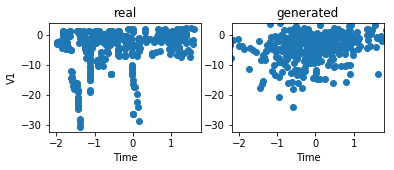

394 394
epoch: 2110, Accuracy: 0.8807106598984772
[2110/5001]	Loss_D: -0.0736	Loss_G: -0.1041	


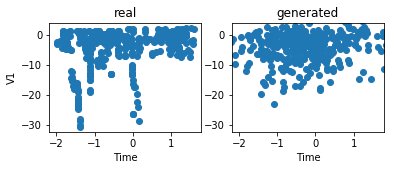

394 394
epoch: 2120, Accuracy: 0.8477157360406091
[2120/5001]	Loss_D: -0.0590	Loss_G: -0.0567	


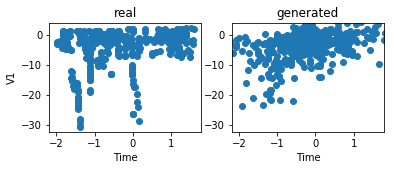

394 394
epoch: 2130, Accuracy: 0.8730964467005076
[2130/5001]	Loss_D: -0.0470	Loss_G: 0.0481	


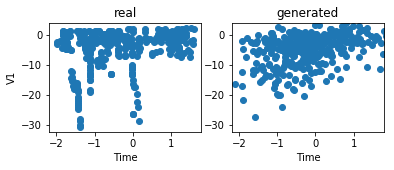

394 394
epoch: 2140, Accuracy: 0.8705583756345178
[2140/5001]	Loss_D: -0.0685	Loss_G: -0.0261	


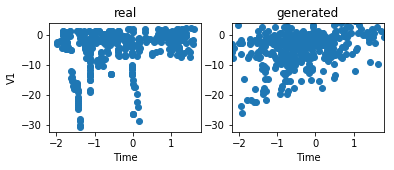

394 394
epoch: 2150, Accuracy: 0.8984771573604061
[2150/5001]	Loss_D: -0.0346	Loss_G: -0.1141	


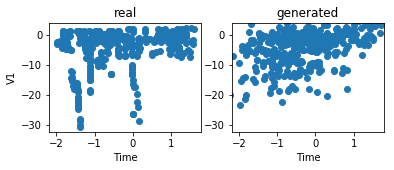

394 394
epoch: 2160, Accuracy: 0.9035532994923858
[2160/5001]	Loss_D: -0.0399	Loss_G: -0.0544	


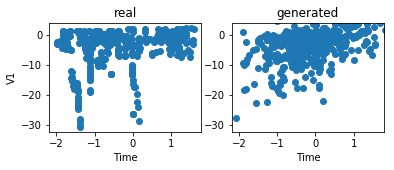

394 394
epoch: 2170, Accuracy: 0.8604060913705583
[2170/5001]	Loss_D: -0.0387	Loss_G: 0.0100	


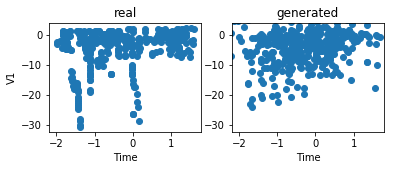

394 394
epoch: 2180, Accuracy: 0.850253807106599
[2180/5001]	Loss_D: -0.0365	Loss_G: -0.0665	


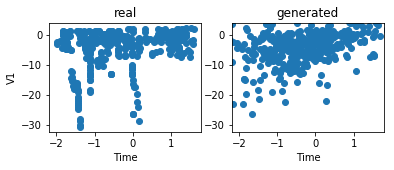

394 394
epoch: 2190, Accuracy: 0.8984771573604061
[2190/5001]	Loss_D: -0.0365	Loss_G: -0.0817	


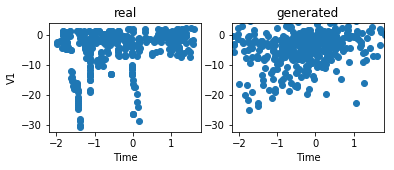

394 394
epoch: 2200, Accuracy: 0.8705583756345178
[2200/5001]	Loss_D: -0.0392	Loss_G: -0.3715	


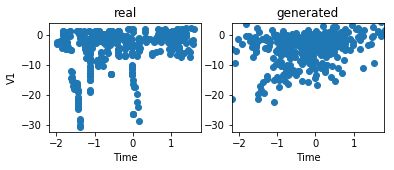

394 394
epoch: 2210, Accuracy: 0.8375634517766497
[2210/5001]	Loss_D: -0.0435	Loss_G: 0.1658	


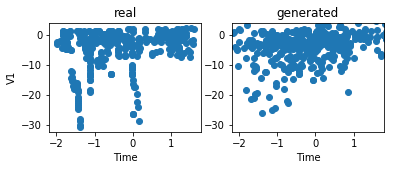

394 394
epoch: 2220, Accuracy: 0.8401015228426396
[2220/5001]	Loss_D: -0.0182	Loss_G: 0.3303	


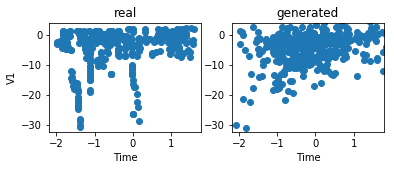

394 394
epoch: 2230, Accuracy: 0.8350253807106599
[2230/5001]	Loss_D: -0.0452	Loss_G: -0.0856	


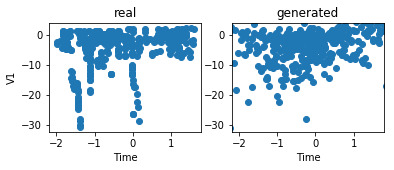

394 394
epoch: 2240, Accuracy: 0.868020304568528
[2240/5001]	Loss_D: -0.0348	Loss_G: 0.0078	


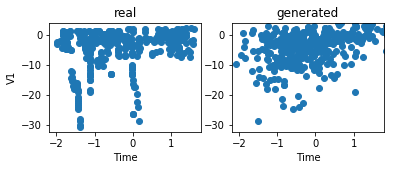

394 394
epoch: 2250, Accuracy: 0.8756345177664975
[2250/5001]	Loss_D: -0.0391	Loss_G: -0.0992	


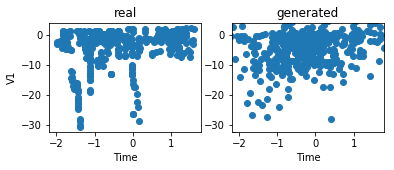

394 394
epoch: 2260, Accuracy: 0.8756345177664975
[2260/5001]	Loss_D: -0.0333	Loss_G: -0.1515	


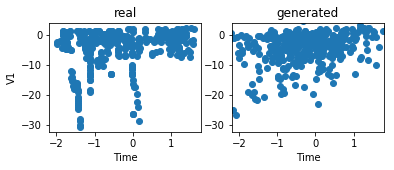

394 394
epoch: 2270, Accuracy: 0.8350253807106599
[2270/5001]	Loss_D: -0.0368	Loss_G: -0.0501	


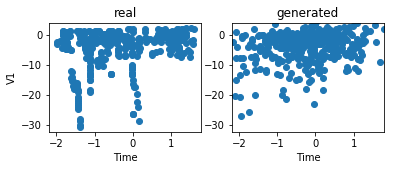

394 394
epoch: 2280, Accuracy: 0.8527918781725888
[2280/5001]	Loss_D: -0.0477	Loss_G: -0.0412	


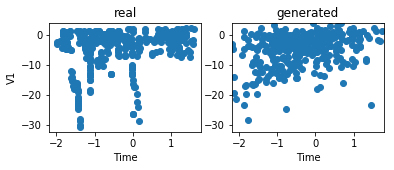

394 394
epoch: 2290, Accuracy: 0.8477157360406091
[2290/5001]	Loss_D: -0.0634	Loss_G: 0.1732	


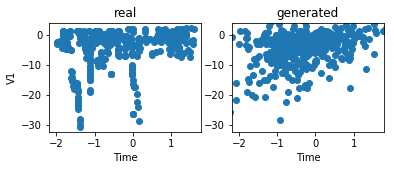

394 394
epoch: 2300, Accuracy: 0.8604060913705583
[2300/5001]	Loss_D: -0.0358	Loss_G: -0.0459	


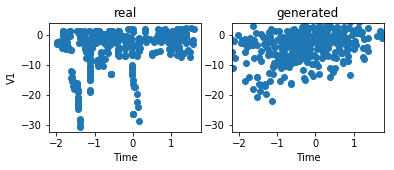

394 394
epoch: 2310, Accuracy: 0.8629441624365483
[2310/5001]	Loss_D: -0.0372	Loss_G: 0.1055	


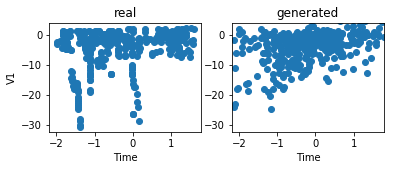

394 394
epoch: 2320, Accuracy: 0.8401015228426396
[2320/5001]	Loss_D: -0.0470	Loss_G: 0.1352	


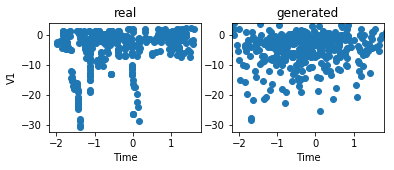

394 394
epoch: 2330, Accuracy: 0.8553299492385786
[2330/5001]	Loss_D: -0.0045	Loss_G: -0.0174	


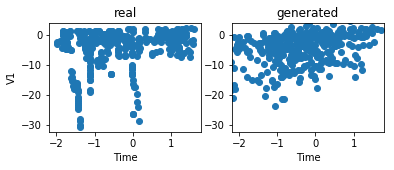

394 394
epoch: 2340, Accuracy: 0.8654822335025381
[2340/5001]	Loss_D: -0.0554	Loss_G: 0.4198	


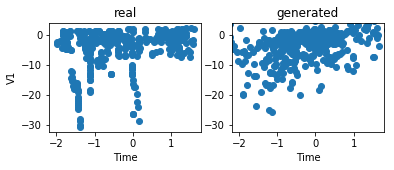

394 394
epoch: 2350, Accuracy: 0.8908629441624365
[2350/5001]	Loss_D: 0.0036	Loss_G: -0.0183	


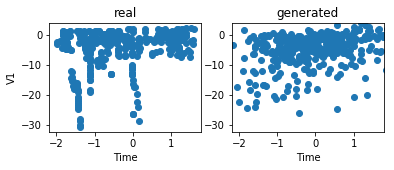

394 394
epoch: 2360, Accuracy: 0.8629441624365483
[2360/5001]	Loss_D: -0.0335	Loss_G: -0.0681	


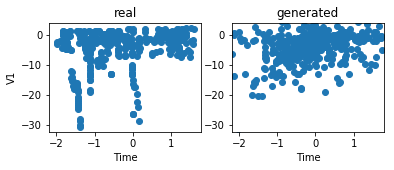

394 394
epoch: 2370, Accuracy: 0.868020304568528
[2370/5001]	Loss_D: -0.0113	Loss_G: -0.6145	


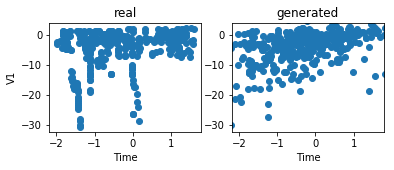

394 394
epoch: 2380, Accuracy: 0.8756345177664975
[2380/5001]	Loss_D: -0.0092	Loss_G: -0.2287	


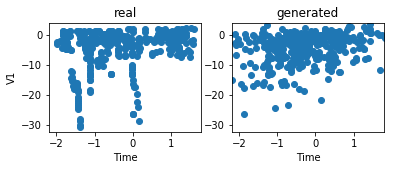

394 394
epoch: 2390, Accuracy: 0.8807106598984772
[2390/5001]	Loss_D: -0.0014	Loss_G: -0.0646	


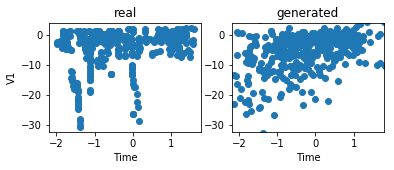

394 394
epoch: 2400, Accuracy: 0.8604060913705583
[2400/5001]	Loss_D: -0.0440	Loss_G: -0.2487	


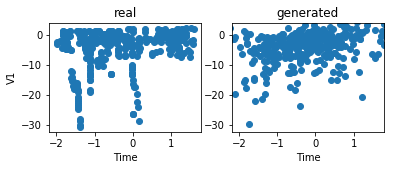

394 394
epoch: 2410, Accuracy: 0.8756345177664975
[2410/5001]	Loss_D: -0.0529	Loss_G: -0.1159	


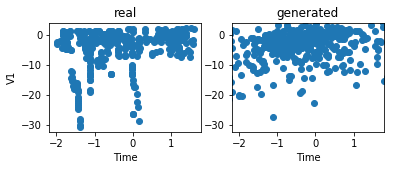

394 394
epoch: 2420, Accuracy: 0.8451776649746193
[2420/5001]	Loss_D: -0.0456	Loss_G: -0.2033	


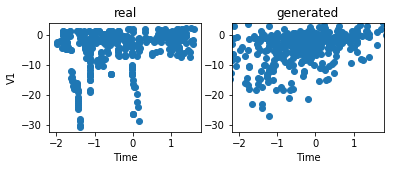

394 394
epoch: 2430, Accuracy: 0.8604060913705583
[2430/5001]	Loss_D: 0.0049	Loss_G: 0.2011	


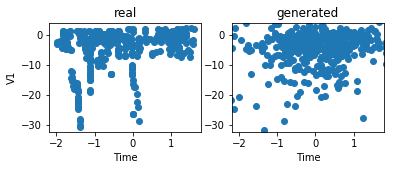

394 394
epoch: 2440, Accuracy: 0.9060913705583756
[2440/5001]	Loss_D: -0.0202	Loss_G: -0.1613	


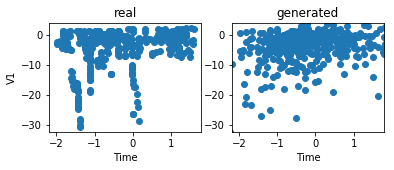

394 394
epoch: 2450, Accuracy: 0.8451776649746193
[2450/5001]	Loss_D: -0.0213	Loss_G: -0.1260	


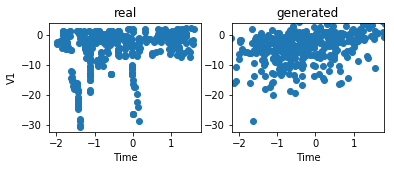

394 394
epoch: 2460, Accuracy: 0.8781725888324873
[2460/5001]	Loss_D: -0.0244	Loss_G: 0.2095	


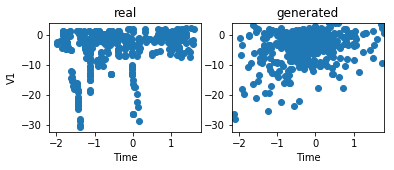

394 394
epoch: 2470, Accuracy: 0.8553299492385786
[2470/5001]	Loss_D: 0.0072	Loss_G: 0.4913	


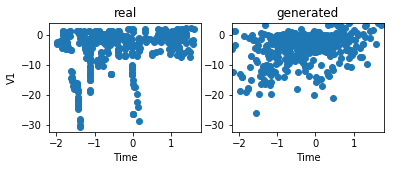

394 394
epoch: 2480, Accuracy: 0.8654822335025381
[2480/5001]	Loss_D: -0.0308	Loss_G: -0.5126	


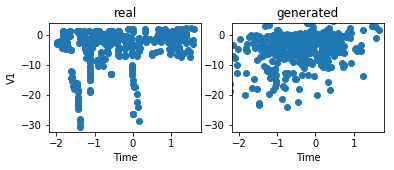

394 394
epoch: 2490, Accuracy: 0.8883248730964467
[2490/5001]	Loss_D: -0.0288	Loss_G: 0.2908	


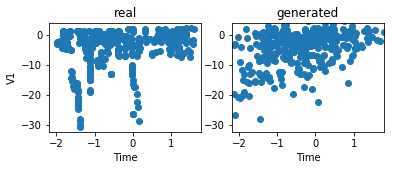

394 394
epoch: 2500, Accuracy: 0.8375634517766497
[2500/5001]	Loss_D: 0.0001	Loss_G: -0.0995	


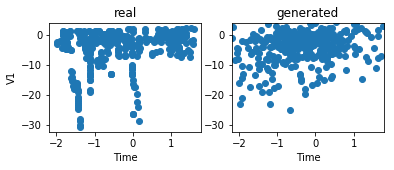

394 394
epoch: 2510, Accuracy: 0.8451776649746193
[2510/5001]	Loss_D: 0.0005	Loss_G: 0.5478	


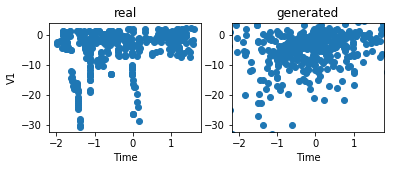

394 394
epoch: 2520, Accuracy: 0.8401015228426396
[2520/5001]	Loss_D: -0.0720	Loss_G: -0.5185	


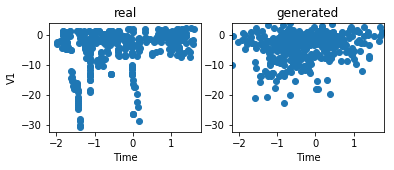

394 394
epoch: 2530, Accuracy: 0.8578680203045685
[2530/5001]	Loss_D: -0.0056	Loss_G: -0.2363	


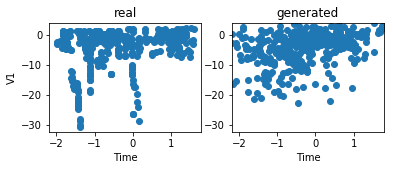

394 394
epoch: 2540, Accuracy: 0.8527918781725888
[2540/5001]	Loss_D: -0.0535	Loss_G: -0.3335	


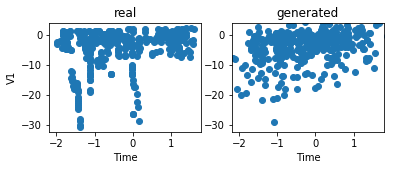

394 394
epoch: 2550, Accuracy: 0.8578680203045685
[2550/5001]	Loss_D: -0.1084	Loss_G: -0.6628	


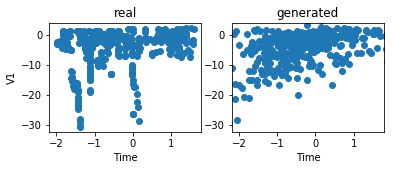

394 394
epoch: 2560, Accuracy: 0.8756345177664975
[2560/5001]	Loss_D: -0.0434	Loss_G: -0.5200	


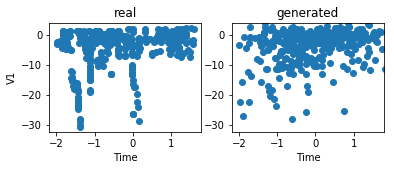

394 394
epoch: 2570, Accuracy: 0.8451776649746193
[2570/5001]	Loss_D: -0.1032	Loss_G: 0.8099	


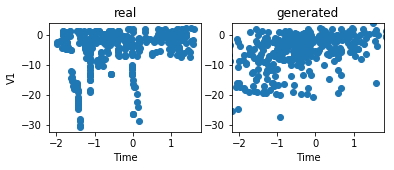

394 394
epoch: 2580, Accuracy: 0.868020304568528
[2580/5001]	Loss_D: -0.0120	Loss_G: -0.0869	


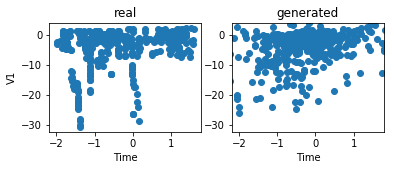

394 394
epoch: 2590, Accuracy: 0.8629441624365483
[2590/5001]	Loss_D: -0.0149	Loss_G: -0.0574	


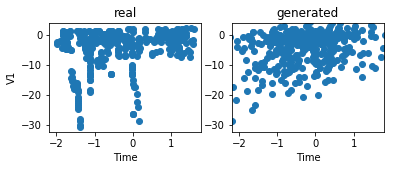

394 394
epoch: 2600, Accuracy: 0.8807106598984772
[2600/5001]	Loss_D: -0.0066	Loss_G: 0.5652	


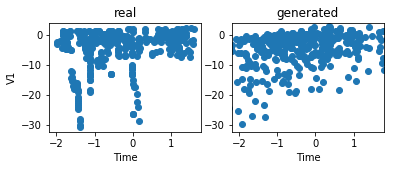

394 394
epoch: 2610, Accuracy: 0.8578680203045685
[2610/5001]	Loss_D: -0.0610	Loss_G: 0.7158	


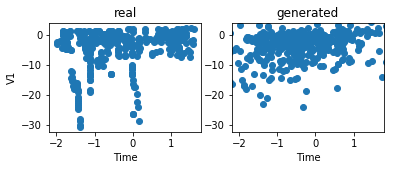

394 394
epoch: 2620, Accuracy: 0.8477157360406091
[2620/5001]	Loss_D: -0.0002	Loss_G: 0.2575	


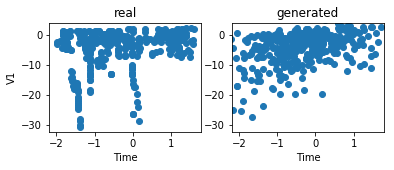

394 394
epoch: 2630, Accuracy: 0.8654822335025381
[2630/5001]	Loss_D: 0.0047	Loss_G: 0.0389	


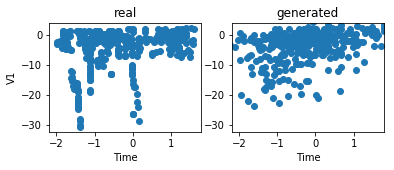

394 394
epoch: 2640, Accuracy: 0.8781725888324873
[2640/5001]	Loss_D: -0.0060	Loss_G: -0.0091	


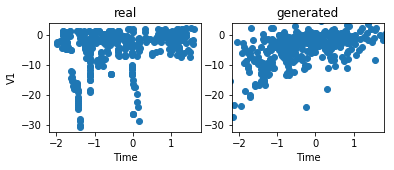

394 394
epoch: 2650, Accuracy: 0.8451776649746193
[2650/5001]	Loss_D: -0.0164	Loss_G: 0.0910	


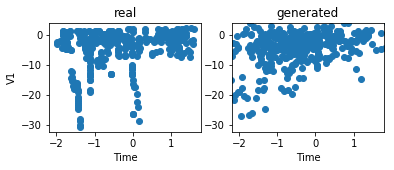

394 394
epoch: 2660, Accuracy: 0.8781725888324873
[2660/5001]	Loss_D: -0.0098	Loss_G: -0.0518	


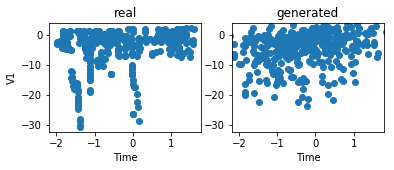

394 394
epoch: 2670, Accuracy: 0.8451776649746193
[2670/5001]	Loss_D: -0.0244	Loss_G: 0.1048	


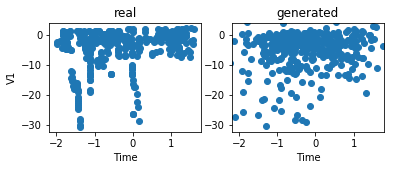

394 394
epoch: 2680, Accuracy: 0.883248730964467
[2680/5001]	Loss_D: -0.0086	Loss_G: -0.0197	


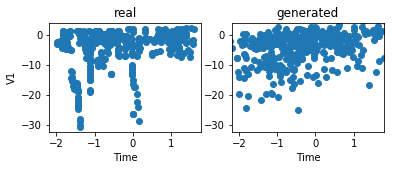

394 394
epoch: 2690, Accuracy: 0.8477157360406091
[2690/5001]	Loss_D: -0.0276	Loss_G: -0.2538	


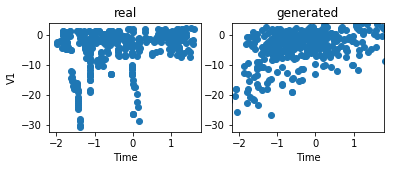

394 394
epoch: 2700, Accuracy: 0.8553299492385786
[2700/5001]	Loss_D: -0.0214	Loss_G: -0.0810	


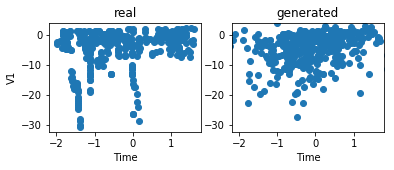

394 394
epoch: 2710, Accuracy: 0.8274111675126904
[2710/5001]	Loss_D: -0.0326	Loss_G: 0.3288	


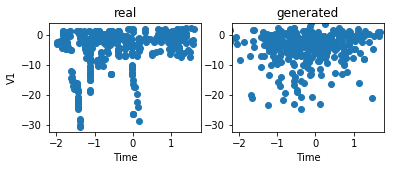

394 394
epoch: 2720, Accuracy: 0.8274111675126904
[2720/5001]	Loss_D: -0.0204	Loss_G: 0.2527	


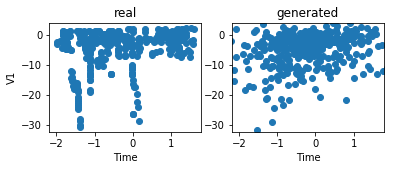

394 394
epoch: 2730, Accuracy: 0.8553299492385786
[2730/5001]	Loss_D: -0.0193	Loss_G: -0.0162	


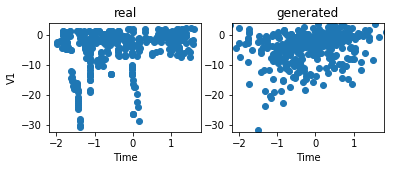

394 394
epoch: 2740, Accuracy: 0.8527918781725888
[2740/5001]	Loss_D: -0.0253	Loss_G: -0.1507	


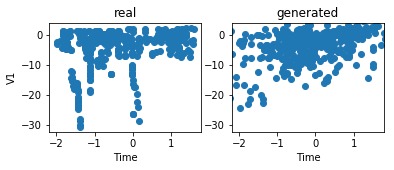

394 394
epoch: 2750, Accuracy: 0.8807106598984772
[2750/5001]	Loss_D: -0.0150	Loss_G: -0.1343	


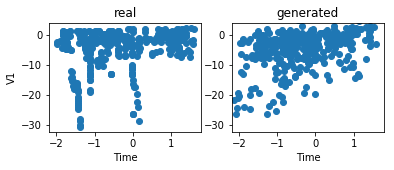

394 394
epoch: 2760, Accuracy: 0.8654822335025381
[2760/5001]	Loss_D: -0.0135	Loss_G: -0.0481	


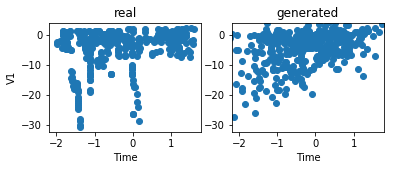

394 394
epoch: 2770, Accuracy: 0.8705583756345178
[2770/5001]	Loss_D: -0.0080	Loss_G: -0.1602	


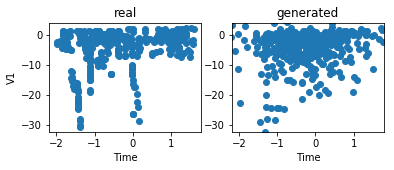

394 394
epoch: 2780, Accuracy: 0.8604060913705583
[2780/5001]	Loss_D: -0.0177	Loss_G: 0.0108	


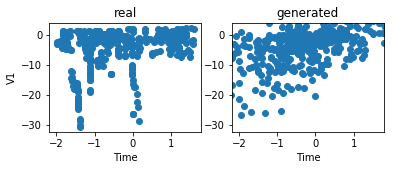

394 394
epoch: 2790, Accuracy: 0.8934010152284264
[2790/5001]	Loss_D: -0.0425	Loss_G: -0.1487	


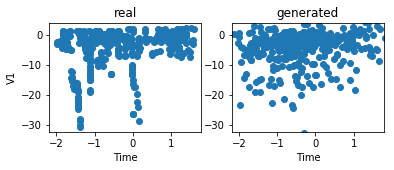

394 394
epoch: 2800, Accuracy: 0.8350253807106599
[2800/5001]	Loss_D: -0.0255	Loss_G: 0.0522	


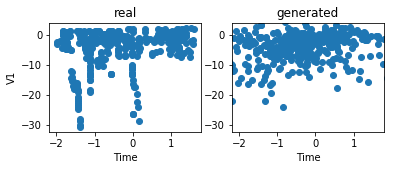

394 394
epoch: 2810, Accuracy: 0.8807106598984772
[2810/5001]	Loss_D: -0.0339	Loss_G: -0.2439	


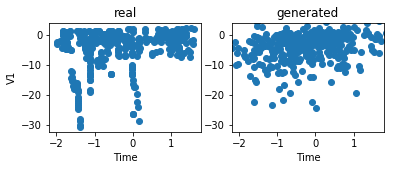

394 394
epoch: 2820, Accuracy: 0.8299492385786802
[2820/5001]	Loss_D: -0.0128	Loss_G: 0.0137	


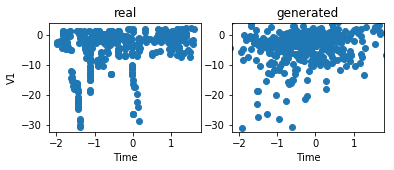

394 394
epoch: 2830, Accuracy: 0.8857868020304569
[2830/5001]	Loss_D: -0.0513	Loss_G: 0.0327	


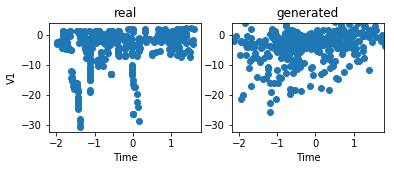

394 394
epoch: 2840, Accuracy: 0.8807106598984772
[2840/5001]	Loss_D: -0.0137	Loss_G: -0.0058	


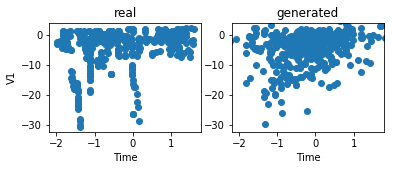

394 394
epoch: 2850, Accuracy: 0.8984771573604061
[2850/5001]	Loss_D: -0.0374	Loss_G: -0.0677	


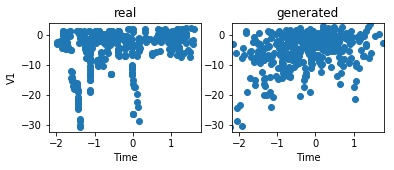

394 394
epoch: 2860, Accuracy: 0.8604060913705583
[2860/5001]	Loss_D: -0.0343	Loss_G: -0.0543	


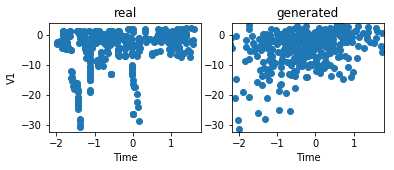

394 394
epoch: 2870, Accuracy: 0.8375634517766497
[2870/5001]	Loss_D: -0.0351	Loss_G: 0.0131	


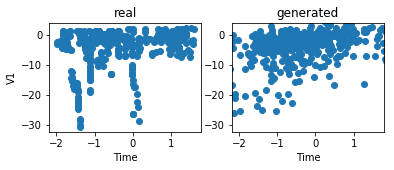

394 394
epoch: 2880, Accuracy: 0.868020304568528
[2880/5001]	Loss_D: -0.0293	Loss_G: 0.0212	


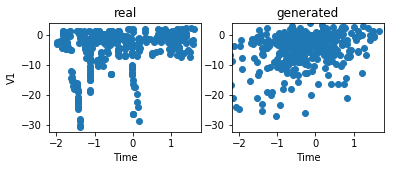

394 394
epoch: 2890, Accuracy: 0.8756345177664975
[2890/5001]	Loss_D: -0.0412	Loss_G: 0.0235	


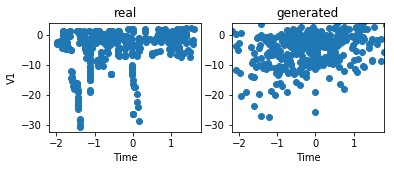

394 394
epoch: 2900, Accuracy: 0.8705583756345178
[2900/5001]	Loss_D: -0.0519	Loss_G: -0.0927	


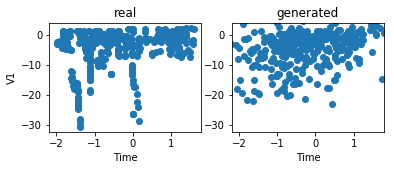

394 394
epoch: 2910, Accuracy: 0.8578680203045685
[2910/5001]	Loss_D: -0.0413	Loss_G: 0.0613	


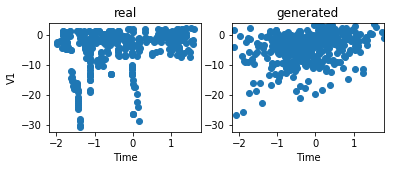

394 394
epoch: 2920, Accuracy: 0.7969543147208121
[2920/5001]	Loss_D: -0.0306	Loss_G: -0.0336	


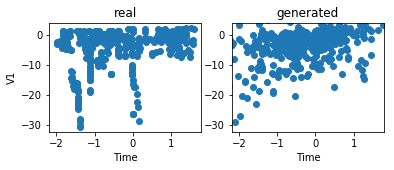

394 394
epoch: 2930, Accuracy: 0.8451776649746193
[2930/5001]	Loss_D: -0.0298	Loss_G: -0.0377	


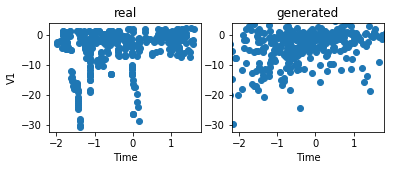

394 394
epoch: 2940, Accuracy: 0.850253807106599
[2940/5001]	Loss_D: -0.0132	Loss_G: -0.2078	


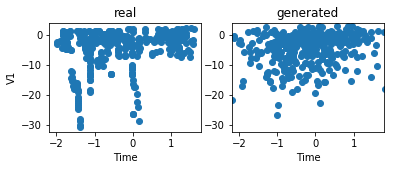

394 394
epoch: 2950, Accuracy: 0.8756345177664975
[2950/5001]	Loss_D: -0.0063	Loss_G: 0.1926	


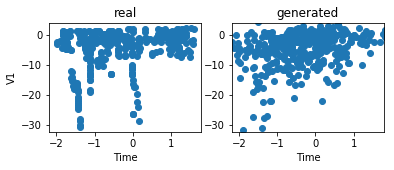

394 394
epoch: 2960, Accuracy: 0.8604060913705583
[2960/5001]	Loss_D: -0.0655	Loss_G: -0.0197	


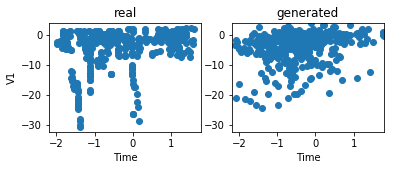

394 394
epoch: 2970, Accuracy: 0.8426395939086294
[2970/5001]	Loss_D: -0.0076	Loss_G: 0.0884	


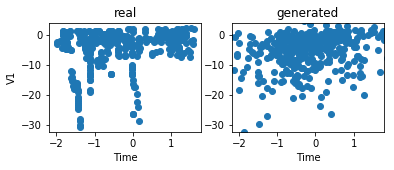

394 394
epoch: 2980, Accuracy: 0.8375634517766497
[2980/5001]	Loss_D: -0.0361	Loss_G: -0.1259	


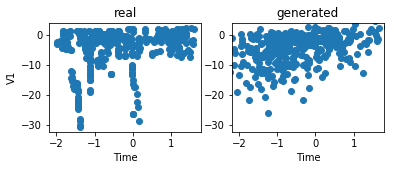

394 394
epoch: 2990, Accuracy: 0.8527918781725888
[2990/5001]	Loss_D: -0.0272	Loss_G: -0.1002	


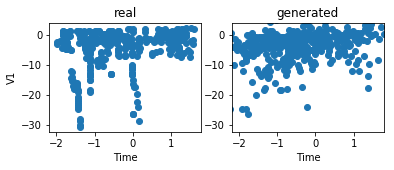

394 394
epoch: 3000, Accuracy: 0.8578680203045685
[3000/5001]	Loss_D: -0.0286	Loss_G: 0.1391	


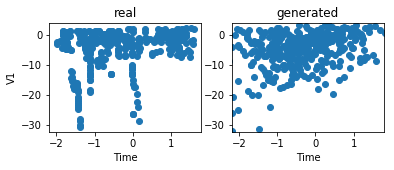

394 394
epoch: 3010, Accuracy: 0.8299492385786802
[3010/5001]	Loss_D: -0.0167	Loss_G: 0.2074	


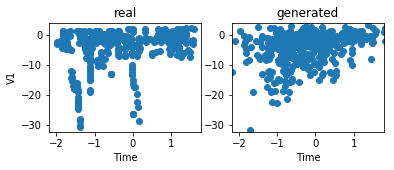

394 394
epoch: 3020, Accuracy: 0.8527918781725888
[3020/5001]	Loss_D: -0.0205	Loss_G: -0.0461	


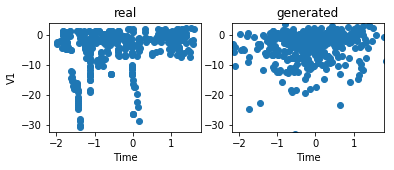

394 394
epoch: 3030, Accuracy: 0.7944162436548223
[3030/5001]	Loss_D: -0.0439	Loss_G: -0.0865	


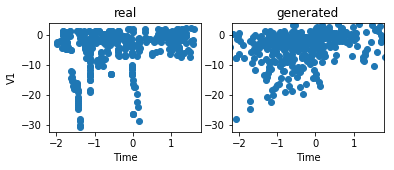

394 394
epoch: 3040, Accuracy: 0.8604060913705583
[3040/5001]	Loss_D: -0.0169	Loss_G: 0.1850	


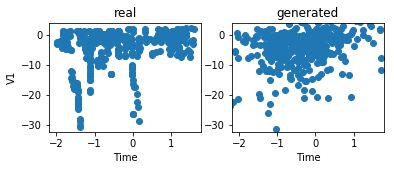

394 394
epoch: 3050, Accuracy: 0.8553299492385786
[3050/5001]	Loss_D: -0.0399	Loss_G: -0.0007	


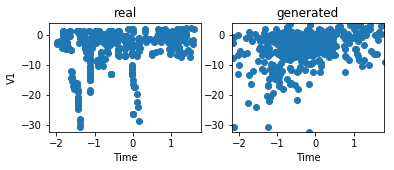

394 394
epoch: 3060, Accuracy: 0.8578680203045685
[3060/5001]	Loss_D: -0.0217	Loss_G: -0.1507	


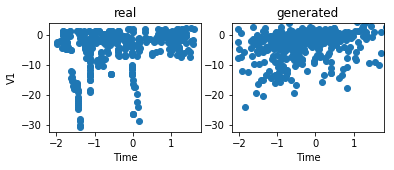

394 394
epoch: 3070, Accuracy: 0.8807106598984772
[3070/5001]	Loss_D: -0.0464	Loss_G: 0.0825	


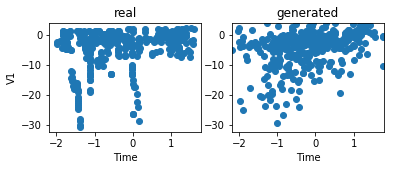

394 394
epoch: 3080, Accuracy: 0.8730964467005076
[3080/5001]	Loss_D: -0.0236	Loss_G: -0.0312	


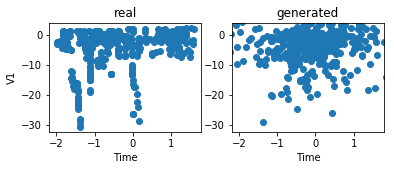

394 394
epoch: 3090, Accuracy: 0.8451776649746193
[3090/5001]	Loss_D: -0.0367	Loss_G: 0.0294	


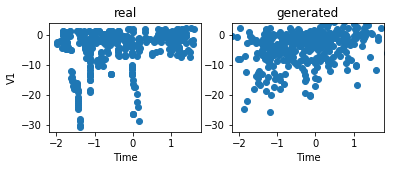

394 394
epoch: 3100, Accuracy: 0.8553299492385786
[3100/5001]	Loss_D: -0.0191	Loss_G: 0.0067	


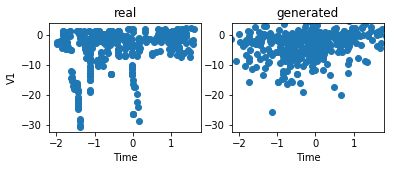

394 394
epoch: 3110, Accuracy: 0.8248730964467005
[3110/5001]	Loss_D: -0.0324	Loss_G: -0.0443	


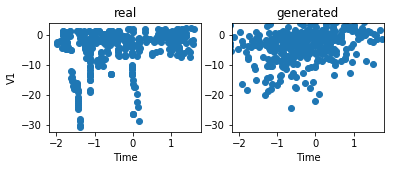

394 394
epoch: 3120, Accuracy: 0.8426395939086294
[3120/5001]	Loss_D: -0.0183	Loss_G: -0.0033	


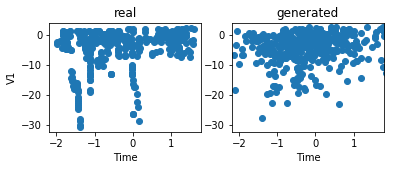

394 394
epoch: 3130, Accuracy: 0.8451776649746193
[3130/5001]	Loss_D: -0.0282	Loss_G: -0.1863	


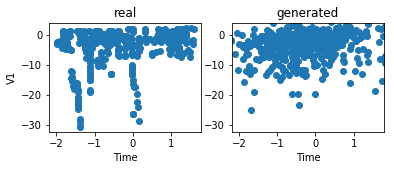

394 394
epoch: 3140, Accuracy: 0.8604060913705583
[3140/5001]	Loss_D: -0.0186	Loss_G: -0.0426	


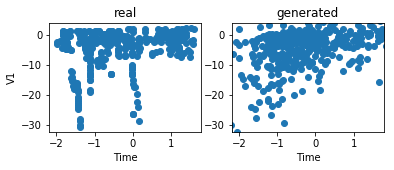

394 394
epoch: 3150, Accuracy: 0.868020304568528
[3150/5001]	Loss_D: -0.0391	Loss_G: 0.2029	


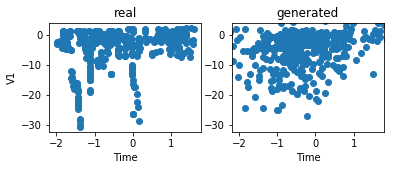

394 394
epoch: 3160, Accuracy: 0.8299492385786802
[3160/5001]	Loss_D: -0.0282	Loss_G: -0.0165	


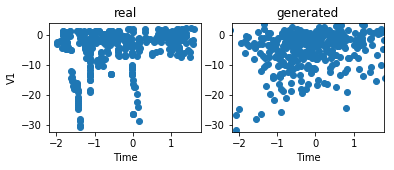

394 394
epoch: 3170, Accuracy: 0.7944162436548223
[3170/5001]	Loss_D: -0.0362	Loss_G: -0.0552	


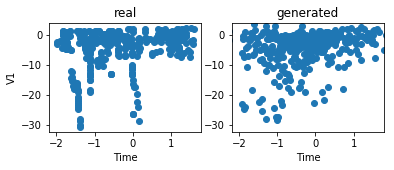

394 394
epoch: 3180, Accuracy: 0.8705583756345178
[3180/5001]	Loss_D: -0.0509	Loss_G: -0.1583	


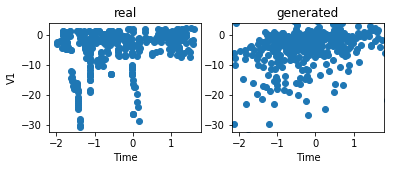

394 394
epoch: 3190, Accuracy: 0.8654822335025381
[3190/5001]	Loss_D: -0.0686	Loss_G: 0.0915	


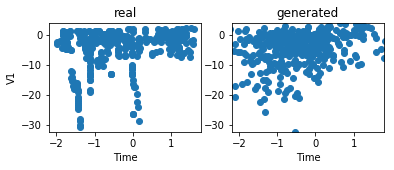

394 394
epoch: 3200, Accuracy: 0.8756345177664975
[3200/5001]	Loss_D: -0.0110	Loss_G: 0.1190	


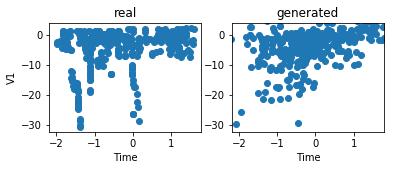

394 394
epoch: 3210, Accuracy: 0.8096446700507615
[3210/5001]	Loss_D: -0.0116	Loss_G: -0.1190	


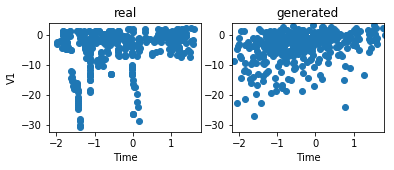

394 394
epoch: 3220, Accuracy: 0.8654822335025381
[3220/5001]	Loss_D: -0.0162	Loss_G: -0.0485	


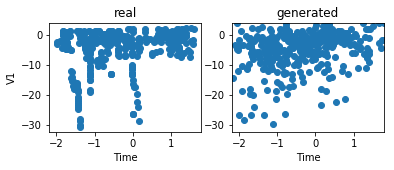

394 394
epoch: 3230, Accuracy: 0.8756345177664975
[3230/5001]	Loss_D: -0.0363	Loss_G: 0.0748	


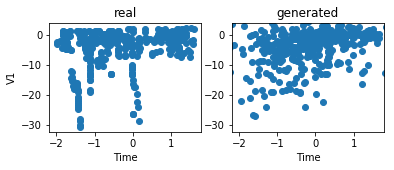

394 394
epoch: 3240, Accuracy: 0.868020304568528
[3240/5001]	Loss_D: -0.0088	Loss_G: 0.1383	


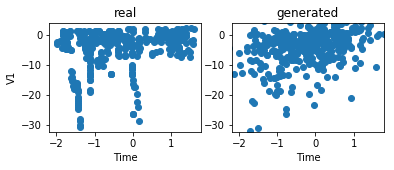

394 394
epoch: 3250, Accuracy: 0.8451776649746193
[3250/5001]	Loss_D: -0.0149	Loss_G: -0.0767	


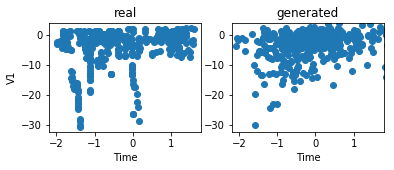

394 394
epoch: 3260, Accuracy: 0.8756345177664975
[3260/5001]	Loss_D: -0.0051	Loss_G: 0.4271	


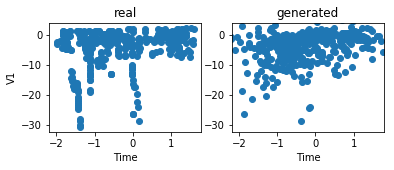

394 394
epoch: 3270, Accuracy: 0.8401015228426396
[3270/5001]	Loss_D: -0.0055	Loss_G: 0.0661	


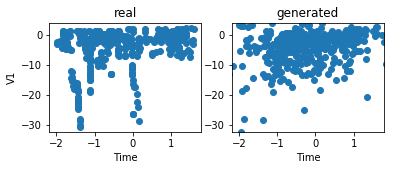

394 394
epoch: 3280, Accuracy: 0.8527918781725888
[3280/5001]	Loss_D: -0.0248	Loss_G: -0.0625	


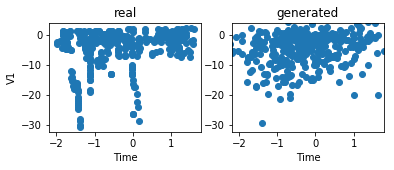

394 394
epoch: 3290, Accuracy: 0.850253807106599
[3290/5001]	Loss_D: -0.0452	Loss_G: 0.2917	


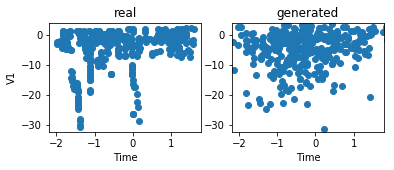

394 394
epoch: 3300, Accuracy: 0.8553299492385786
[3300/5001]	Loss_D: -0.0038	Loss_G: 0.3098	


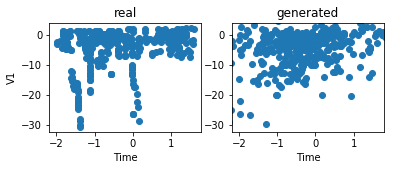

394 394
epoch: 3310, Accuracy: 0.8375634517766497
[3310/5001]	Loss_D: -0.0009	Loss_G: 0.0923	


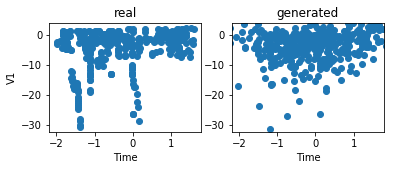

394 394
epoch: 3320, Accuracy: 0.8426395939086294
[3320/5001]	Loss_D: -0.0189	Loss_G: 0.2966	


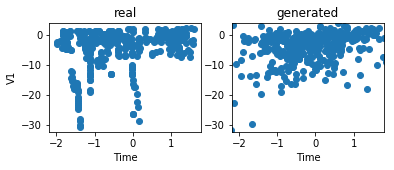

394 394
epoch: 3330, Accuracy: 0.8477157360406091
[3330/5001]	Loss_D: -0.0081	Loss_G: 0.0937	


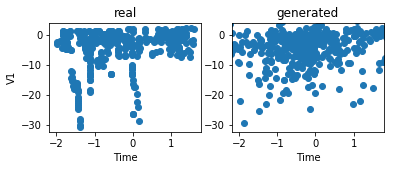

394 394
epoch: 3340, Accuracy: 0.8426395939086294
[3340/5001]	Loss_D: -0.0353	Loss_G: 0.0520	


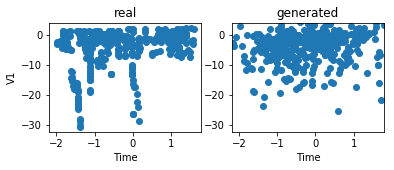

394 394
epoch: 3350, Accuracy: 0.8121827411167513
[3350/5001]	Loss_D: -0.0393	Loss_G: 0.2540	


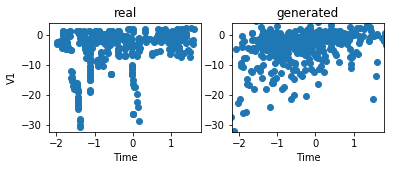

394 394
epoch: 3360, Accuracy: 0.8477157360406091
[3360/5001]	Loss_D: -0.0392	Loss_G: -0.1151	


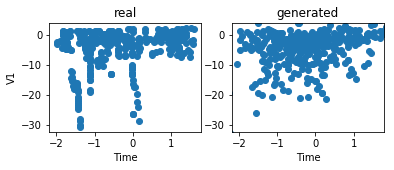

394 394
epoch: 3370, Accuracy: 0.8121827411167513
[3370/5001]	Loss_D: -0.0150	Loss_G: -0.1186	


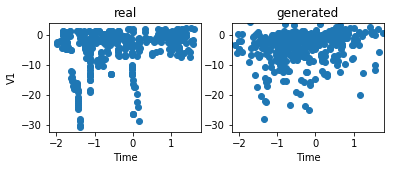

394 394
epoch: 3380, Accuracy: 0.8654822335025381
[3380/5001]	Loss_D: -0.0229	Loss_G: -0.1015	


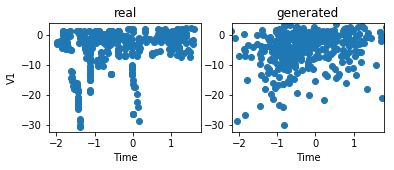

394 394
epoch: 3390, Accuracy: 0.850253807106599
[3390/5001]	Loss_D: -0.0115	Loss_G: 0.0191	


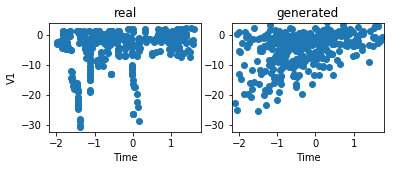

394 394
epoch: 3400, Accuracy: 0.850253807106599
[3400/5001]	Loss_D: -0.0236	Loss_G: 0.2478	


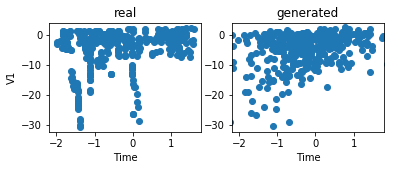

394 394
epoch: 3410, Accuracy: 0.883248730964467
[3410/5001]	Loss_D: -0.0390	Loss_G: -0.0510	


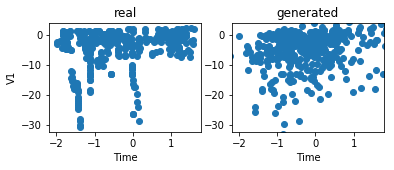

394 394
epoch: 3420, Accuracy: 0.8553299492385786
[3420/5001]	Loss_D: 0.0026	Loss_G: 0.0790	


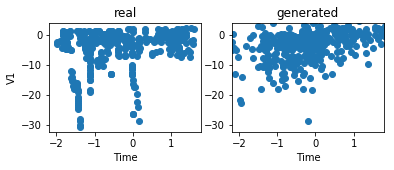

394 394
epoch: 3430, Accuracy: 0.8375634517766497
[3430/5001]	Loss_D: -0.0513	Loss_G: -0.4030	


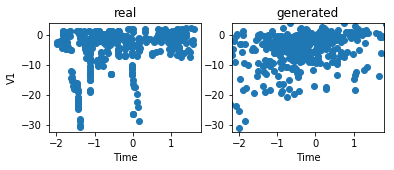

394 394
epoch: 3440, Accuracy: 0.8553299492385786
[3440/5001]	Loss_D: -0.0604	Loss_G: 0.4589	


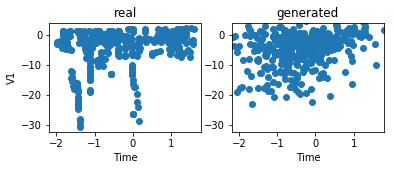

394 394
epoch: 3450, Accuracy: 0.8426395939086294
[3450/5001]	Loss_D: -0.0093	Loss_G: 0.0750	


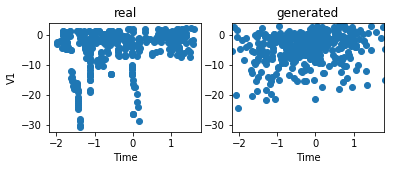

394 394
epoch: 3460, Accuracy: 0.8553299492385786
[3460/5001]	Loss_D: -0.0004	Loss_G: 0.0345	


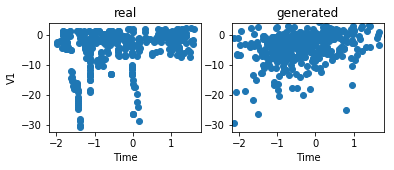

394 394
epoch: 3470, Accuracy: 0.8553299492385786
[3470/5001]	Loss_D: 0.0129	Loss_G: 0.1058	


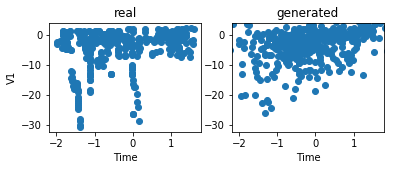

394 394
epoch: 3480, Accuracy: 0.8401015228426396
[3480/5001]	Loss_D: -0.0133	Loss_G: 0.0949	


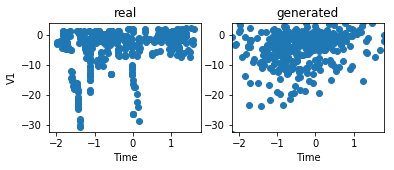

394 394
epoch: 3490, Accuracy: 0.8527918781725888
[3490/5001]	Loss_D: -0.0146	Loss_G: -0.0242	


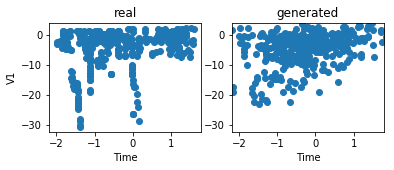

394 394
epoch: 3500, Accuracy: 0.850253807106599
[3500/5001]	Loss_D: -0.0302	Loss_G: -0.1135	


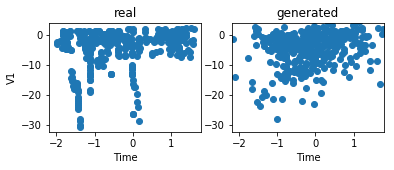

394 394
epoch: 3510, Accuracy: 0.8756345177664975
[3510/5001]	Loss_D: 0.0157	Loss_G: 0.1337	


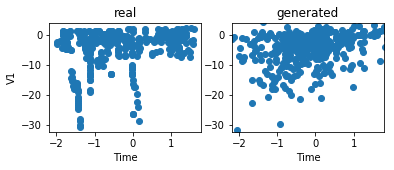

394 394
epoch: 3520, Accuracy: 0.8223350253807107
[3520/5001]	Loss_D: -0.0226	Loss_G: 0.1907	


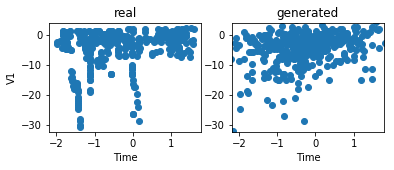

394 394
epoch: 3530, Accuracy: 0.7969543147208121
[3530/5001]	Loss_D: 0.0162	Loss_G: 0.3235	


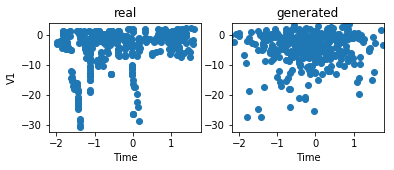

394 394
epoch: 3540, Accuracy: 0.8299492385786802
[3540/5001]	Loss_D: -0.0230	Loss_G: -0.0929	


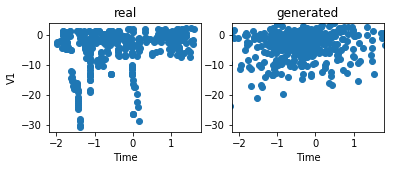

394 394
epoch: 3550, Accuracy: 0.8401015228426396
[3550/5001]	Loss_D: -0.0170	Loss_G: -0.2087	


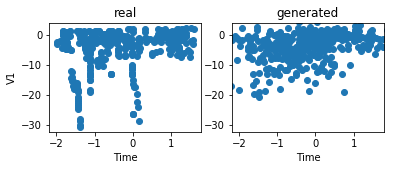

394 394
epoch: 3560, Accuracy: 0.8197969543147208
[3560/5001]	Loss_D: -0.0194	Loss_G: 0.5112	


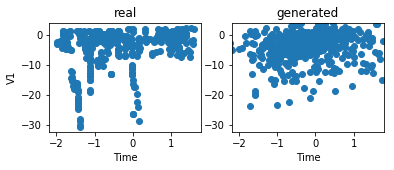

394 394
epoch: 3570, Accuracy: 0.817258883248731
[3570/5001]	Loss_D: -0.0113	Loss_G: -0.1852	


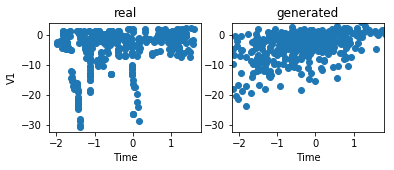

394 394
epoch: 3580, Accuracy: 0.8248730964467005
[3580/5001]	Loss_D: -0.0044	Loss_G: 0.0901	


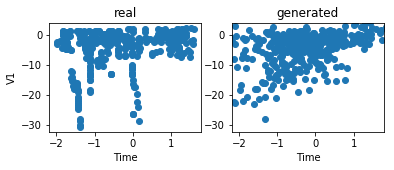

394 394
epoch: 3590, Accuracy: 0.8604060913705583
[3590/5001]	Loss_D: -0.0289	Loss_G: -0.1372	


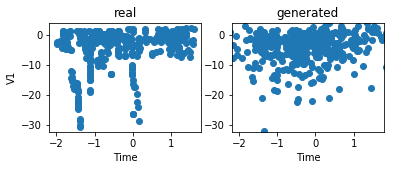

394 394
epoch: 3600, Accuracy: 0.8604060913705583
[3600/5001]	Loss_D: -0.0198	Loss_G: 0.1001	


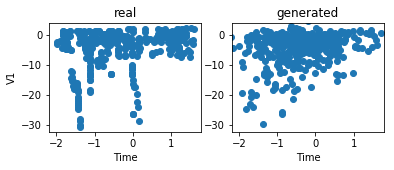

394 394
epoch: 3610, Accuracy: 0.8527918781725888
[3610/5001]	Loss_D: -0.0109	Loss_G: -0.0376	


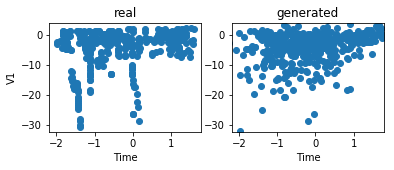

394 394
epoch: 3620, Accuracy: 0.8274111675126904
[3620/5001]	Loss_D: -0.0534	Loss_G: 0.3400	


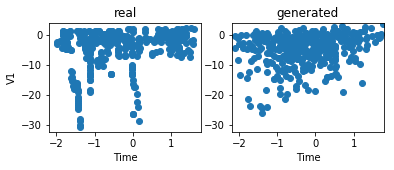

394 394
epoch: 3630, Accuracy: 0.8248730964467005
[3630/5001]	Loss_D: 0.0108	Loss_G: 0.4389	


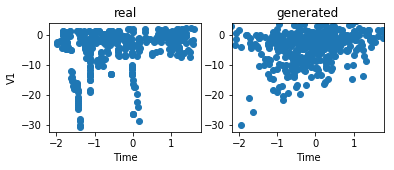

394 394
epoch: 3640, Accuracy: 0.8274111675126904
[3640/5001]	Loss_D: 0.0065	Loss_G: 0.0909	


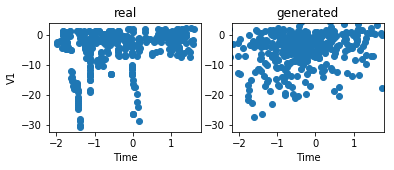

394 394
epoch: 3650, Accuracy: 0.8324873096446701
[3650/5001]	Loss_D: -0.0102	Loss_G: -0.0921	


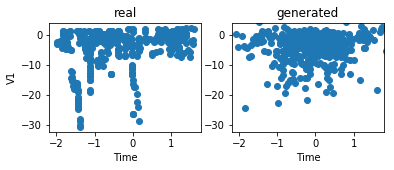

394 394
epoch: 3660, Accuracy: 0.8553299492385786
[3660/5001]	Loss_D: -0.0070	Loss_G: -0.1907	


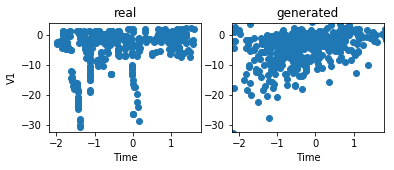

394 394
epoch: 3670, Accuracy: 0.8045685279187818
[3670/5001]	Loss_D: -0.0164	Loss_G: -0.0354	


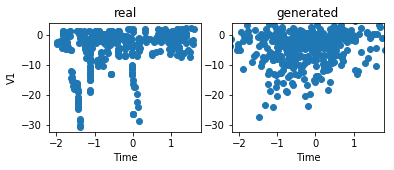

394 394
epoch: 3680, Accuracy: 0.8426395939086294
[3680/5001]	Loss_D: -0.0409	Loss_G: -0.1939	


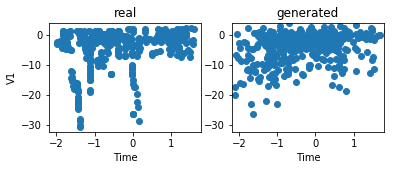

394 394
epoch: 3690, Accuracy: 0.850253807106599
[3690/5001]	Loss_D: -0.0307	Loss_G: 0.0581	


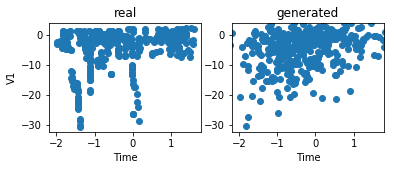

394 394
epoch: 3700, Accuracy: 0.8350253807106599
[3700/5001]	Loss_D: -0.0325	Loss_G: -0.3260	


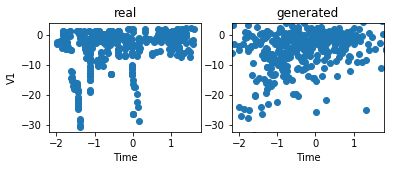

394 394
epoch: 3710, Accuracy: 0.8350253807106599
[3710/5001]	Loss_D: -0.0226	Loss_G: 0.1042	


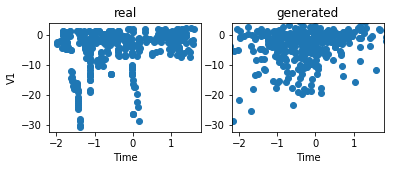

394 394
epoch: 3720, Accuracy: 0.8604060913705583
[3720/5001]	Loss_D: -0.0293	Loss_G: -0.1449	


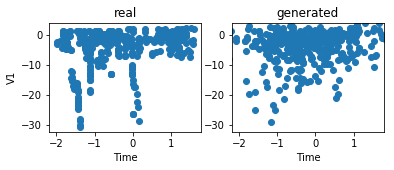

394 394
epoch: 3730, Accuracy: 0.8248730964467005
[3730/5001]	Loss_D: -0.0464	Loss_G: -0.0613	


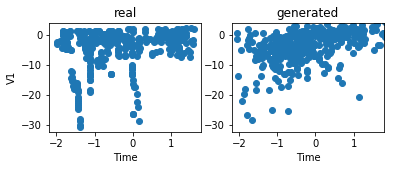

394 394
epoch: 3740, Accuracy: 0.8756345177664975
[3740/5001]	Loss_D: -0.0260	Loss_G: -0.1154	


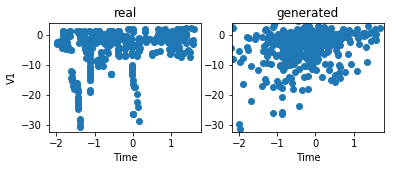

394 394
epoch: 3750, Accuracy: 0.8045685279187818
[3750/5001]	Loss_D: -0.0254	Loss_G: -0.0856	


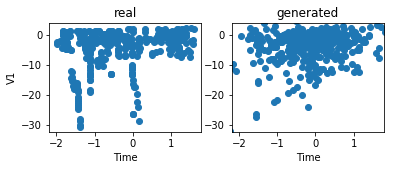

394 394
epoch: 3760, Accuracy: 0.799492385786802
[3760/5001]	Loss_D: -0.0282	Loss_G: -0.2715	


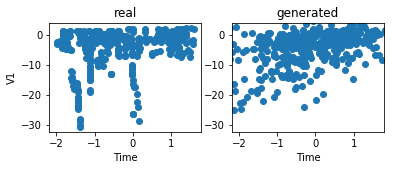

394 394
epoch: 3770, Accuracy: 0.8299492385786802
[3770/5001]	Loss_D: -0.0392	Loss_G: -0.4521	


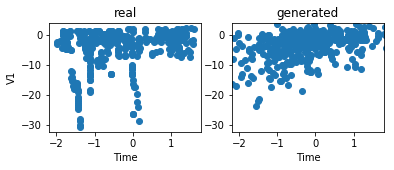

394 394
epoch: 3780, Accuracy: 0.850253807106599
[3780/5001]	Loss_D: -0.0228	Loss_G: -0.2628	


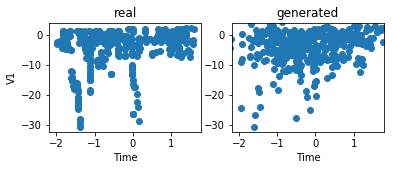

394 394
epoch: 3790, Accuracy: 0.8274111675126904
[3790/5001]	Loss_D: -0.0239	Loss_G: 0.0510	


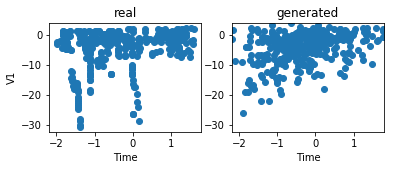

394 394
epoch: 3800, Accuracy: 0.8629441624365483
[3800/5001]	Loss_D: -0.0174	Loss_G: -0.0219	


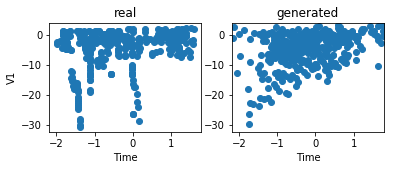

394 394
epoch: 3810, Accuracy: 0.799492385786802
[3810/5001]	Loss_D: -0.0215	Loss_G: -0.0427	


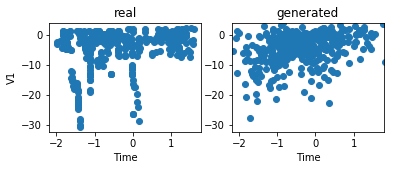

394 394
epoch: 3820, Accuracy: 0.8350253807106599
[3820/5001]	Loss_D: -0.0152	Loss_G: -0.0895	


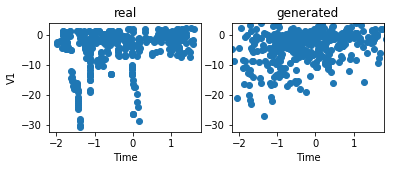

394 394
epoch: 3830, Accuracy: 0.8604060913705583
[3830/5001]	Loss_D: -0.0243	Loss_G: -0.0113	


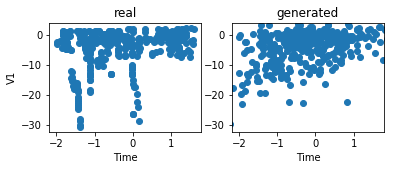

394 394
epoch: 3840, Accuracy: 0.8401015228426396
[3840/5001]	Loss_D: -0.0198	Loss_G: -0.0187	


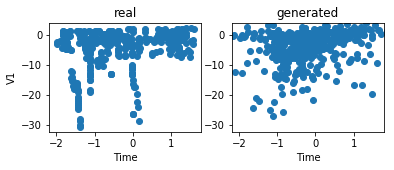

394 394
epoch: 3850, Accuracy: 0.850253807106599
[3850/5001]	Loss_D: -0.0380	Loss_G: -0.0205	


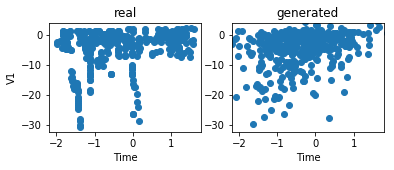

394 394
epoch: 3860, Accuracy: 0.8527918781725888
[3860/5001]	Loss_D: -0.0399	Loss_G: 0.0242	


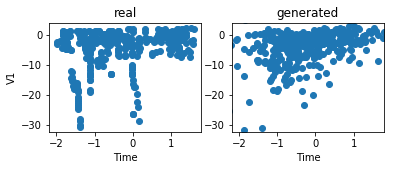

394 394
epoch: 3870, Accuracy: 0.8223350253807107
[3870/5001]	Loss_D: -0.0173	Loss_G: 0.0356	


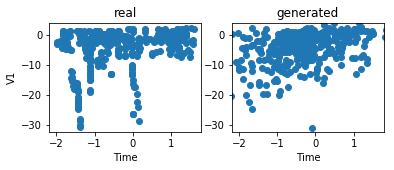

394 394
epoch: 3880, Accuracy: 0.8375634517766497
[3880/5001]	Loss_D: -0.0431	Loss_G: 0.1026	


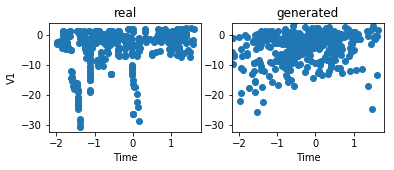

394 394
epoch: 3890, Accuracy: 0.8578680203045685
[3890/5001]	Loss_D: -0.0372	Loss_G: 0.0268	


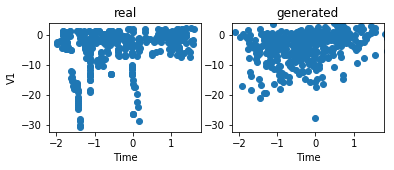

394 394
epoch: 3900, Accuracy: 0.8071065989847716
[3900/5001]	Loss_D: -0.0198	Loss_G: 0.0819	


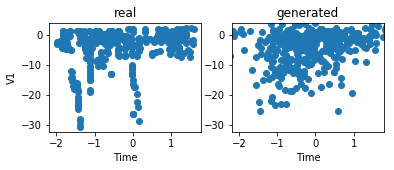

394 394
epoch: 3910, Accuracy: 0.8451776649746193
[3910/5001]	Loss_D: -0.0557	Loss_G: 0.1177	


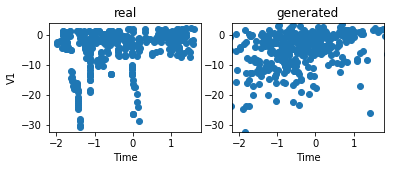

394 394
epoch: 3920, Accuracy: 0.8071065989847716
[3920/5001]	Loss_D: -0.0116	Loss_G: -0.0976	


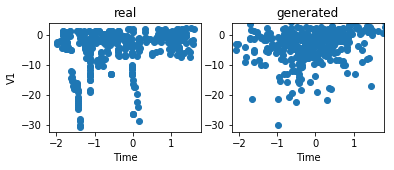

394 394
epoch: 3930, Accuracy: 0.8527918781725888
[3930/5001]	Loss_D: -0.0309	Loss_G: -0.0337	


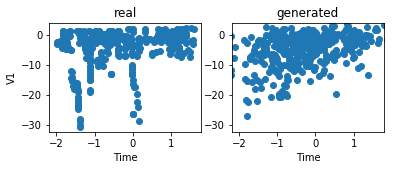

394 394
epoch: 3940, Accuracy: 0.8527918781725888
[3940/5001]	Loss_D: -0.0261	Loss_G: 0.0380	


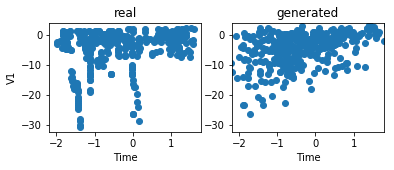

394 394
epoch: 3950, Accuracy: 0.8223350253807107
[3950/5001]	Loss_D: -0.0214	Loss_G: 0.1311	


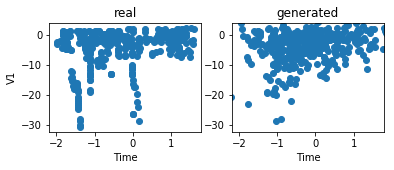

394 394
epoch: 3960, Accuracy: 0.850253807106599
[3960/5001]	Loss_D: -0.0252	Loss_G: -0.0765	


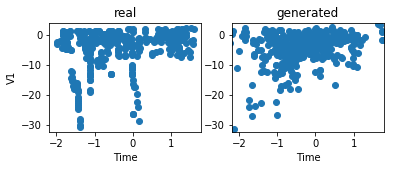

394 394
epoch: 3970, Accuracy: 0.8121827411167513
[3970/5001]	Loss_D: -0.0217	Loss_G: 0.1231	


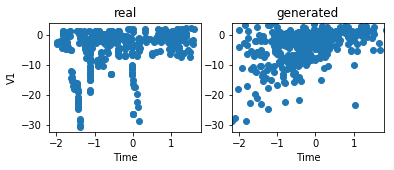

394 394
epoch: 3980, Accuracy: 0.8350253807106599
[3980/5001]	Loss_D: -0.0102	Loss_G: -0.1420	


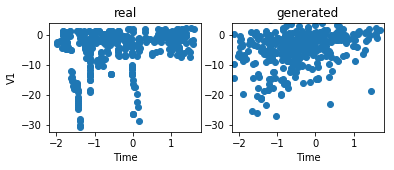

394 394
epoch: 3990, Accuracy: 0.8274111675126904
[3990/5001]	Loss_D: -0.0317	Loss_G: -0.0610	


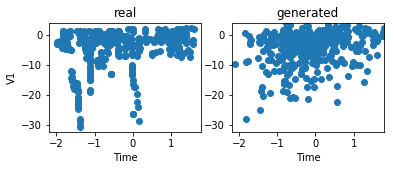

394 394
epoch: 4000, Accuracy: 0.8527918781725888
[4000/5001]	Loss_D: 0.0007	Loss_G: -0.0090	


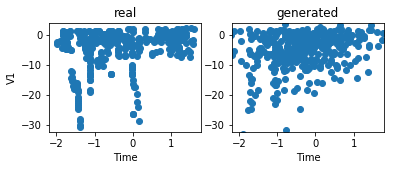

394 394
epoch: 4010, Accuracy: 0.8375634517766497
[4010/5001]	Loss_D: -0.0279	Loss_G: -0.0480	


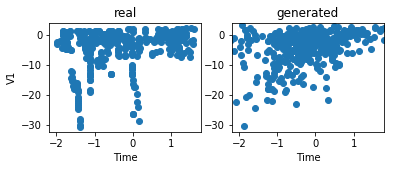

394 394
epoch: 4020, Accuracy: 0.8477157360406091
[4020/5001]	Loss_D: -0.0285	Loss_G: -0.1875	


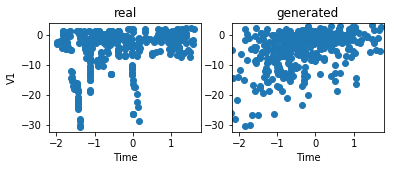

394 394
epoch: 4030, Accuracy: 0.8324873096446701
[4030/5001]	Loss_D: -0.0122	Loss_G: -0.0408	


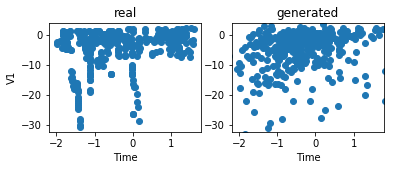

394 394
epoch: 4040, Accuracy: 0.817258883248731
[4040/5001]	Loss_D: 0.0006	Loss_G: 0.0764	


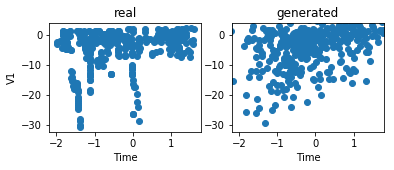

394 394
epoch: 4050, Accuracy: 0.8324873096446701
[4050/5001]	Loss_D: -0.0292	Loss_G: 0.0050	


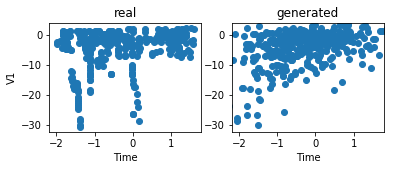

394 394
epoch: 4060, Accuracy: 0.8197969543147208
[4060/5001]	Loss_D: -0.0330	Loss_G: -0.0811	


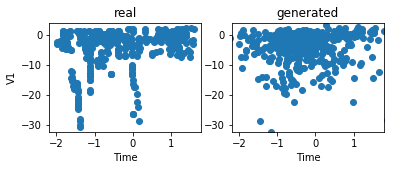

394 394
epoch: 4070, Accuracy: 0.8248730964467005
[4070/5001]	Loss_D: -0.0128	Loss_G: -0.1106	


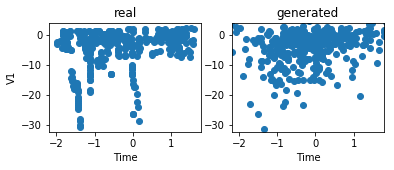

394 394
epoch: 4080, Accuracy: 0.8629441624365483
[4080/5001]	Loss_D: -0.0176	Loss_G: 0.1584	


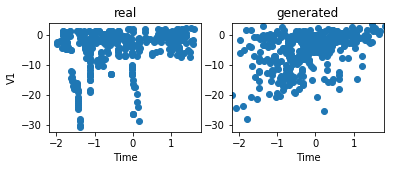

394 394
epoch: 4090, Accuracy: 0.868020304568528
[4090/5001]	Loss_D: -0.0011	Loss_G: 0.1660	


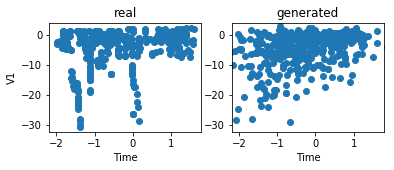

394 394
epoch: 4100, Accuracy: 0.7893401015228426
[4100/5001]	Loss_D: -0.0178	Loss_G: -0.0275	


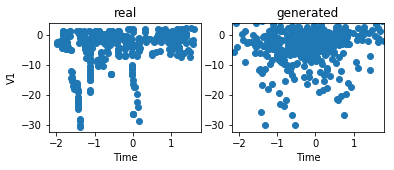

394 394
epoch: 4110, Accuracy: 0.8654822335025381
[4110/5001]	Loss_D: -0.0213	Loss_G: 0.0766	


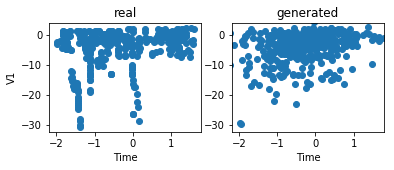

394 394
epoch: 4120, Accuracy: 0.8248730964467005
[4120/5001]	Loss_D: -0.0283	Loss_G: 0.0250	


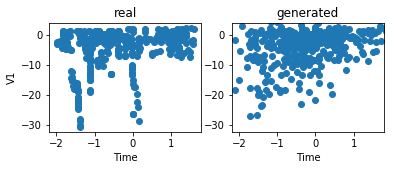

394 394
epoch: 4130, Accuracy: 0.8248730964467005
[4130/5001]	Loss_D: -0.0214	Loss_G: 0.0872	


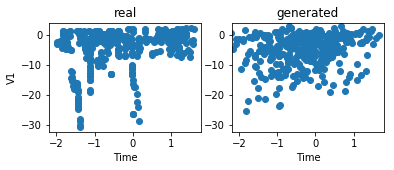

394 394
epoch: 4140, Accuracy: 0.8223350253807107
[4140/5001]	Loss_D: -0.0299	Loss_G: 0.1709	


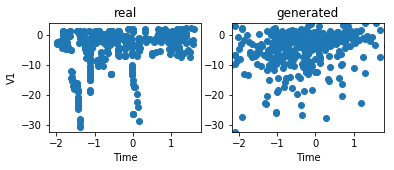

394 394
epoch: 4150, Accuracy: 0.817258883248731
[4150/5001]	Loss_D: -0.0495	Loss_G: 0.0994	


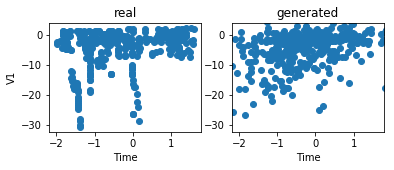

394 394
epoch: 4160, Accuracy: 0.8147208121827412
[4160/5001]	Loss_D: -0.0186	Loss_G: -0.0010	


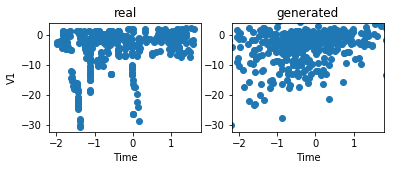

394 394
epoch: 4170, Accuracy: 0.8248730964467005
[4170/5001]	Loss_D: -0.0162	Loss_G: -0.0056	


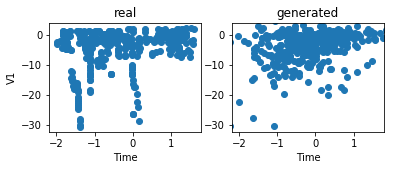

394 394
epoch: 4180, Accuracy: 0.8071065989847716
[4180/5001]	Loss_D: -0.0275	Loss_G: -0.0569	


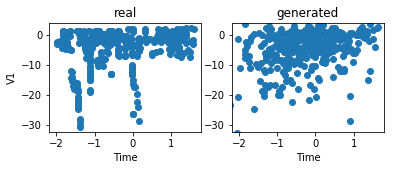

394 394
epoch: 4190, Accuracy: 0.8401015228426396
[4190/5001]	Loss_D: -0.0666	Loss_G: -0.0201	


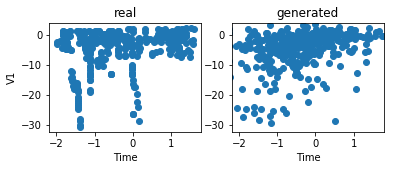

394 394
epoch: 4200, Accuracy: 0.8350253807106599
[4200/5001]	Loss_D: -0.0091	Loss_G: -0.0398	


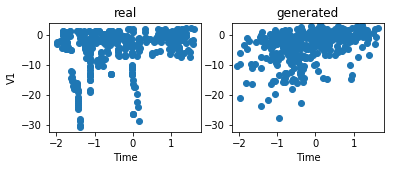

394 394
epoch: 4210, Accuracy: 0.8401015228426396
[4210/5001]	Loss_D: -0.0082	Loss_G: -0.0263	


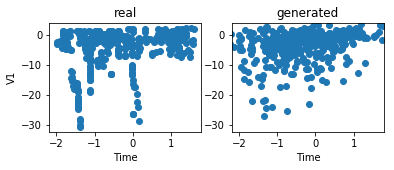

394 394
epoch: 4220, Accuracy: 0.8197969543147208
[4220/5001]	Loss_D: -0.0197	Loss_G: 0.1655	


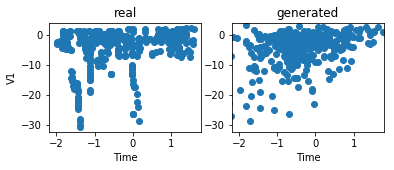

394 394
epoch: 4230, Accuracy: 0.8477157360406091
[4230/5001]	Loss_D: -0.0381	Loss_G: -0.0790	


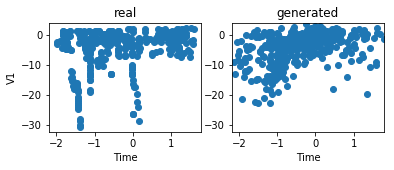

394 394
epoch: 4240, Accuracy: 0.8426395939086294
[4240/5001]	Loss_D: -0.0257	Loss_G: -0.1872	


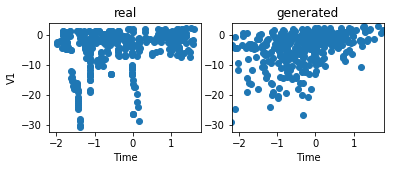

394 394
epoch: 4250, Accuracy: 0.8274111675126904
[4250/5001]	Loss_D: -0.0340	Loss_G: -0.0302	


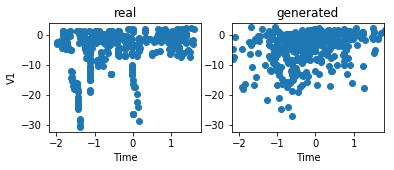

394 394
epoch: 4260, Accuracy: 0.8629441624365483
[4260/5001]	Loss_D: -0.0240	Loss_G: 0.1552	


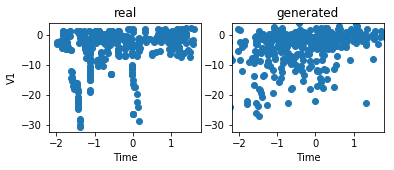

394 394
epoch: 4270, Accuracy: 0.850253807106599
[4270/5001]	Loss_D: -0.0173	Loss_G: 0.0593	


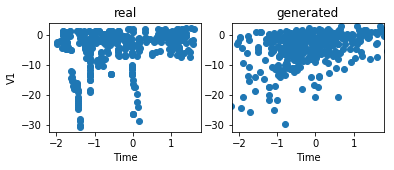

394 394
epoch: 4280, Accuracy: 0.8121827411167513
[4280/5001]	Loss_D: -0.0186	Loss_G: -0.0771	


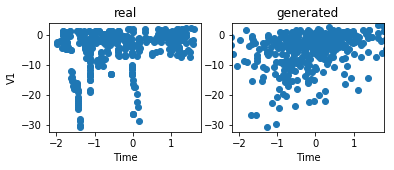

394 394
epoch: 4290, Accuracy: 0.7715736040609137
[4290/5001]	Loss_D: -0.0236	Loss_G: -0.0290	


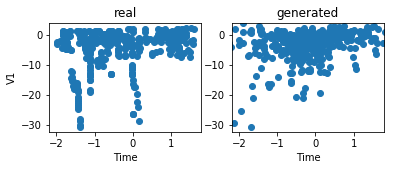

394 394
epoch: 4300, Accuracy: 0.8121827411167513
[4300/5001]	Loss_D: -0.0267	Loss_G: 0.0019	


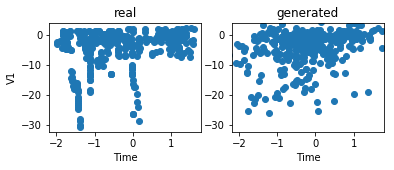

394 394
epoch: 4310, Accuracy: 0.8299492385786802
[4310/5001]	Loss_D: -0.0197	Loss_G: 0.0161	


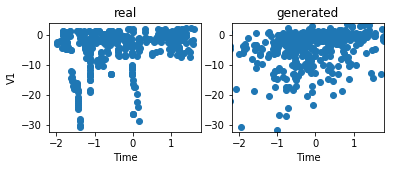

394 394
epoch: 4320, Accuracy: 0.8197969543147208
[4320/5001]	Loss_D: -0.0186	Loss_G: -0.0824	


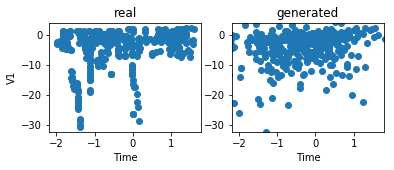

394 394
epoch: 4330, Accuracy: 0.8324873096446701
[4330/5001]	Loss_D: -0.0266	Loss_G: 0.0332	


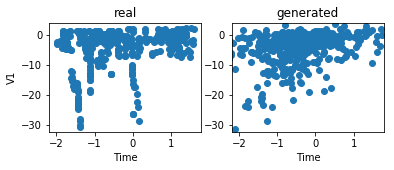

394 394
epoch: 4340, Accuracy: 0.817258883248731
[4340/5001]	Loss_D: -0.0287	Loss_G: 0.0047	


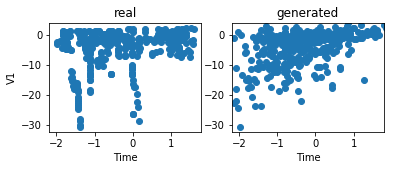

394 394
epoch: 4350, Accuracy: 0.8324873096446701
[4350/5001]	Loss_D: -0.0280	Loss_G: -0.0038	


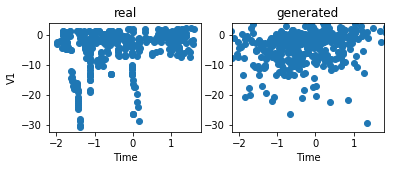

394 394
epoch: 4360, Accuracy: 0.8350253807106599
[4360/5001]	Loss_D: -0.0176	Loss_G: 0.1174	


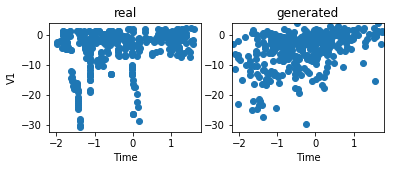

394 394
epoch: 4370, Accuracy: 0.8020304568527918
[4370/5001]	Loss_D: -0.0165	Loss_G: 0.2214	


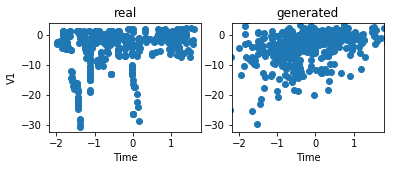

394 394
epoch: 4380, Accuracy: 0.8324873096446701
[4380/5001]	Loss_D: 0.0068	Loss_G: -0.0426	


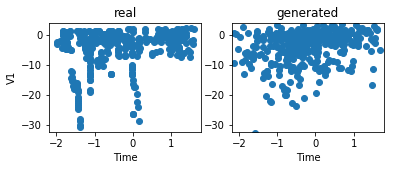

394 394
epoch: 4390, Accuracy: 0.8274111675126904
[4390/5001]	Loss_D: -0.0241	Loss_G: -0.1816	


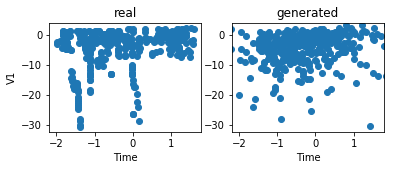

394 394
epoch: 4400, Accuracy: 0.8197969543147208
[4400/5001]	Loss_D: -0.0285	Loss_G: 0.0750	


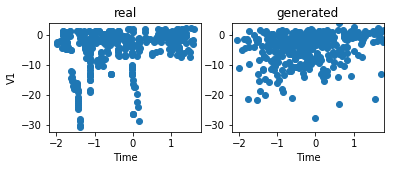

394 394
epoch: 4410, Accuracy: 0.8350253807106599
[4410/5001]	Loss_D: -0.0107	Loss_G: -0.0352	


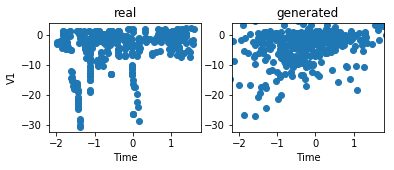

394 394
epoch: 4420, Accuracy: 0.7817258883248731
[4420/5001]	Loss_D: -0.0271	Loss_G: 0.1542	


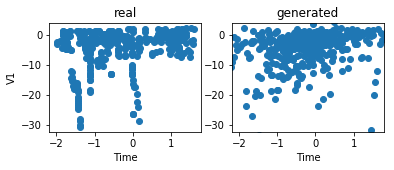

394 394
epoch: 4430, Accuracy: 0.8451776649746193
[4430/5001]	Loss_D: -0.0295	Loss_G: -0.0020	


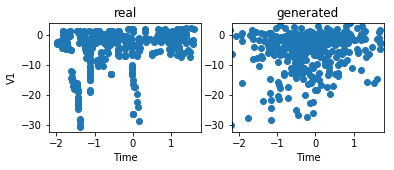

394 394
epoch: 4440, Accuracy: 0.7918781725888325
[4440/5001]	Loss_D: 0.0097	Loss_G: 0.0054	


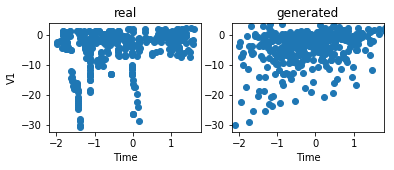

394 394
epoch: 4450, Accuracy: 0.8197969543147208
[4450/5001]	Loss_D: -0.0426	Loss_G: -0.1196	


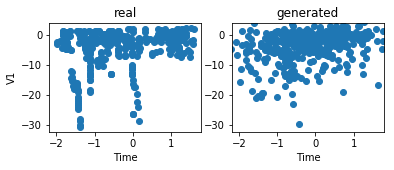

394 394
epoch: 4460, Accuracy: 0.7918781725888325
[4460/5001]	Loss_D: -0.0375	Loss_G: -0.0354	


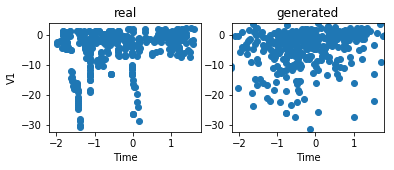

394 394
epoch: 4470, Accuracy: 0.8401015228426396
[4470/5001]	Loss_D: -0.0158	Loss_G: 0.1116	


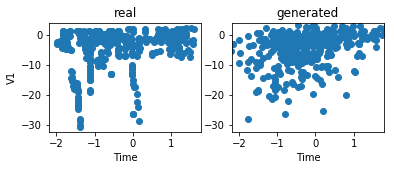

394 394
epoch: 4480, Accuracy: 0.8223350253807107
[4480/5001]	Loss_D: -0.0137	Loss_G: 0.1452	


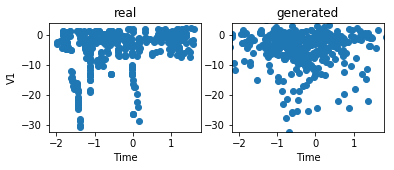

394 394
epoch: 4490, Accuracy: 0.817258883248731
[4490/5001]	Loss_D: -0.0257	Loss_G: -0.0253	


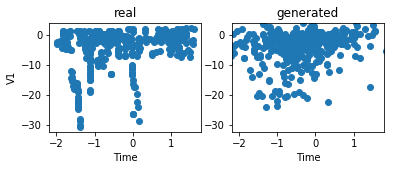

394 394
epoch: 4500, Accuracy: 0.8299492385786802
[4500/5001]	Loss_D: 0.0045	Loss_G: -0.0884	


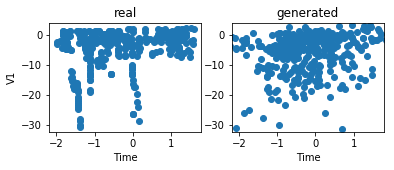

394 394
epoch: 4510, Accuracy: 0.8527918781725888
[4510/5001]	Loss_D: 0.0124	Loss_G: 0.1298	


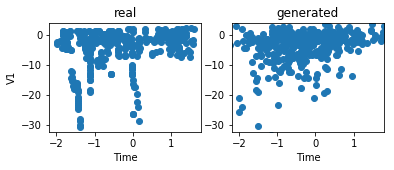

394 394
epoch: 4520, Accuracy: 0.8020304568527918
[4520/5001]	Loss_D: -0.0249	Loss_G: -0.2052	


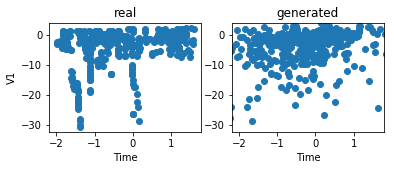

394 394
epoch: 4530, Accuracy: 0.8401015228426396
[4530/5001]	Loss_D: -0.0115	Loss_G: 0.0069	


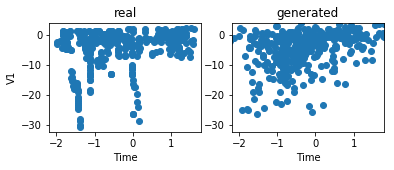

394 394
epoch: 4540, Accuracy: 0.8020304568527918
[4540/5001]	Loss_D: -0.0277	Loss_G: -0.2448	


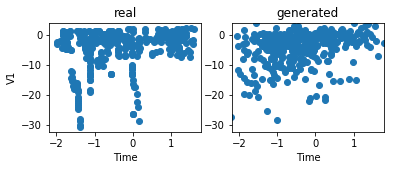

394 394
epoch: 4550, Accuracy: 0.8426395939086294
[4550/5001]	Loss_D: -0.0099	Loss_G: -0.0513	


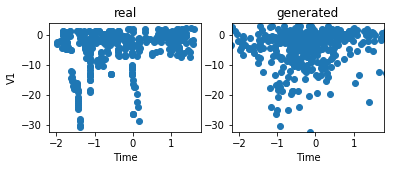

394 394
epoch: 4560, Accuracy: 0.850253807106599
[4560/5001]	Loss_D: -0.0862	Loss_G: -0.1293	


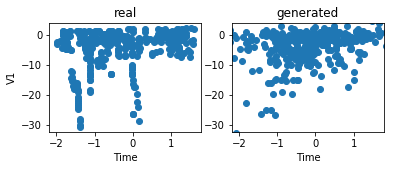

394 394
epoch: 4570, Accuracy: 0.8121827411167513
[4570/5001]	Loss_D: -0.0005	Loss_G: 0.0268	


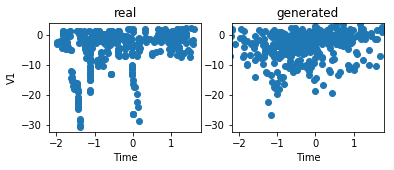

394 394
epoch: 4580, Accuracy: 0.8223350253807107
[4580/5001]	Loss_D: -0.0056	Loss_G: -0.0356	


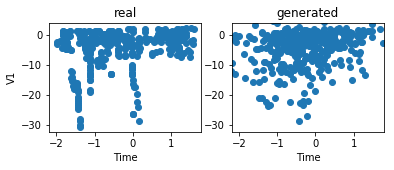

394 394
epoch: 4590, Accuracy: 0.8375634517766497
[4590/5001]	Loss_D: -0.0140	Loss_G: 0.1391	


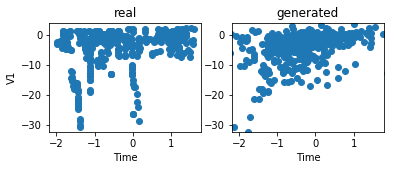

394 394
epoch: 4600, Accuracy: 0.8527918781725888
[4600/5001]	Loss_D: -0.0154	Loss_G: -0.1979	


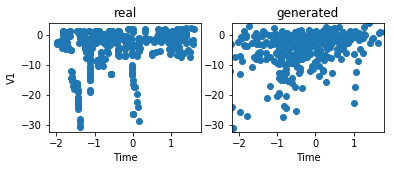

394 394
epoch: 4610, Accuracy: 0.8147208121827412
[4610/5001]	Loss_D: -0.0083	Loss_G: 0.0864	


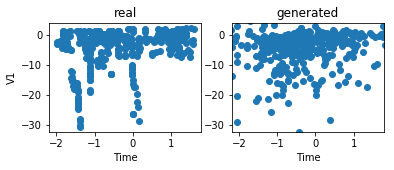

394 394
epoch: 4620, Accuracy: 0.8375634517766497
[4620/5001]	Loss_D: -0.0190	Loss_G: -0.0192	


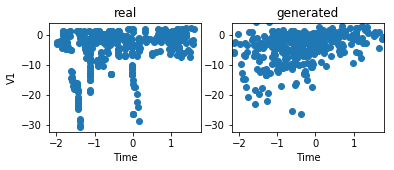

394 394
epoch: 4630, Accuracy: 0.8324873096446701
[4630/5001]	Loss_D: -0.0326	Loss_G: 0.1453	


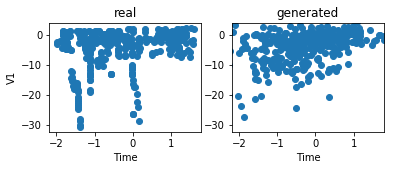

394 394
epoch: 4640, Accuracy: 0.8553299492385786
[4640/5001]	Loss_D: -0.0359	Loss_G: 0.0446	


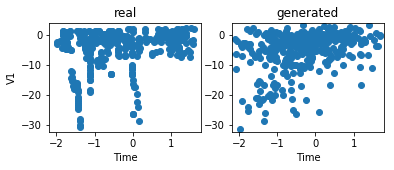

394 394
epoch: 4650, Accuracy: 0.8096446700507615
[4650/5001]	Loss_D: -0.0291	Loss_G: 0.0808	


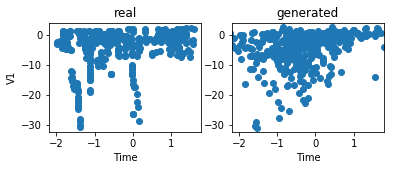

394 394
epoch: 4660, Accuracy: 0.8223350253807107
[4660/5001]	Loss_D: -0.0153	Loss_G: 0.0721	


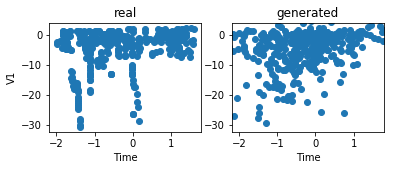

394 394
epoch: 4670, Accuracy: 0.8527918781725888
[4670/5001]	Loss_D: 0.0002	Loss_G: -0.5830	


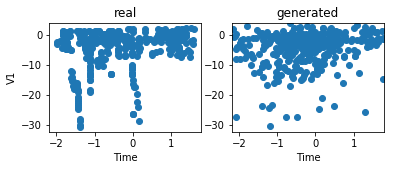

394 394
epoch: 4680, Accuracy: 0.8527918781725888
[4680/5001]	Loss_D: 0.0038	Loss_G: 0.0762	


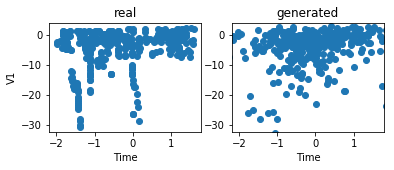

394 394
epoch: 4690, Accuracy: 0.868020304568528
[4690/5001]	Loss_D: -0.0016	Loss_G: -0.2149	


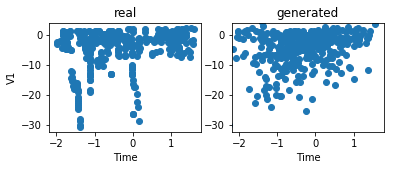

394 394
epoch: 4700, Accuracy: 0.8426395939086294
[4700/5001]	Loss_D: -0.0017	Loss_G: -0.0021	


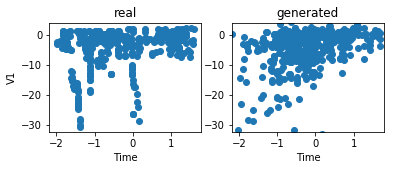

394 394
epoch: 4710, Accuracy: 0.8426395939086294
[4710/5001]	Loss_D: -0.0051	Loss_G: -0.0174	


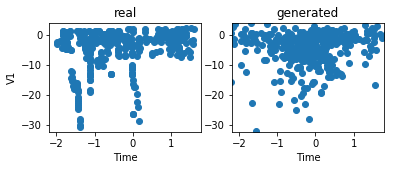

394 394
epoch: 4720, Accuracy: 0.8223350253807107
[4720/5001]	Loss_D: -0.0072	Loss_G: -0.0195	


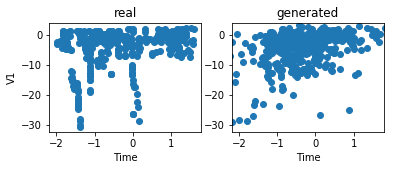

394 394
epoch: 4730, Accuracy: 0.817258883248731
[4730/5001]	Loss_D: -0.0090	Loss_G: -0.0320	


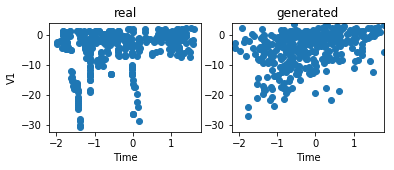

394 394
epoch: 4740, Accuracy: 0.8020304568527918
[4740/5001]	Loss_D: -0.0096	Loss_G: -0.0217	


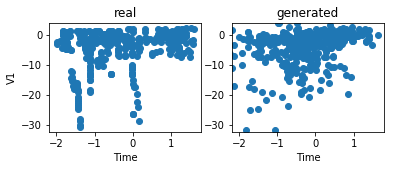

394 394
epoch: 4750, Accuracy: 0.8121827411167513
[4750/5001]	Loss_D: -0.0058	Loss_G: -0.0235	


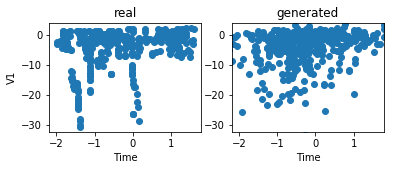

394 394
epoch: 4760, Accuracy: 0.8248730964467005
[4760/5001]	Loss_D: -0.0106	Loss_G: -0.0681	


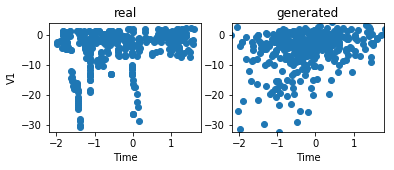

394 394
epoch: 4770, Accuracy: 0.8147208121827412
[4770/5001]	Loss_D: -0.0254	Loss_G: 0.0391	


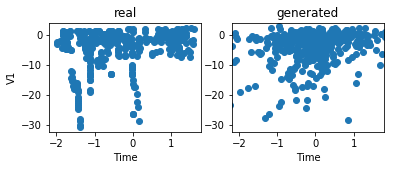

394 394
epoch: 4780, Accuracy: 0.799492385786802
[4780/5001]	Loss_D: -0.0102	Loss_G: 0.2593	


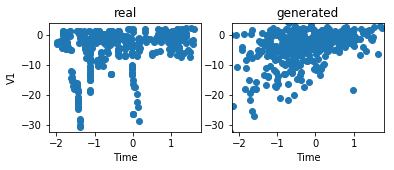

394 394
epoch: 4790, Accuracy: 0.817258883248731
[4790/5001]	Loss_D: -0.0135	Loss_G: 0.2823	


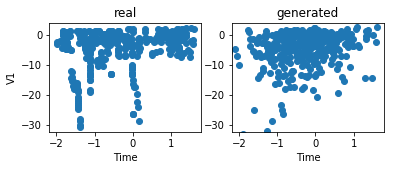

394 394
epoch: 4800, Accuracy: 0.8401015228426396
[4800/5001]	Loss_D: -0.0199	Loss_G: -0.0732	


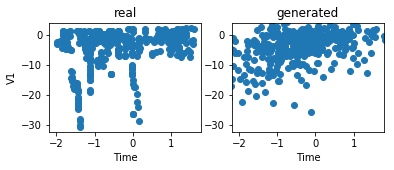

394 394
epoch: 4810, Accuracy: 0.8350253807106599
[4810/5001]	Loss_D: -0.0392	Loss_G: -0.0974	


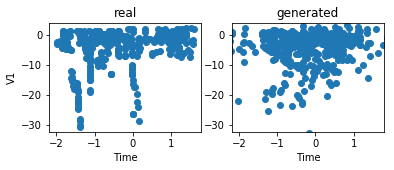

394 394
epoch: 4820, Accuracy: 0.8350253807106599
[4820/5001]	Loss_D: -0.0141	Loss_G: 0.1809	


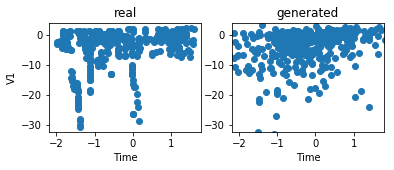

394 394
epoch: 4830, Accuracy: 0.8604060913705583
[4830/5001]	Loss_D: -0.0170	Loss_G: -0.2300	


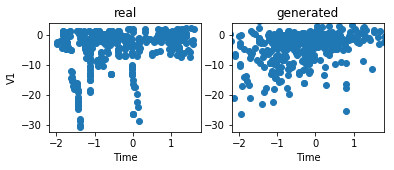

394 394
epoch: 4840, Accuracy: 0.8324873096446701
[4840/5001]	Loss_D: -0.0132	Loss_G: 0.1879	


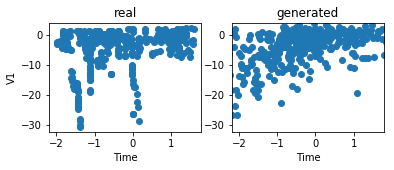

394 394
epoch: 4850, Accuracy: 0.8096446700507615
[4850/5001]	Loss_D: -0.0168	Loss_G: -0.0272	


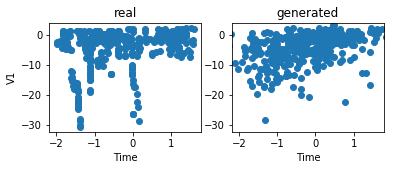

394 394
epoch: 4860, Accuracy: 0.8223350253807107
[4860/5001]	Loss_D: 0.0026	Loss_G: 0.3265	


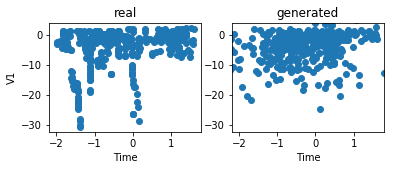

394 394
epoch: 4870, Accuracy: 0.8350253807106599
[4870/5001]	Loss_D: -0.0890	Loss_G: 0.3968	


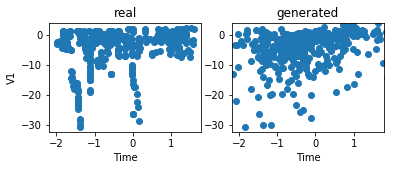

394 394
epoch: 4880, Accuracy: 0.8071065989847716
[4880/5001]	Loss_D: -0.0144	Loss_G: 0.6428	


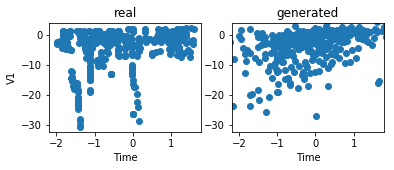

394 394
epoch: 4890, Accuracy: 0.8426395939086294
[4890/5001]	Loss_D: -0.0326	Loss_G: -0.4059	


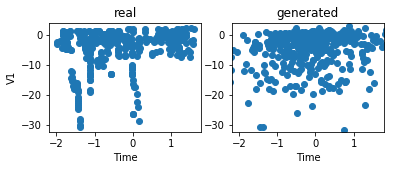

394 394
epoch: 4900, Accuracy: 0.8071065989847716
[4900/5001]	Loss_D: -0.0199	Loss_G: -0.2051	


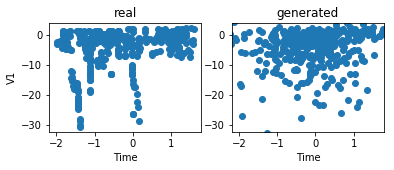

394 394
epoch: 4910, Accuracy: 0.7969543147208121
[4910/5001]	Loss_D: -0.0305	Loss_G: -0.4312	


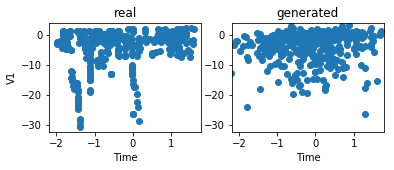

394 394
epoch: 4920, Accuracy: 0.8299492385786802
[4920/5001]	Loss_D: -0.0306	Loss_G: -0.4362	


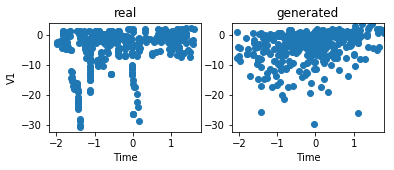

394 394
epoch: 4930, Accuracy: 0.8553299492385786
[4930/5001]	Loss_D: 0.0036	Loss_G: -0.0447	


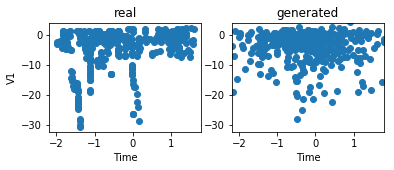

394 394
epoch: 4940, Accuracy: 0.8096446700507615
[4940/5001]	Loss_D: -0.0131	Loss_G: -0.0184	


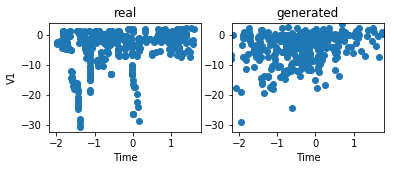

394 394
epoch: 4950, Accuracy: 0.8654822335025381
[4950/5001]	Loss_D: -0.0190	Loss_G: -0.1350	


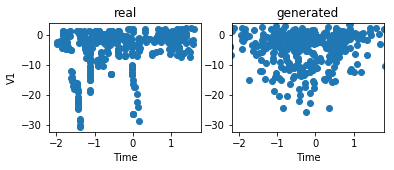

394 394
epoch: 4960, Accuracy: 0.7893401015228426
[4960/5001]	Loss_D: 0.0133	Loss_G: 0.1122	


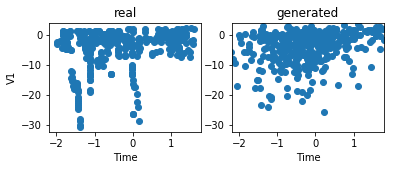

394 394
epoch: 4970, Accuracy: 0.850253807106599
[4970/5001]	Loss_D: 0.0208	Loss_G: -0.3538	


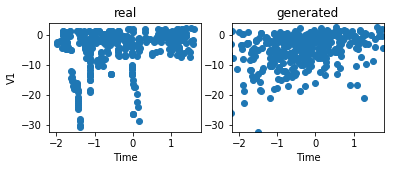

394 394
epoch: 4980, Accuracy: 0.8426395939086294
[4980/5001]	Loss_D: -0.0073	Loss_G: -0.0311	


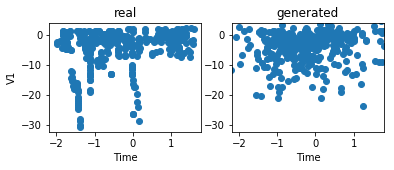

394 394
epoch: 4990, Accuracy: 0.8426395939086294
[4990/5001]	Loss_D: -0.0204	Loss_G: -0.0952	


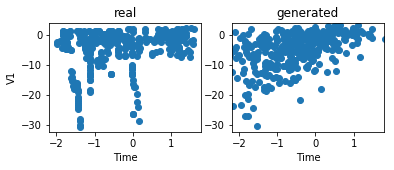

394 394
epoch: 5000, Accuracy: 0.7868020304568528
[5000/5001]	Loss_D: -0.0075	Loss_G: -0.2431	


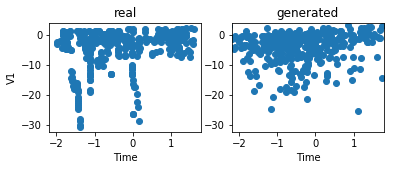

It took  1690.488226890564


In [15]:
xgblosses, G_losses, D_Losses, generated_data, real_data_list = wgan.train(dataloader, randomNoise_dim = 32, hidden_dim = 128, realData_dim =dataloader.dataset.features.size(1), lr = 0.0002, num_epochs=5000, feature_cols=feature_cols, device='cpu')

In [16]:
len(generated_data)

394

In [17]:
import pickle
pickle.dump(xgblosses, open('xgblosses.pkl', 'wb'))

array([0.58375635, 0.73857868, 0.96192893, 0.95685279, 0.96700508,
       0.91624365, 0.89340102, 0.95177665, 0.96192893, 0.94162437,
       0.89847716, 0.97208122, 0.94162437, 0.93908629, 0.92893401,
       0.91370558, 0.90862944, 0.86040609, 0.87563452, 0.89340102,
       0.88324873, 0.93147208, 0.8680203 , 0.93908629, 0.92385787,
       0.9213198 , 0.90101523, 0.9035533 , 0.87309645, 0.91370558,
       0.88071066, 0.91370558, 0.90862944, 0.89847716, 0.93908629,
       0.91116751, 0.9035533 , 0.89847716, 0.90862944, 0.89847716,
       0.92385787, 0.92385787, 0.90862944, 0.88832487, 0.9035533 ,
       0.88324873, 0.89847716, 0.90609137, 0.91370558, 0.85532995,
       0.91116751, 0.89086294, 0.92893401, 0.86548223, 0.87817259,
       0.89593909, 0.83248731, 0.9035533 , 0.9035533 , 0.85025381,
       0.85279188, 0.88071066, 0.88071066, 0.85279188, 0.90101523,
       0.91878173, 0.89847716, 0.88324873, 0.85025381, 0.90862944,
       0.88071066, 0.85532995, 0.89847716, 0.89340102, 0.90355

In [18]:
number = 0.87817259

In [19]:
for i in range(xgblosses.size):
    if np.round(xgblosses[i],6) == np.round(np.min(xgblosses[100:]),6):
        best_round = i*10
        print(best_round)

4290


In [160]:
w=50

0.7715736040609137


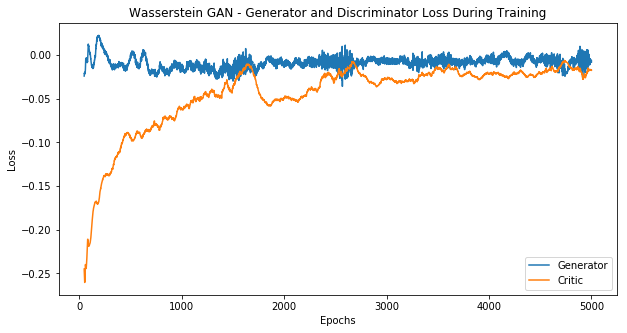

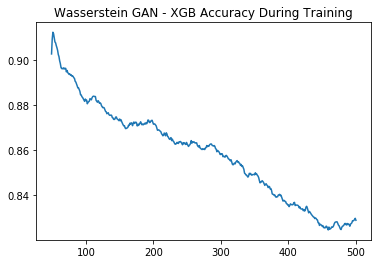

In [162]:
print(min(xgblosses[10:]))
plt.figure(figsize=(10,5))
plt.title(f"Wasserstein GAN - Generator and Discriminator Loss During Training")
b = pd.DataFrame(G_losses[:]).rolling(w).mean()
c = pd.DataFrame(D_Losses[:]).rolling(w).mean()
# plt.plot(G_losses,label="G")
# plt.plot(D_Losses,label="D")
plt.plot(b,label="Generator")
plt.plot(c,label="Critic")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f'reports/figures/gan/WGAN.png')
plt.show()


a = pd.DataFrame(xgblosses[:]).rolling(w).mean()
plt.title(f"Wasserstein GAN - XGB Accuracy During Training")
plt.plot(a)
plt.savefig(f'reports/figures/gan/xgblosses_WGAN.png')
plt.show()

In [22]:
amount=train.shape[0]
device='cpu'

In [23]:
train.shape[0]

227845

In [89]:
randomNoise_dim = 32; hidden_dim = 128; realData_dim =dataloader.dataset.features.size(1)

In [119]:
best_round = 2690

In [121]:
more_data = wgan.generate_data(best_round, randomNoise_dim, hidden_dim, realData_dim, amount, 'cpu')

In [122]:
more_data = more_data.detach().numpy()

In [123]:
b = np.ones((more_data.shape[0],more_data.shape[1]+1))
b[:,:-1] = more_data

In [124]:
b.shape

(227845, 31)

In [125]:
df_generatedData = pd.DataFrame(b, columns = feature_cols + label_col)
df_generatedData.head()

Time        V1        V2        V3        V4        V5        V6  \
0  0.348775  2.221611  3.644845 -7.424181  8.898606  1.366859 -2.986659   
1 -1.610062 -3.129918  4.638000 -8.556901  6.596541 -2.853383 -4.568613   
2 -0.282468 -0.951937  0.073098  0.625669  1.713345 -1.543775  0.290274   
3  0.277754  0.396339  0.028325 -0.717528  2.311963  0.613592  0.224314   
4  0.896339  0.316706  4.039723 -8.920073  5.848505  0.225389 -3.646606   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0 -3.060329 -0.396412 -5.226619  ...  0.121049 -0.790701 -1.321033 -0.223423   
1 -8.768974  1.966121 -5.135280  ...  2.275998 -0.443359 -0.905842 -0.495738   
2  1.270783 -0.561008 -0.392528  ...  1.167160  0.409280 -0.280634  0.645517   
3  0.984812 -1.214596 -0.953493  ...  0.348639  0.153709  0.076933 -0.005572   
4 -5.348508  0.704420 -4.491223  ...  1.661930 -0.188139  0.418848 -0.258107   

        V25       V26       V27       V28    Amount  Class  
0  0.204216  0.570121  0.999932  0.165110 -0.483832    1.0  
1  0.636495  0.411586  2.437681  1.188717 -1.000460    1.0  
2 -0.142629 -0.566662 -0.726701 -0.055971  0.812603    1.0  
3 -0.050355  0.080665  0.023600  0.127563  0.656377    1.0  
4  0.142287  0.428326  1.050601  0.180208 -1.295729    1.0  

[5 rows x 31 columns]

In [126]:
train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [127]:
train = train.append(df_generatedData)
train = train.sample(frac=1)

In [128]:
train.shape

(455690, 31)

In [129]:
train.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [130]:
train_y = train.Class

In [131]:
train_y

202726    0.0
94310     1.0
279070    0.0
180926    0.0
42924     1.0
159645    0.0
16486     1.0
86835     1.0
242345    0.0
195947    1.0
185550    0.0
7126      1.0
282254    0.0
209640    0.0
167181    0.0
112882    1.0
206326    0.0
205372    1.0
74546     1.0
35171     0.0
209660    0.0
39939     1.0
166325    1.0
171519    0.0
54574     1.0
35750     1.0
143001    0.0
144339    1.0
124132    1.0
180967    1.0
         ... 
84343     1.0
39349     0.0
27119     0.0
127322    0.0
165505    1.0
203355    0.0
48270     0.0
239938    0.0
181384    1.0
116054    0.0
112383    1.0
71680     1.0
199442    1.0
84651     0.0
155657    1.0
260513    0.0
202266    1.0
116411    0.0
146052    0.0
92344     0.0
89534     1.0
170867    0.0
136443    1.0
13143     1.0
93725     1.0
115359    1.0
61443     0.0
182188    1.0
39322     1.0
121072    1.0
Name: Class, Length: 455690, dtype: float64

In [132]:
train_y.isnull().sum()

0

In [133]:
train_X = train

In [134]:
train_X.drop('Class', axis=1, inplace=True)

# XGBoost

In [135]:
train_y.head()

202726    0.0
94310     1.0
279070    0.0
180926    0.0
42924     1.0
Name: Class, dtype: float64

In [136]:
train_X.head()


Time         V1        V2        V3        V4        V5        V6  \
202726  0.835351  -0.971417  0.512745 -1.774363 -2.318818  2.303630  3.769242   
94310  -0.712332  -0.950200  0.538782 -1.872172  4.032822 -0.554766  0.343975   
279070  1.554769  -0.531484  1.454037  0.405257  3.976238  1.307021  2.934246   
180926  0.630859   2.110459  0.036097 -2.120190  0.073028  0.365253 -1.816786   
42924   1.284095 -11.450127  9.896654 -8.825342  1.704430 -3.180631  3.293356   

               V7         V8        V9  ...       V20       V21       V22  \
202726   2.084422   0.568899 -0.410868  ... -0.135826  0.244612  0.604616   
94310    0.360501  -0.816775 -1.984355  ...  0.374768  0.383883 -0.267387   
279070  -0.278865   1.186226 -2.172375  ...  0.217455  0.341547  1.102576   
180926   0.778978  -0.576840  0.331303  ... -0.269312  0.142651  0.492821   
42924  -12.180092 -18.215576 -2.869837  ... -2.547751  9.977174 -3.034179   

             V23       V24       V25       V26       V27       V28    Amount  
202726 -0.227638  0.621660  0.562649 -0.275314  0.097565  0.061342  0.925902  
94310  -0.497453 -0.131237  0.194117  0.406280  0.556545  0.043963  1.366448  
279070 -0.011832 -0.931691 -0.791516  0.502554  0.399236  0.176081 -0.265485  
180926 -0.051244  0.013251  0.414075  0.243523 -0.093964 -0.078868 -0.280587  
42924   3.998911 -0.203336  0.242167  0.300615 -0.151736  1.070612 -1.678105  

[5 rows x 30 columns]

In [137]:

test_X = test.iloc[:,:-1]

test_y = test.iloc[:,-1]

In [138]:
test_X.head()

Time         V1        V2         V3        V4         V5  \
43428  -1.122118 -16.526507  8.584972 -18.649853  9.505594 -13.793819   
49906  -1.064083   0.339812 -2.743745  -0.134070 -1.385729  -1.451413   
29474  -1.248907   1.399590 -0.590701   0.168619 -1.029950  -0.539806   
276481  1.523119  -0.432071  1.647895  -1.669361 -0.349504   0.785785   
278846  1.551547   2.014160 -0.137394  -1.015839  0.327269  -0.182179   

              V6         V7        V8        V9  ...       V20       V21  \
43428  -2.832404 -16.701694  7.517344 -8.507059  ... -1.514923  1.190739   
49906   1.015887  -0.524379  0.224060  0.899746  ...  0.506044 -0.213436   
29474   0.040444  -0.712567  0.002299 -0.971747  ...  0.212877  0.102398   
276481 -0.630647   0.276990  0.586025 -0.484715  ... -0.244633  0.358932   
278846 -0.956571   0.043241 -0.160746  0.363241  ... -0.255293 -0.238644   

             V22       V23       V24       V25       V26       V27       V28  \
43428  -1.127670 -2.358579  0.673461 -1.413700 -0.462762 -2.018575 -1.042804   
49906  -0.942525 -0.526819 -1.156992  0.311211 -0.746647  0.040996  0.102038   
29474   0.168269 -0.166639 -0.810250  0.505083 -0.232340  0.011409  0.004634   
276481  0.873663 -0.178642 -0.017171 -0.207392 -0.157756 -0.237386  0.001934   
278846 -0.616400  0.347045  0.061561 -0.360196  0.174730 -0.078043 -0.070571   

          Amount  
43428  -1.988452  
49906  -1.985169  
29474  -1.995469  
276481 -1.996090  
278846 -1.996103  

[5 rows x 30 columns]

In [139]:
start_time = time.time()
dtrain = xgb.DMatrix(train_X, train_y, feature_names=feature_cols)
dtest = xgb.DMatrix(test_X, feature_names=feature_cols)

results_dict = {}

param = {
        'max_depth':5, 
        'eta':0.3, 
        'verbosity': 1, 
        'objective':'binary:logistic', 
        'eval_metric': 'auc', 
        'seed': 42
        }

model = xgb.train(param, dtrain, num_boost_round=100)
# make prediction
preds = np.round(model.predict(dtest))
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

/home/chinne/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/chinne/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Time elapsed to train:  46.604140758514404


In [140]:
print('---' * 45)
print('XGBoost ROC/AUC: {:.6f}'.format(roc_auc_score(test_y, preds)))
print('Recall Score: {:.6f}'.format(recall_score(test_y, preds)))
print('Precision Score: {:.6f}'.format(precision_score(test_y, preds)))
print('F1 Score: {:.6f}'.format(f1_score(test_y, preds)))
print('Accuracy Score: {:.6f}'.format(accuracy_score(test_y, preds)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
XGBoost ROC/AUC: 0.933165
Recall Score: 0.918367
Precision Score: 0.029518
F1 Score: 0.057197
Accuracy Score: 0.947913
---------------------------------------------------------------------------------------------------------------------------------------
